In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
data = pd.read_csv("training_data.csv")

data['hour'] = pd.to_datetime(data['hour'])


In [4]:
data

hour  day  hour_of_day         city  pressure  \
0     1970-01-01 00:00:00.000000001    1            0   Tensorburg    0.9981   
1     1970-01-01 00:00:00.000000001    1            0  Sparseville    0.9879   
2     1970-01-01 00:00:00.000000001    1            0   Offshore B    1.0064   
3     1970-01-01 00:00:00.000000001    1            0   ReLU Ridge    1.0106   
4     1970-01-01 00:00:00.000000001    1            0    GANopolis    0.9954   
...                             ...  ...          ...          ...       ...   
18049 1970-01-01 00:00:00.000002257   95            0   Offshore A    0.7826   
18050 1970-01-01 00:00:00.000002257   95            0   Tensorburg    0.7805   
18051 1970-01-01 00:00:00.000002257   95            0   ReLU Ridge    0.7706   
18052 1970-01-01 00:00:00.000002257   95            0    Bayes Bay    0.7790   
18053 1970-01-01 00:00:00.000002257   95            0  Sparseville    0.7978   

       air_temp  ground_temp  velocity_x  velocity_y  windspeed  damage  
0        0.0001       0.0025     -0.0729     -0.0098     0.0743  0.2870  
1       -0.0001      -0.0025     -0.1315     -0.0137     0.1329  0.5212  
2       -0.0000      -0.0005     -0.1133      0.0121     0.1144  0.4280  
3        0.0003       0.0046     -0.1363     -0.0015     0.1366  0.5430  
4       -0.0001      -0.0017     -0.0655     -0.0121     0.0678  0.2692  
...         ...          ...         ...         ...        ...     ...  
18049    0.0031       0.0024     -0.1580      0.0378     0.1641  0.7038  
18050   -0.0040      -0.0051     -0.0638     -0.0795     0.1025  0.3831  
18051   -0.0002      -0.0006     -0.1716      0.0436     0.1772  0.8060  
18052   -0.0053      -0.0059     -0.0372      0.0506     0.0631  0.2557  
18053   -0.0028      -0.0027      0.0147      0.0343     0.0375  0.1980  

[18054 rows x 11 columns]

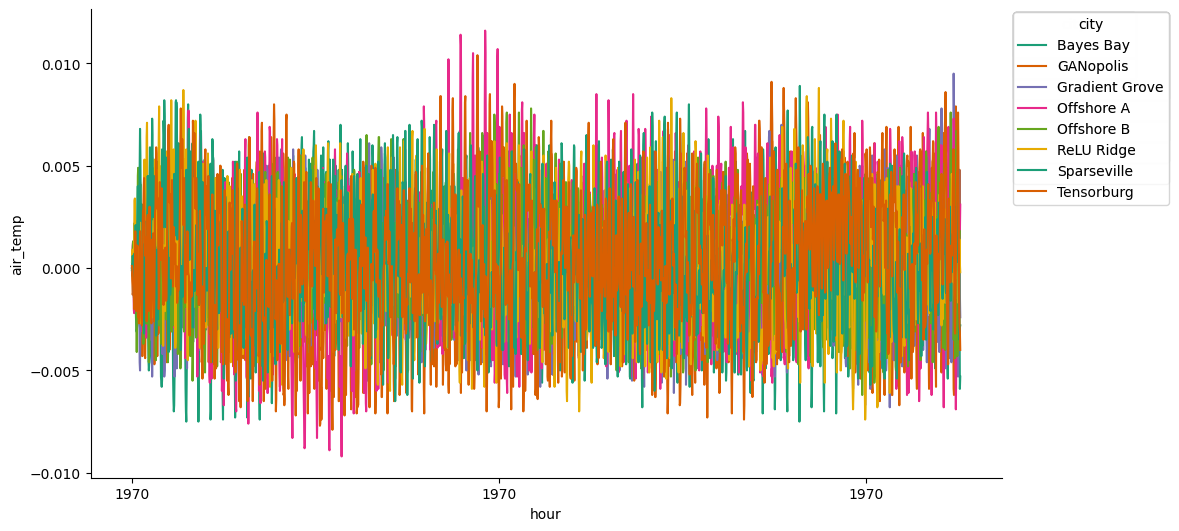

In [7]:
# @title hour vs air_temp

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['hour']
  ys = series['air_temp']

  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = data.sort_values('hour', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('city')):
  _plot_series(series, series_name, i)
  fig.legend(title='city', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('hour')
_ = plt.ylabel('air_temp')

<ipython-input-8-19196ff8e822>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data, x='air_temp', y='city', inner='box', palette='Dark2')


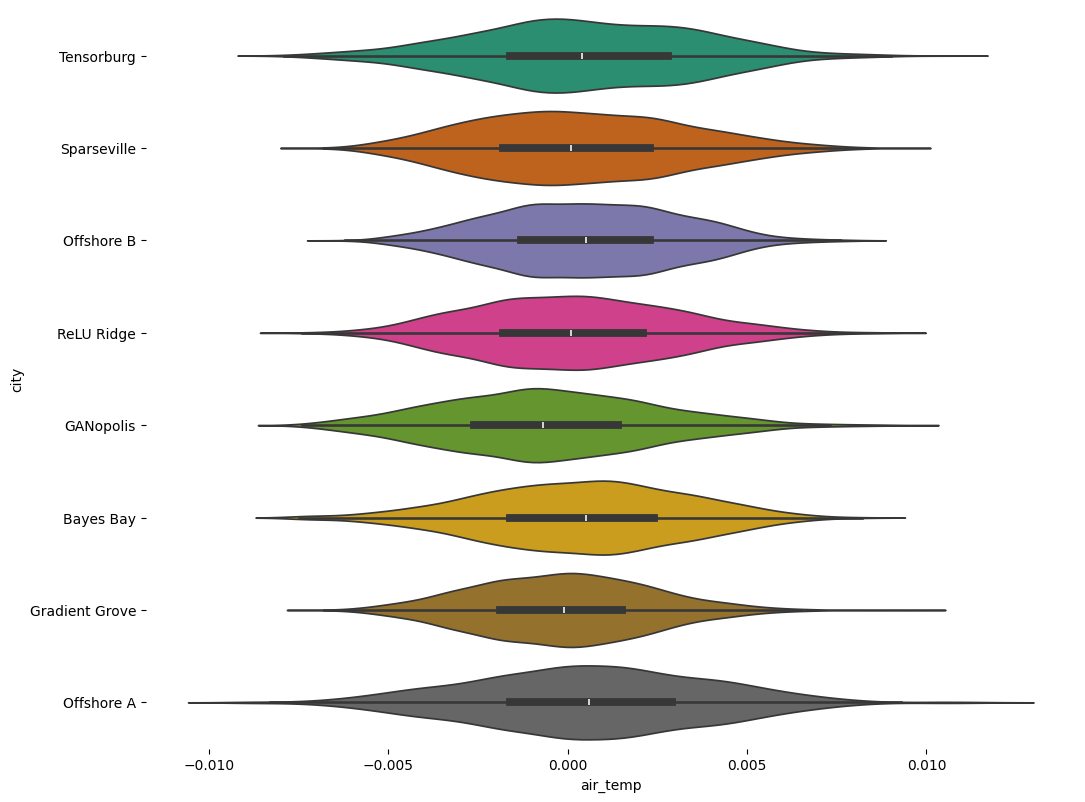

In [8]:
# @title city vs air_temp

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(data['city'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(data, x='air_temp', y='city', inner='box', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, TimeSeriesSplit, cross_val_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.varmax import VARMAX
import xgboost as xgb
from datetime import datetime

In [18]:
def load_data():
    train_data = pd.read_csv('training_data.csv')
    # Filter for GANopolis
    ganopolis_data = train_data[train_data['city'] == 'GANopolis'].copy()
    # Sort by time
    ganopolis_data = ganopolis_data.sort_values(by=['day', 'hour_of_day'])
    return ganopolis_data

# Exploratory Data Analysis
def eda(data):
    # Basic statistics
    print("Basic Statistics:")
    print(data.describe())

    # Check for missing values
    print("\nMissing Values:")
    print(data.isnull().sum())

    # Time Series Plot of Wind Speed
    plt.figure(figsize=(12, 6))
    plt.plot(data['hour'], data['windspeed'])
    plt.title('Wind Speed Over Time in GANopolis')
    plt.xlabel('Hour')
    plt.ylabel('Wind Speed')
    plt.savefig('windspeed_timeseries.png')

    # Correlation Matrix
    plt.figure(figsize=(10, 8))
    corr_matrix = data[['pressure', 'air_temp', 'ground_temp', 'velocity_x',
                         'velocity_y', 'windspeed', 'damage']].corr()
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
    plt.title('Correlation Matrix')
    plt.savefig('correlation_matrix.png')

    # Wind Speed vs Damage
    plt.figure(figsize=(10, 6))
    plt.scatter(data['windspeed'], data['damage'], alpha=0.5)
    plt.title('Wind Speed vs Damage')
    plt.xlabel('Wind Speed')
    plt.ylabel('Damage')
    plt.savefig('windspeed_vs_damage.png')

    return corr_matrix

# Feature Engineering
def feature_engineering(data):
    # Create a copy to avoid modifying the original
    df = data.copy()

    # Create time-based features
    df['hour_sin'] = np.sin(2 * np.pi * df['hour_of_day'] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour_of_day'] / 24)

    # Create lag features for wind speed
    for lag in [1, 2, 3, 6, 12, 24]:
        df[f'windspeed_lag_{lag}'] = df['windspeed'].shift(lag)

    # Create lag features for other weather variables
    for var in ['pressure', 'air_temp', 'ground_temp']:
        for lag in [1, 6, 24]:
            df[f'{var}_lag_{lag}'] = df[var].shift(lag)

    # Create rolling statistics
    for window in [6, 12, 24]:
        df[f'windspeed_rolling_mean_{window}'] = df['windspeed'].rolling(window=window).mean()
        df[f'windspeed_rolling_std_{window}'] = df['windspeed'].rolling(window=window).std()

    # Drop rows with NaN values (from lag features)
    df = df.dropna()

    return df

# Train a Random Forest model for wind speed prediction
def train_random_forest(data):
    # Features and target
    features = ['pressure', 'air_temp', 'ground_temp', 'hour_sin', 'hour_cos',
                'windspeed_lag_1', 'windspeed_lag_2', 'windspeed_lag_3',
                'windspeed_rolling_mean_24', 'windspeed_rolling_std_24']

    X = data[features]
    y = data['windspeed']

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Train Random Forest
    rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
    rf_model.fit(X_train, y_train)

    # Evaluate
    y_pred = rf_model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"Random Forest - MSE: {mse:.4f}, R²: {r2:.4f}")

    # Feature importance
    plt.figure(figsize=(10, 6))
    feat_importances = pd.Series(rf_model.feature_importances_, index=features)
    feat_importances.sort_values().plot(kind='barh')
    plt.title('Feature Importance (Random Forest)')
    plt.savefig('rf_feature_importance.png')

    return rf_model

# Train an XGBoost model for wind speed prediction
def train_xgboost(data):
    # Features and target
    features = ['pressure', 'air_temp', 'ground_temp', 'hour_sin', 'hour_cos',
                'windspeed_lag_1', 'windspeed_lag_2', 'windspeed_lag_3',
                'pressure_lag_1', 'air_temp_lag_1', 'ground_temp_lag_1',
                'windspeed_rolling_mean_24', 'windspeed_rolling_std_24']

    X = data[features]
    y = data['windspeed']

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Train XGBoost
    xgb_model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
    xgb_model.fit(X_train, y_train)

    # Evaluate
    y_pred = xgb_model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"XGBoost - MSE: {mse:.4f}, R²: {r2:.4f}")

    # Feature importance
    plt.figure(figsize=(10, 6))
    feat_importances = pd.Series(xgb_model.feature_importances_, index=features)
    feat_importances.sort_values().plot(kind='barh')
    plt.title('Feature Importance (XGBoost)')
    plt.savefig('xgb_feature_importance.png')

    return xgb_model

# Time series cross-validation
def time_series_cv(data, model, features):
    X = data[features]
    y = data['windspeed']

    tscv = TimeSeriesSplit(n_splits=5)
    mse_scores = []

    for train_idx, test_idx in tscv.split(X):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)
        mse_scores.append(mse)

    print(f"Time Series CV - Mean MSE: {np.mean(mse_scores):.4f}, Std: {np.std(mse_scores):.4f}")
    return np.mean(mse_scores)

# Train a damage prediction model
def train_damage_model(data):
    # Features and target
    X = data[['windspeed']]
    y = data['damage']

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Train model
    model = GradientBoostingRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)

    # Evaluate
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"Damage Model - MSE: {mse:.4f}, R²: {r2:.4f}")

    # Visualize relationship
    plt.figure(figsize=(10, 6))
    wind_range = np.linspace(data['windspeed'].min(), data['windspeed'].max(), 100).reshape(-1, 1)
    damage_pred = model.predict(wind_range)

    plt.scatter(X_test, y_test, alpha=0.5, label='Test Data')
    plt.plot(wind_range, damage_pred, 'r-', label='Predicted Damage')
    plt.title('Wind Speed vs Damage Relationship')
    plt.xlabel('Wind Speed')
    plt.ylabel('Damage')
    plt.legend()
    plt.savefig('damage_model.png')

    return model

# Price Optimization
def optimize_price(damage_model, predicted_wind_speeds):
    # Calculate expected damages for the next 120 hours
    expected_damages = damage_model.predict(predicted_wind_speeds.reshape(-1, 1))
    total_damage = np.sum(expected_damages)

    # Basic pricing formula from the example code
    base_price = 250 + total_damage / 2

    # More sophisticated approach: Grid search for optimal price
    price_range = np.linspace(base_price*0.5, base_price*1.5, 100)
    max_profit = 0
    optimal_price = base_price

    for price in price_range:
        # Simple profit formula: price - expected_total_damage
        profit = price - total_damage
        if profit > max_profit:
            max_profit = profit
            optimal_price = price

    return optimal_price, total_damage, max_profit

# Function to process event data and make predictions
def process_event(event_number, wind_model, damage_model, features):
    # Load event data
    event_data = pd.read_csv(f'event_{event_number}.csv')
    ganopolis_event = event_data[event_data['city'] == 'GANopolis'].copy()
    ganopolis_event = ganopolis_event.sort_values(by=['day', 'hour_of_day'])

    # Apply feature engineering
    processed_data = feature_engineering(ganopolis_event)

    # For simplicity, we'll make a naive forecast of 120 hours
    # In a real implementation, you would iteratively predict and update features

    # Basic approach: Use the mean wind speed from the event data as prediction
    mean_wind_speed = ganopolis_event['windspeed'].mean()
    predicted_wind_speeds = np.array([mean_wind_speed] * 120)

    # Set the price
    optimal_price, total_damage, expected_profit = optimize_price(damage_model, predicted_wind_speeds)

    return {
        'event_number': event_number,
        'price': optimal_price,
        'predicted_wind_speeds': predicted_wind_speeds,
        'total_damage': total_damage,
        'expected_profit': expected_profit
    }

def main():
    # Load and analyze the data
    gan_data = load_data()
    correlation_matrix = eda(gan_data)

    # Feature engineering
    processed_data = feature_engineering(gan_data)

    # Train models
    rf_model = train_random_forest(processed_data)
    xgb_model = train_xgboost(processed_data)

    # Features for prediction
    rf_features = ['pressure', 'air_temp', 'ground_temp', 'hour_sin', 'hour_cos',
                'windspeed_lag_1', 'windspeed_lag_2', 'windspeed_lag_3',
                'windspeed_rolling_mean_24', 'windspeed_rolling_std_24']

    # Time series validation
    time_series_cv(processed_data, rf_model, rf_features)

    # Train damage model
    damage_model = train_damage_model(gan_data)

    # Process each event
    results = []
    for event_num in range(1, 11):
        event_result = process_event(event_num, rf_model, damage_model, rf_features)
        results.append(event_result)
        print(f"Event {event_num}: Price = ${event_result['price']:.2f}, Expected Profit = ${event_result['expected_profit']:.2f}")

    # This is just a placeholder. In a real implementation, we would:
    # 1. Train more sophisticated models
    # 2. Implement proper time series forecasting with iterative prediction
    # 3. Refine the pricing strategy

    # Create submission file
    create_submission(results)

def create_submission(results):
    # Initialize submission dataframe
    submission_data = []

    for result in results:
        event_dict = {
            'event_number': result['event_number'],
            'price': result['price']
        }

        # Add wind speed predictions
        for i, wind_speed in enumerate(result['predicted_wind_speeds']):
            event_dict[str(i)] = wind_speed

        submission_data.append(pd.DataFrame([event_dict]))

    submission_df = pd.concat(submission_data, ignore_index=True)
    submission_df.to_csv('submission.csv', index=False)
    print("Submission file created successfully!")

Basic Statistics:
              hour          day  hour_of_day     pressure     air_temp  \
count  2256.000000  2256.000000  2256.000000  2256.000000  2256.000000   
mean   1128.500000    47.500000    11.500000     1.021258    -0.000536   
std     651.395425    27.139943     6.923721     0.305957     0.002896   
min       1.000000     1.000000     0.000000     0.230200    -0.007400   
25%     564.750000    24.000000     5.750000     0.744575    -0.002600   
50%    1128.500000    47.500000    11.500000     1.010400    -0.000700   
75%    1692.250000    71.000000    17.250000     1.297525     0.001400   
max    2256.000000    94.000000    23.000000     1.672900     0.009100   

       ground_temp   velocity_x   velocity_y    windspeed       damage  
count  2256.000000  2256.000000  2256.000000  2256.000000  2256.000000  
mean     -0.000545    -0.127820     0.002469     0.137154     3.288754  
std       0.002982     0.074501     0.050723     0.078493    61.292488  
min      -0.008700    -

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.w

Event 1: Price = $420.17, Expected Profit = $359.94
Event 2: Price = $426.93, Expected Profit = $357.69
Event 3: Price = $424.78, Expected Profit = $358.41
Event 4: Price = $420.58, Expected Profit = $359.81
Event 5: Price = $429.32, Expected Profit = $356.89
Event 6: Price = $438.14, Expected Profit = $353.95
Event 7: Price = $416.17, Expected Profit = $361.28
Event 8: Price = $418.38, Expected Profit = $360.54
Event 9: Price = $418.38, Expected Profit = $360.54
Event 10: Price = $420.17, Expected Profit = $359.94
Submission file created successfully!


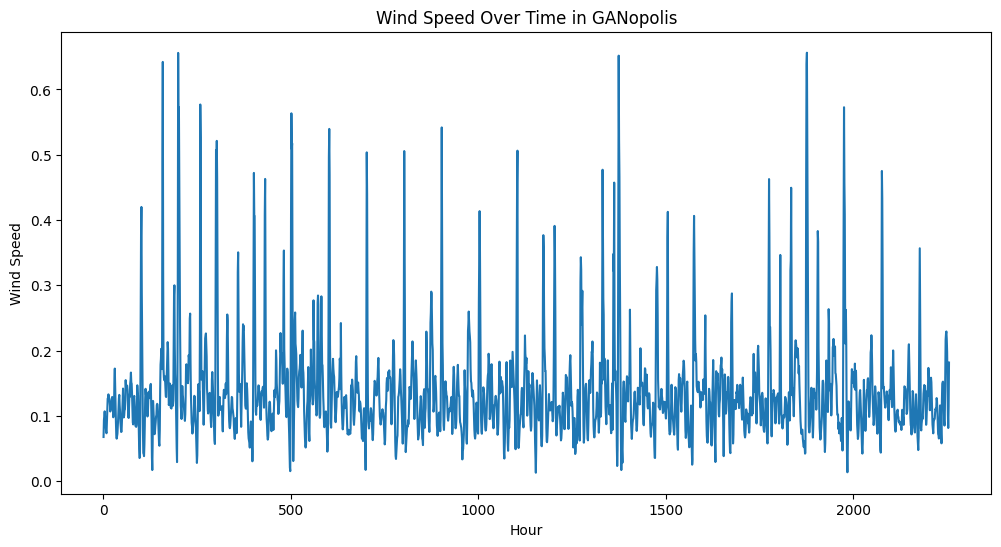

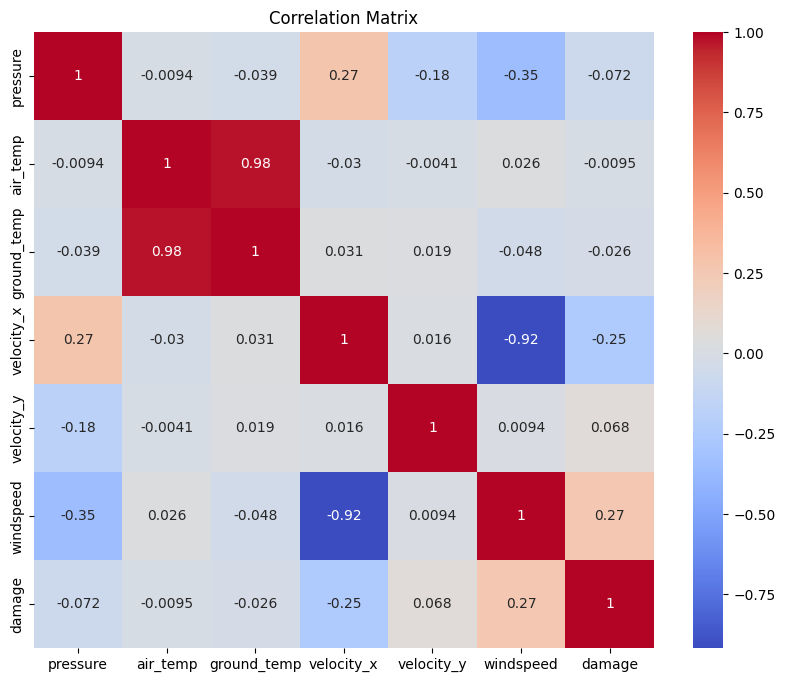

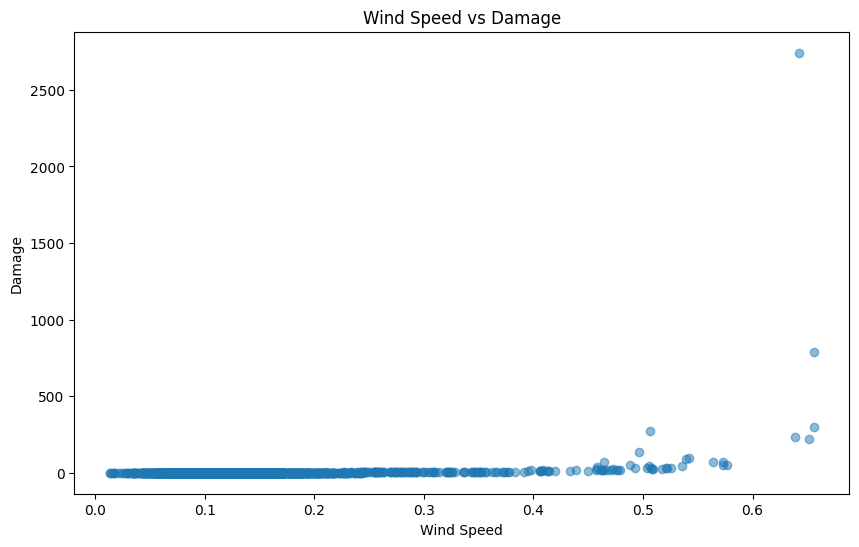

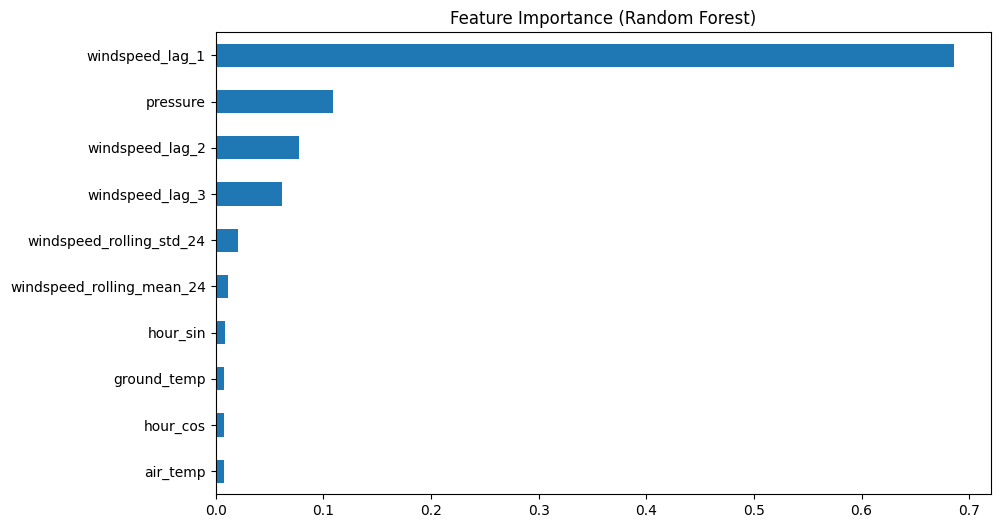

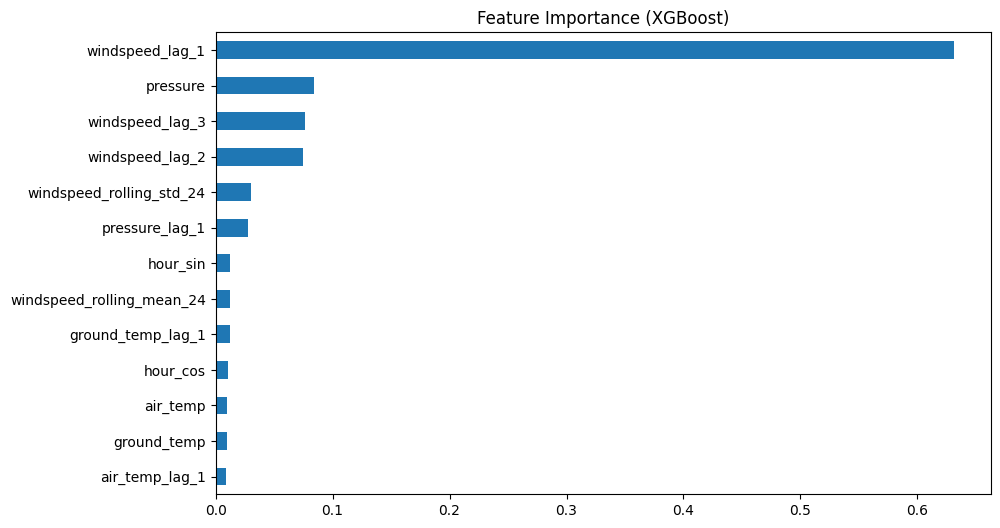

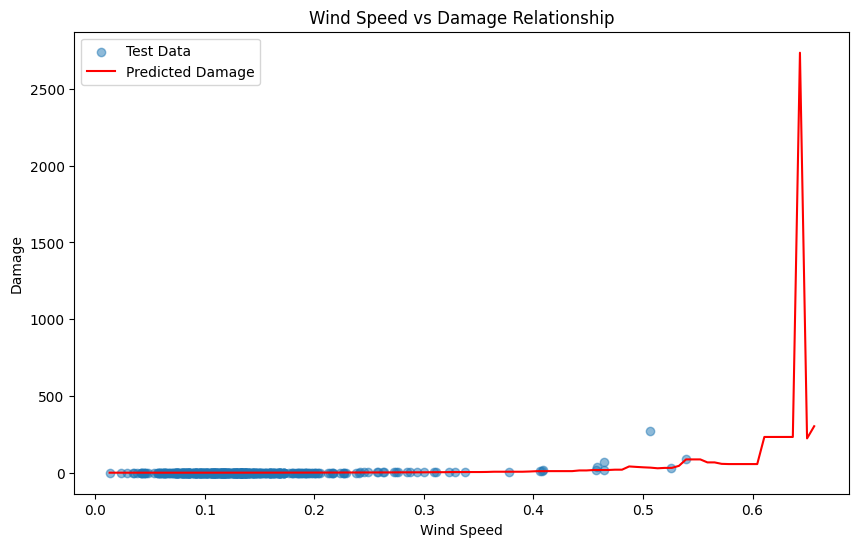

In [19]:
main()

Starting Wind Speed Forecasting and Insurance Pricing
Loading and analyzing training data...
Basic Statistics:
              hour          day  hour_of_day     pressure     air_temp  \
count  2256.000000  2256.000000  2256.000000  2256.000000  2256.000000   
mean   1128.500000    47.500000    11.500000     1.021258    -0.000536   
std     651.395425    27.139943     6.923721     0.305957     0.002896   
min       1.000000     1.000000     0.000000     0.230200    -0.007400   
25%     564.750000    24.000000     5.750000     0.744575    -0.002600   
50%    1128.500000    47.500000    11.500000     1.010400    -0.000700   
75%    1692.250000    71.000000    17.250000     1.297525     0.001400   
max    2256.000000    94.000000    23.000000     1.672900     0.009100   

       ground_temp   velocity_x   velocity_y    windspeed       damage  
count  2256.000000  2256.000000  2256.000000  2256.000000  2256.000000  
mean     -0.000545    -0.127820     0.002469     0.137154     3.288754  
std

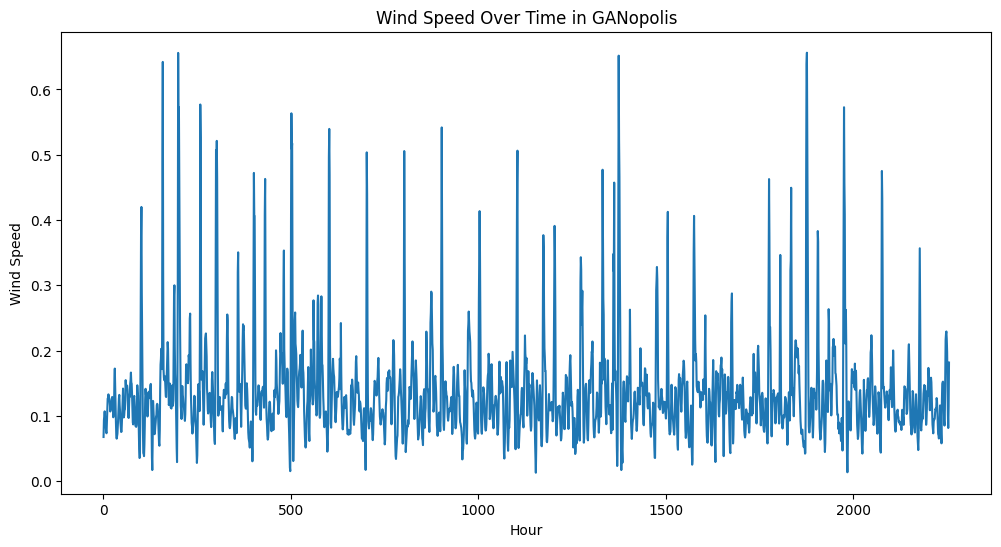

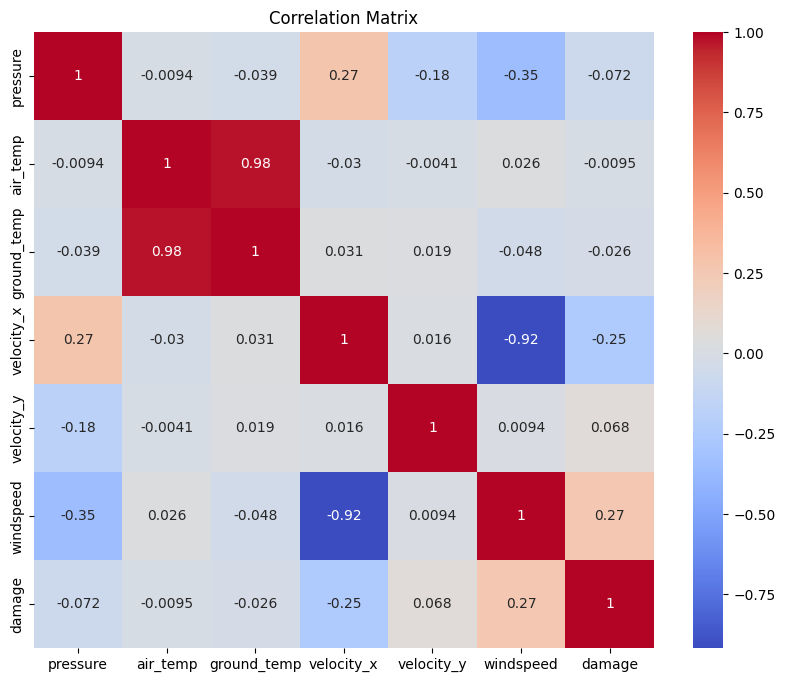

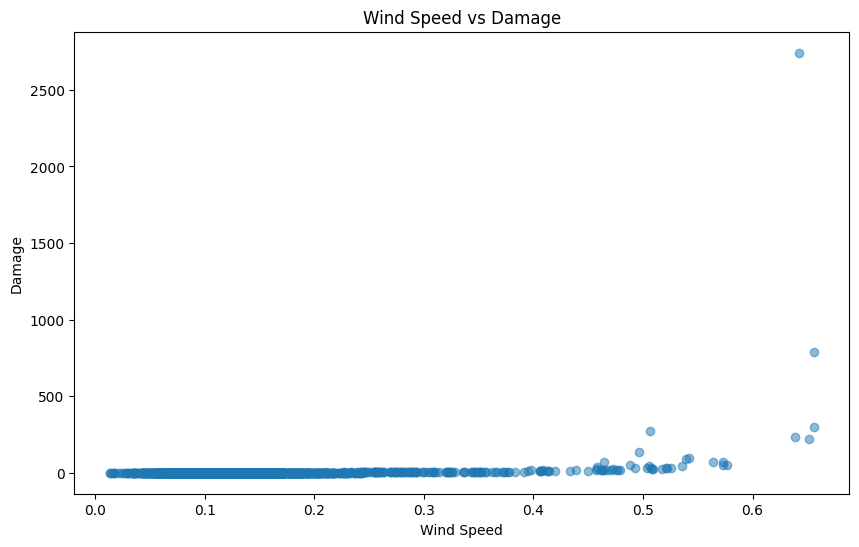

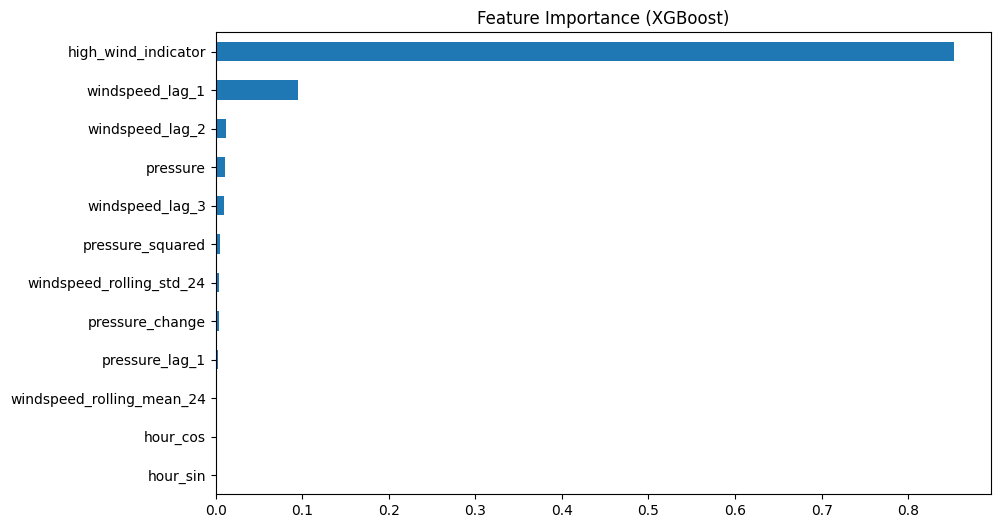

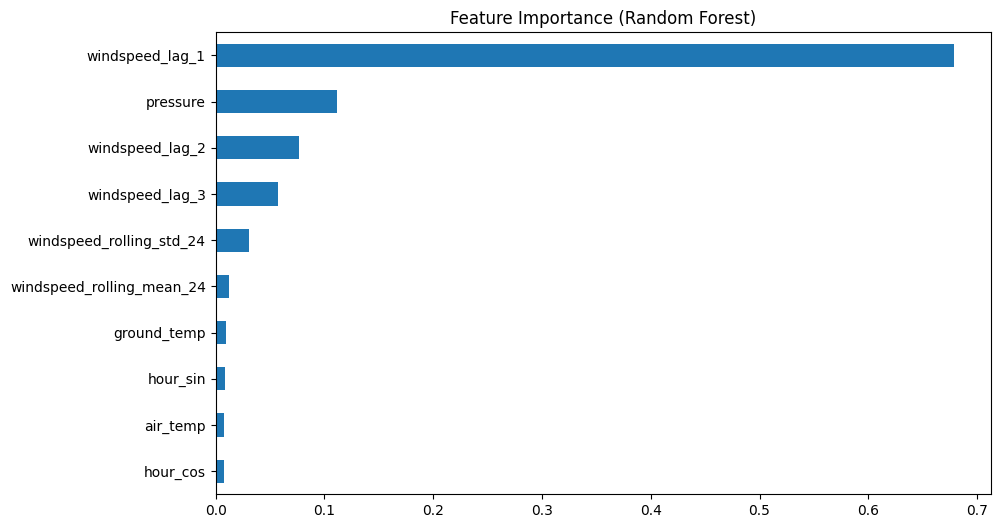

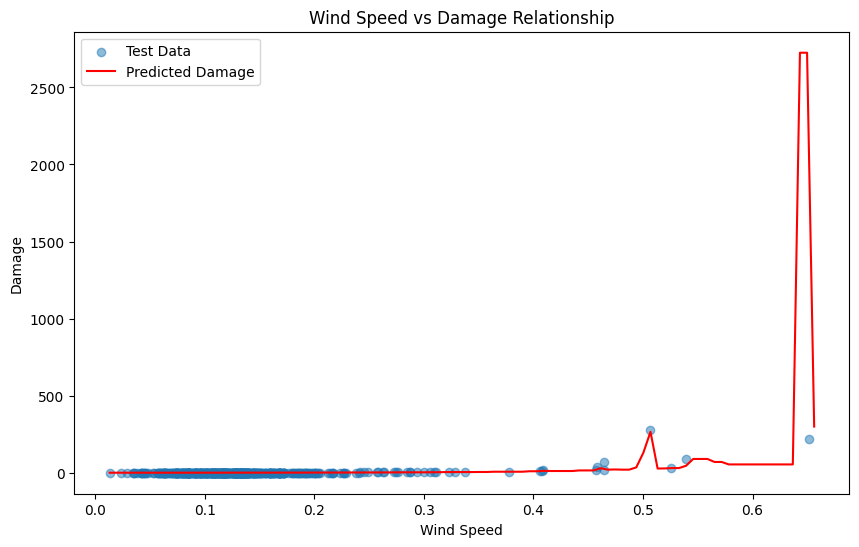

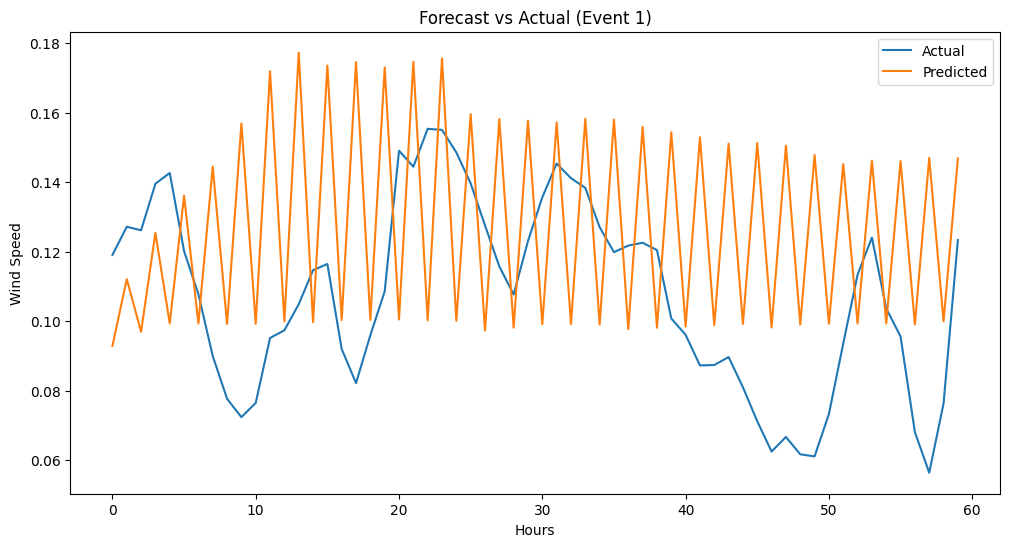

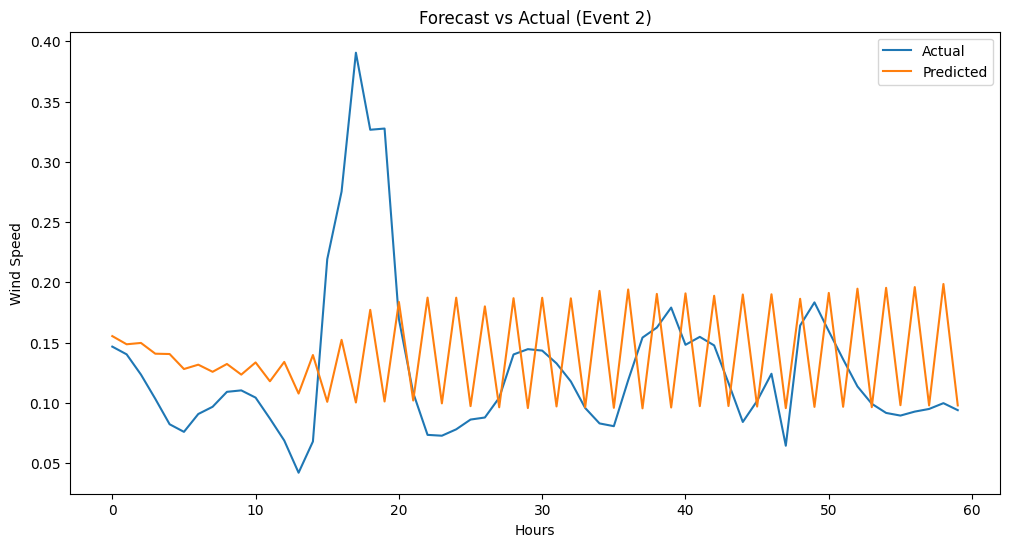

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb
from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings('ignore')

# 1. Data Loading Functions
def load_training_data():
    """Load and prepare the training data for GANopolis"""
    train_data = pd.read_csv('training_data.csv')
    # Filter for GANopolis
    ganopolis_data = train_data[train_data['city'] == 'GANopolis'].copy()
    # Sort by time
    ganopolis_data = ganopolis_data.sort_values(by=['day', 'hour_of_day'])
    ganopolis_data.reset_index(drop=True, inplace=True)
    return ganopolis_data

def load_event_data(event_number):
    """Load data for a specific event"""
    event_data = pd.read_csv(f'event_{event_number}.csv')
    ganopolis_event = event_data[event_data['city'] == 'GANopolis'].copy()
    ganopolis_event = ganopolis_event.sort_values(by=['day', 'hour_of_day'])
    ganopolis_event.reset_index(drop=True, inplace=True)
    return ganopolis_event

# 2. Exploratory Data Analysis
def exploratory_data_analysis(data):
    """Perform exploratory data analysis on the dataset"""
    # Basic statistics
    print("Basic Statistics:")
    print(data.describe())

    # Check for missing values
    print("\nMissing Values:")
    print(data.isnull().sum())

    # Time Series Plot of Wind Speed
    plt.figure(figsize=(12, 6))
    plt.plot(data['hour'], data['windspeed'])
    plt.title('Wind Speed Over Time in GANopolis')
    plt.xlabel('Hour')
    plt.ylabel('Wind Speed')
    plt.savefig('windspeed_timeseries.png')

    # Correlation Matrix
    plt.figure(figsize=(10, 8))
    corr_matrix = data[['pressure', 'air_temp', 'ground_temp', 'velocity_x',
                       'velocity_y', 'windspeed', 'damage']].corr()
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
    plt.title('Correlation Matrix')
    plt.savefig('correlation_matrix.png')

    # Wind Speed vs Damage
    plt.figure(figsize=(10, 6))
    plt.scatter(data['windspeed'], data['damage'], alpha=0.5)
    plt.title('Wind Speed vs Damage')
    plt.xlabel('Wind Speed')
    plt.ylabel('Damage')
    plt.savefig('windspeed_vs_damage.png')

    return corr_matrix

# 3. Feature Engineering
def feature_engineering(data):
    """Create features for time series prediction"""
    # Create a copy to avoid modifying the original
    df = data.copy()

    # Create time-based features
    df['hour_sin'] = np.sin(2 * np.pi * df['hour_of_day'] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour_of_day'] / 24)

    # Create lag features for wind speed
    for lag in [1, 2, 3, 6, 12, 24]:
        df[f'windspeed_lag_{lag}'] = df['windspeed'].shift(lag)

    # Create lag features for other weather variables
    for var in ['pressure', 'air_temp', 'ground_temp']:
        for lag in [1, 6, 24]:
            df[f'{var}_lag_{lag}'] = df[var].shift(lag)

    # Create rolling statistics
    for window in [6, 12, 24]:
        df[f'windspeed_rolling_mean_{window}'] = df['windspeed'].rolling(window=window).mean()
        df[f'windspeed_rolling_std_{window}'] = df['windspeed'].rolling(window=window).std()

    # Create features for high wind events
    df['high_wind_indicator'] = (df['windspeed'] > 0.4).astype(int)
    df['pressure_change'] = df['pressure'].diff()
    df['pressure_squared'] = df['pressure'] ** 2

    # Create threshold-based damage features
    df['wind_above_threshold'] = np.maximum(0, df['windspeed'] - 0.4)
    df['wind_high_impact'] = np.maximum(0, df['windspeed'] - 0.5) ** 2

    # Drop rows with NaN values (from lag features)
    df = df.dropna()

    return df

# 4. Model Building Functions
def build_wind_speed_model(data):
    """Build and train the wind speed prediction model"""
    # Define features based on feature importance analysis
    features = [
        'windspeed_lag_1', 'windspeed_lag_2', 'windspeed_lag_3',
        'pressure', 'pressure_squared', 'pressure_change',
        'pressure_lag_1', 'high_wind_indicator',
        'hour_sin', 'hour_cos',
        'windspeed_rolling_mean_24', 'windspeed_rolling_std_24'
    ]

    # Only include features that exist in the data
    features = [f for f in features if f in data.columns]

    # Train XGBoost model
    model = xgb.XGBRegressor(
        n_estimators=200,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_alpha=0.3,
        random_state=42
    )

    model.fit(data[features], data['windspeed'])

    # Print feature importance
    if len(features) > 0:
        plt.figure(figsize=(10, 6))
        feat_importances = pd.Series(model.feature_importances_, index=features)
        feat_importances.sort_values().plot(kind='barh')
        plt.title('Feature Importance (XGBoost)')
        plt.savefig('xgb_feature_importance.png')

    return model, features

def build_random_forest_model(data):
    """Build and train a Random Forest model as an alternative approach"""
    # Define features
    features = [
        'windspeed_lag_1', 'windspeed_lag_2', 'windspeed_lag_3',
        'pressure', 'hour_sin', 'hour_cos',
        'air_temp', 'ground_temp',
        'windspeed_rolling_mean_24', 'windspeed_rolling_std_24'
    ]

    # Only include features that exist in the data
    features = [f for f in features if f in data.columns]

    # Train Random Forest
    model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
    model.fit(data[features], data['windspeed'])

    # Print feature importance
    if len(features) > 0:
        plt.figure(figsize=(10, 6))
        feat_importances = pd.Series(model.feature_importances_, index=features)
        feat_importances.sort_values().plot(kind='barh')
        plt.title('Feature Importance (Random Forest)')
        plt.savefig('rf_feature_importance.png')

    return model, features

def build_damage_model(data):
    """Build and train the damage prediction model"""
    # Create specialized features for damage prediction
    features = ['windspeed', 'wind_above_threshold', 'wind_high_impact']

    # Make sure all features exist
    for feature in ['wind_above_threshold', 'wind_high_impact']:
        if feature not in data.columns:
            if feature == 'wind_above_threshold':
                data[feature] = np.maximum(0, data['windspeed'] - 0.4)
            elif feature == 'wind_high_impact':
                data[feature] = np.maximum(0, data['windspeed'] - 0.5) ** 2

    # Train XGBoost model for damage prediction
    model = xgb.XGBRegressor(
        n_estimators=200,
        learning_rate=0.05,
        max_depth=5,
        random_state=42
    )

    model.fit(data[features], data['damage'])

    # Visualize the relationship
    plt.figure(figsize=(10, 6))
    wind_range = np.linspace(data['windspeed'].min(), data['windspeed'].max(), 100)
    wind_df = pd.DataFrame({
        'windspeed': wind_range,
        'wind_above_threshold': np.maximum(0, wind_range - 0.4),
        'wind_high_impact': np.maximum(0, wind_range - 0.5) ** 2
    })
    damage_pred = model.predict(wind_df[features])

    # Sample some test data
    X_test = data[features].sample(n=min(500, len(data)), random_state=42)
    y_test = data.loc[X_test.index, 'damage']

    plt.scatter(X_test['windspeed'], y_test, alpha=0.5, label='Test Data')
    plt.plot(wind_range, damage_pred, 'r-', label='Predicted Damage')
    plt.title('Wind Speed vs Damage Relationship')
    plt.xlabel('Wind Speed')
    plt.ylabel('Damage')
    plt.legend()
    plt.savefig('damage_model.png')

    return model, features

# 5. Forecasting Functions
def forecast_wind_speed(initial_data, model, features, hours=120):
    """
    Recursively forecast wind speed using predictions as inputs for next steps
    """
    # Create a copy of the initial data to avoid modifying the original
    forecast_data = initial_data.copy()
    predictions = []

    # Get the latest data point with required features
    latest_data = forecast_data.iloc[-1:].copy()

    # For each hour in the forecast horizon
    for i in range(hours):
        # Ensure all features are available
        for feature in features:
            if feature not in latest_data.columns:
                latest_data[feature] = 0  # Default value

        # Make prediction for next hour
        try:
            pred = model.predict(latest_data[features])[0]
        except:
            # If prediction fails, use the last known wind speed
            print(f"Warning: Prediction failed at hour {i}, using fallback")
            pred = latest_data['windspeed'].values[0] if 'windspeed' in latest_data else 0.1

        predictions.append(pred)

        # Create a new row with the prediction
        new_row = latest_data.copy()
        new_row['hour'] = latest_data['hour'].values[0] + 1
        new_row['hour_of_day'] = (latest_data['hour_of_day'].values[0] + 1) % 24
        new_row['day'] = latest_data['day'].values[0] + (1 if new_row['hour_of_day'].values[0] == 0 else 0)
        new_row['windspeed'] = pred

        # Update lag features
        if 'windspeed_lag_1' in features:
            new_row['windspeed_lag_1'] = latest_data['windspeed'].values[0]
        if 'windspeed_lag_2' in features and 'windspeed_lag_1' in latest_data:
            new_row['windspeed_lag_2'] = latest_data['windspeed_lag_1'].values[0]
        if 'windspeed_lag_3' in features and 'windspeed_lag_2' in latest_data:
            new_row['windspeed_lag_3'] = latest_data['windspeed_lag_2'].values[0]

        # Update time-based features
        if 'hour_sin' in features:
            new_row['hour_sin'] = np.sin(2 * np.pi * new_row['hour_of_day'].values[0] / 24)
        if 'hour_cos' in features:
            new_row['hour_cos'] = np.cos(2 * np.pi * new_row['hour_of_day'].values[0] / 24)

        # Update other features
        if 'high_wind_indicator' in features:
            new_row['high_wind_indicator'] = 1 if pred > 0.4 else 0

        if 'wind_above_threshold' in features:
            new_row['wind_above_threshold'] = max(0, pred - 0.4)

        if 'wind_high_impact' in features:
            new_row['wind_high_impact'] = max(0, pred - 0.5) ** 2

        # Update rolling statistics (simplified approach)
        if 'windspeed_rolling_mean_24' in features:
            if i < 24:
                # For the first 24 hours, use the actual mean from the latest data
                new_row['windspeed_rolling_mean_24'] = latest_data['windspeed_rolling_mean_24'].values[0]
            else:
                # After 24 hours, use the mean of the last 24 predictions
                new_row['windspeed_rolling_mean_24'] = np.mean(predictions[-24:])

        if 'windspeed_rolling_std_24' in features:
            if i < 24:
                # For the first 24 hours, use the actual std from the latest data
                new_row['windspeed_rolling_std_24'] = latest_data['windspeed_rolling_std_24'].values[0]
            else:
                # After 24 hours, use the std of the last 24 predictions
                new_row['windspeed_rolling_std_24'] = np.std(predictions[-24:])

        # Update latest data for next iteration
        latest_data = new_row

    return np.array(predictions)

def ensemble_forecast(initial_data, models_and_features, hours=120):
    """
    Generate an ensemble forecast using multiple models
    """
    all_predictions = []

    for model, features in models_and_features:
        predictions = forecast_wind_speed(initial_data, model, features, hours)
        all_predictions.append(predictions)

    # Average the predictions from all models
    ensemble_predictions = np.mean(all_predictions, axis=0)

    return ensemble_predictions

# 6. Pricing Functions
def optimize_price_with_risk(predicted_wind_speeds, damage_model, damage_features):
    """
    Determine optimal price with risk considerations
    """
    # Calculate expected damages for the next 120 hours
    damage_inputs = pd.DataFrame({
        'windspeed': predicted_wind_speeds,
        'wind_above_threshold': np.maximum(0, predicted_wind_speeds - 0.4),
        'wind_high_impact': np.maximum(0, predicted_wind_speeds - 0.5) ** 2
    })

    expected_damages = damage_model.predict(damage_inputs[damage_features])
    total_damage = np.sum(expected_damages)

    # Risk premium increases with the probability of high wind events
    high_wind_probability = np.mean(predicted_wind_speeds > 0.5)
    extreme_wind_probability = np.mean(predicted_wind_speeds > 0.6)

    # Base price from example code
    base_price = 250 + total_damage / 2

    # Add risk premium
    risk_premium = 100 * high_wind_probability + 500 * extreme_wind_probability

    optimal_price = base_price + risk_premium

    return optimal_price, total_damage

# 7. Model Validation Functions
def time_series_validation(data, model, features):
    """
    Perform time series cross-validation
    """
    tscv = TimeSeriesSplit(n_splits=5)
    errors = []

    X = data[features]
    y = data['windspeed']

    for train_idx, test_idx in tscv.split(X):
        # Split the data
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        # Train the model
        model.fit(X_train, y_train)

        # Make predictions
        y_pred = model.predict(X_test)

        # Calculate error
        mse = mean_squared_error(y_test, y_pred)
        errors.append(mse)

    return np.mean(errors), np.std(errors)

def validate_on_events(wind_model, wind_features, damage_model, damage_features, event_numbers=[1, 2]):
    """
    Validate models on specified event data
    """
    all_results = []

    for event_num in event_numbers:
        # Load and prepare event data
        event_data = load_event_data(event_num)

        # Split into first half (known) and second half (to predict)
        split_point = len(event_data) // 2
        first_half = event_data.iloc[:split_point]
        second_half = event_data.iloc[split_point:]  # All remaining data

        # Apply feature engineering
        processed_data = feature_engineering(first_half)

        # Calculate how many hours we can predict (limited by available data)
        hours_to_predict = min(120, len(second_half))

        # Predict wind speeds
        predicted_winds = forecast_wind_speed(processed_data, wind_model, wind_features, hours=hours_to_predict)

        # Calculate wind speed error
        actual_winds = second_half['windspeed'].values[:hours_to_predict]
        wind_mse = mean_squared_error(actual_winds, predicted_winds)

        # Predict damages (using only the predicted period)
        damage_inputs = pd.DataFrame({
            'windspeed': predicted_winds,
            'wind_above_threshold': np.maximum(0, predicted_winds - 0.4),
            'wind_high_impact': np.maximum(0, predicted_winds - 0.5) ** 2
        })

        predicted_damages = damage_model.predict(damage_inputs[damage_features])
        total_predicted_damage = np.sum(predicted_damages)

        # Calculate actual damages (for the same period)
        actual_damage_inputs = pd.DataFrame({
            'windspeed': actual_winds,
            'wind_above_threshold': np.maximum(0, actual_winds - 0.4),
            'wind_high_impact': np.maximum(0, actual_winds - 0.5) ** 2
        })

        actual_damages = damage_model.predict(actual_damage_inputs[damage_features])
        total_actual_damage = np.sum(actual_damages)

        # Set price based on predictions
        price, _ = optimize_price_with_risk(predicted_winds, damage_model, damage_features)

        # Calculate profit
        profit = price - total_actual_damage

        all_results.append({
            'event': event_num,
            'wind_mse': wind_mse,
            'predicted_total_damage': total_predicted_damage,
            'actual_total_damage': total_actual_damage,
            'price': price,
            'profit': profit
        })

        # Visualize forecast
        plt.figure(figsize=(12, 6))
        plt.plot(actual_winds, label='Actual')
        plt.plot(predicted_winds, label='Predicted')
        plt.title(f'Forecast vs Actual (Event {event_num})')
        plt.legend()
        plt.xlabel('Hours')
        plt.ylabel('Wind Speed')
        plt.savefig(f'forecast_event_{event_num}.png')

    return all_results

# 8. Processing and Submission Functions
def process_event(event_number, wind_model, wind_features, damage_model, damage_features):
    """
    Process an event and generate predictions and pricing
    """
    # Load and prepare event data
    event_data = load_event_data(event_number)

    # Apply feature engineering
    processed_data = feature_engineering(event_data)

    # Make sure we have sufficient data after feature engineering
    if len(processed_data) < 5:  # Need some minimum data for features
        print(f"Warning: Not enough processed data for event {event_number}. Using fallback approach.")
        # Simple fallback: use mean values from the training data
        predicted_wind_speeds = np.array([0.12] * 120)  # Average wind speed
    else:
        # Predict wind speeds for the next 120 hours
        predicted_wind_speeds = forecast_wind_speed(processed_data, wind_model, wind_features, hours=120)

    # Set the price
    optimal_price, total_damage = optimize_price_with_risk(predicted_wind_speeds, damage_model, damage_features)

    return {
        'event_number': event_number,
        'price': optimal_price,
        'predicted_wind_speeds': predicted_wind_speeds,
        'total_damage': total_damage
    }

def create_submission(results):
    """
    Create the submission file
    """
    # Initialize submission dataframe
    submission_data = []

    for result in results:
        event_dict = {
            'event_number': result['event_number'],
            'price': result['price']
        }

        # Add wind speed predictions
        for i, wind_speed in enumerate(result['predicted_wind_speeds']):
            event_dict[str(i)] = wind_speed

        submission_data.append(pd.DataFrame([event_dict]))

    submission_df = pd.concat(submission_data, ignore_index=True)
    submission_df.to_csv('submission2.csv', index=False)
    print("Submission file created successfully!")

# 9. Main Function
def main():
    print("Starting Wind Speed Forecasting and Insurance Pricing")

    # Load and analyze training data
    print("Loading and analyzing training data...")
    gan_data = load_training_data()
    exploratory_data_analysis(gan_data)

    # Feature engineering
    print("Performing feature engineering...")
    processed_data = feature_engineering(gan_data)

    # Train wind speed models
    print("Training wind speed prediction models...")
    xgb_model, xgb_features = build_wind_speed_model(processed_data)
    rf_model, rf_features = build_random_forest_model(processed_data)

    # Train damage model
    print("Training damage prediction model...")
    damage_model, damage_features = build_damage_model(gan_data)

    # Validate models on a couple of events
    print("Validating models on sample events...")
    validation_results = validate_on_events(
        xgb_model, xgb_features,
        damage_model, damage_features,
        event_numbers=[1, 2]
    )

    # Display validation results
    print("\nValidation Results:")
    for result in validation_results:
        print(f"Event {result['event']}:")
        print(f"  Wind Speed MSE: {result['wind_mse']:.6f}")
        print(f"  Predicted Total Damage: {result['predicted_total_damage']:.2f}")
        print(f"  Actual Total Damage: {result['actual_total_damage']:.2f}")
        print(f"  Price: ${result['price']:.2f}")
        print(f"  Profit: ${result['profit']:.2f}")

    # Generate ensemble model
    models_and_features = [
        (xgb_model, xgb_features),
        (rf_model, rf_features)
    ]

    # Process all events and create predictions
    print("\nProcessing all events and generating predictions...")
    results = []
    for event_num in range(1, 11):
        # Use ensemble forecasting
        event_data = load_event_data(event_num)
        processed_event = feature_engineering(event_data)

        # Make sure we have sufficient data after feature engineering
        if len(processed_event) < 5:  # Need some minimum data for features
            print(f"Warning: Not enough processed data for event {event_num}. Using fallback approach.")
            # Simple fallback: use mean values from the training data
            predicted_winds = np.array([0.12] * 120)  # Average wind speed
        else:
            # Get ensemble predictions
            predicted_winds = ensemble_forecast(processed_event, models_and_features, hours=120)

        # Set price
        price, total_damage = optimize_price_with_risk(predicted_winds, damage_model, damage_features)

        results.append({
            'event_number': event_num,
            'price': price,
            'predicted_wind_speeds': predicted_winds,
            'total_damage': total_damage
        })

        print(f"Event {event_num}: Price = ${price:.2f}, Estimated Damage = ${total_damage:.2f}")

    # Create submission file
    print("\nCreating submission file...")
    create_submission(results)

    print("\nProcess completed successfully!")

if __name__ == "__main__":
    main()

Starting Wind Speed Forecasting and Insurance Pricing
Loading and analyzing training data...
Basic Statistics:
              hour          day  hour_of_day     pressure     air_temp  \
count  2256.000000  2256.000000  2256.000000  2256.000000  2256.000000   
mean   1128.500000    47.500000    11.500000     1.021258    -0.000536   
std     651.395425    27.139943     6.923721     0.305957     0.002896   
min       1.000000     1.000000     0.000000     0.230200    -0.007400   
25%     564.750000    24.000000     5.750000     0.744575    -0.002600   
50%    1128.500000    47.500000    11.500000     1.010400    -0.000700   
75%    1692.250000    71.000000    17.250000     1.297525     0.001400   
max    2256.000000    94.000000    23.000000     1.672900     0.009100   

       ground_temp   velocity_x   velocity_y    windspeed       damage  
count  2256.000000  2256.000000  2256.000000  2256.000000  2256.000000  
mean     -0.000545    -0.127820     0.002469     0.137154     3.288754  
std

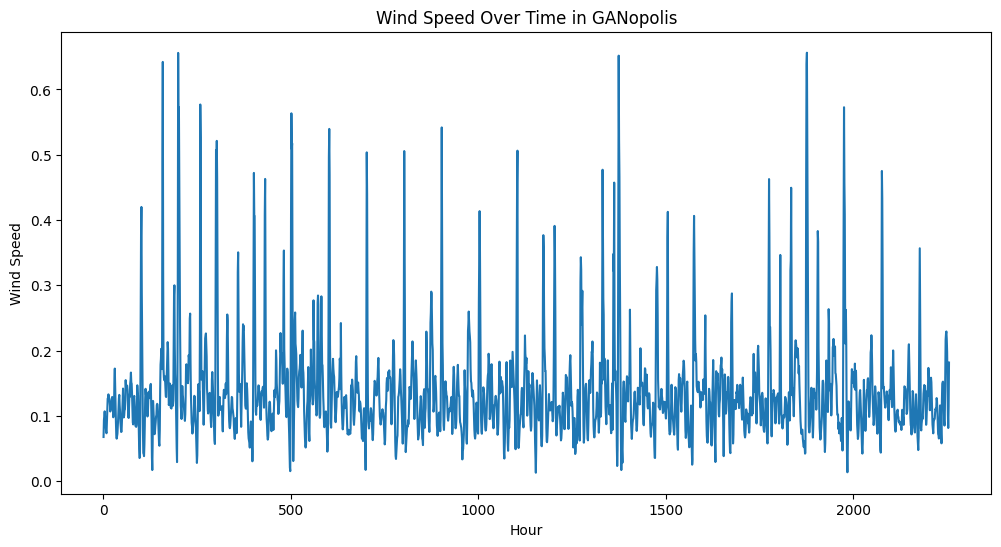

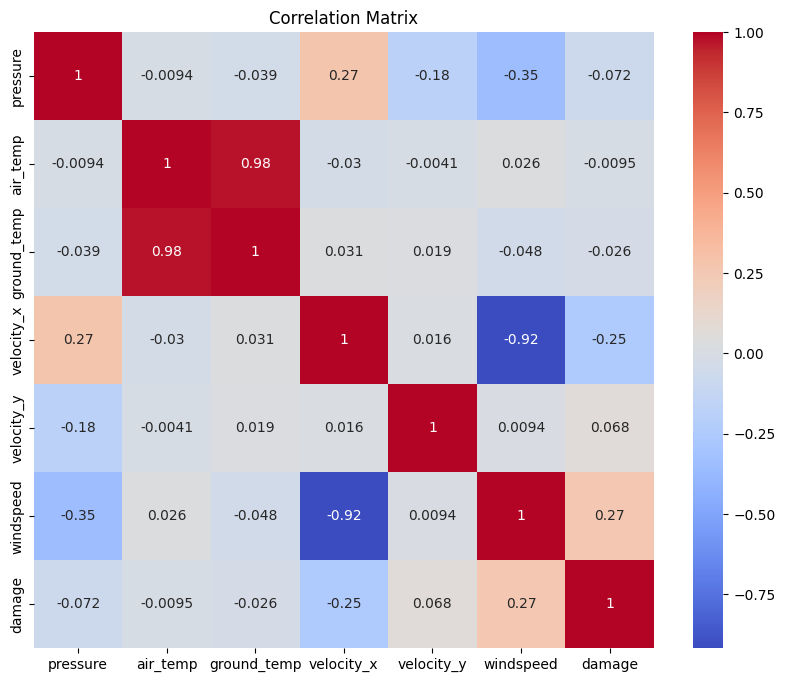

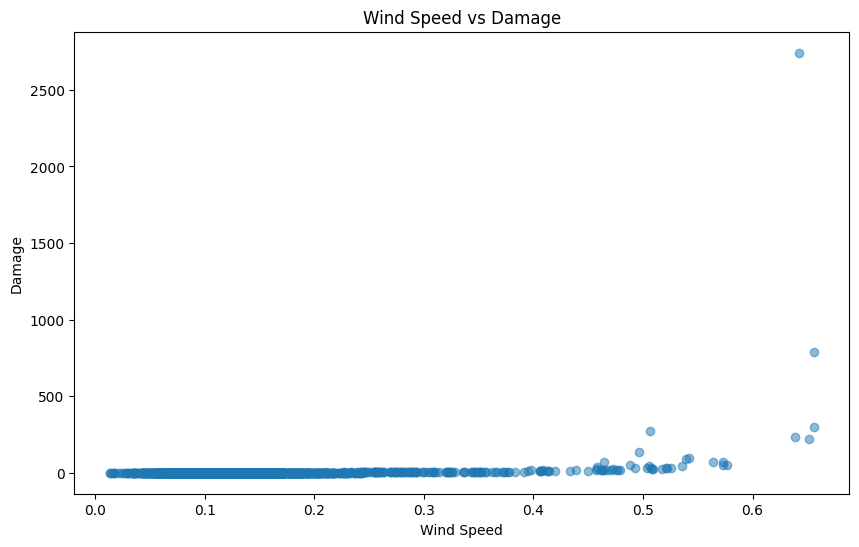

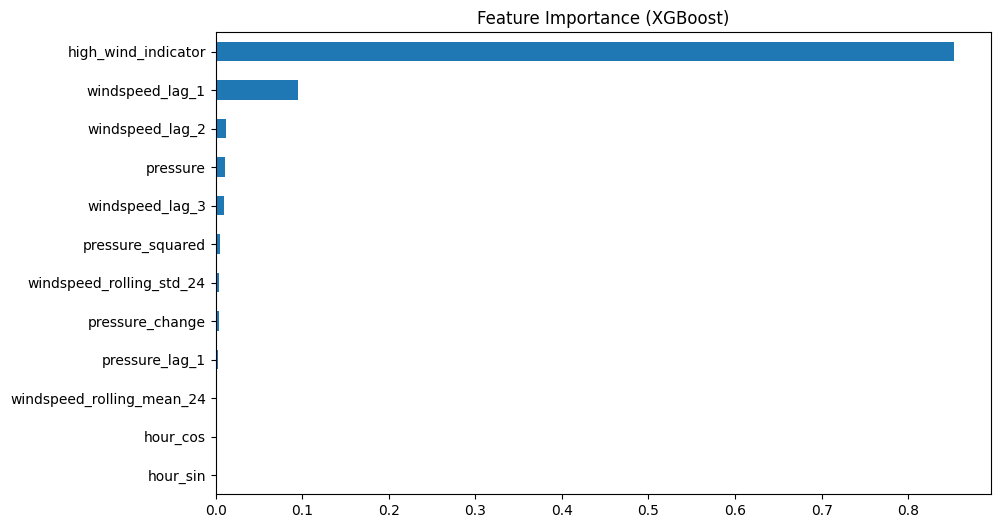

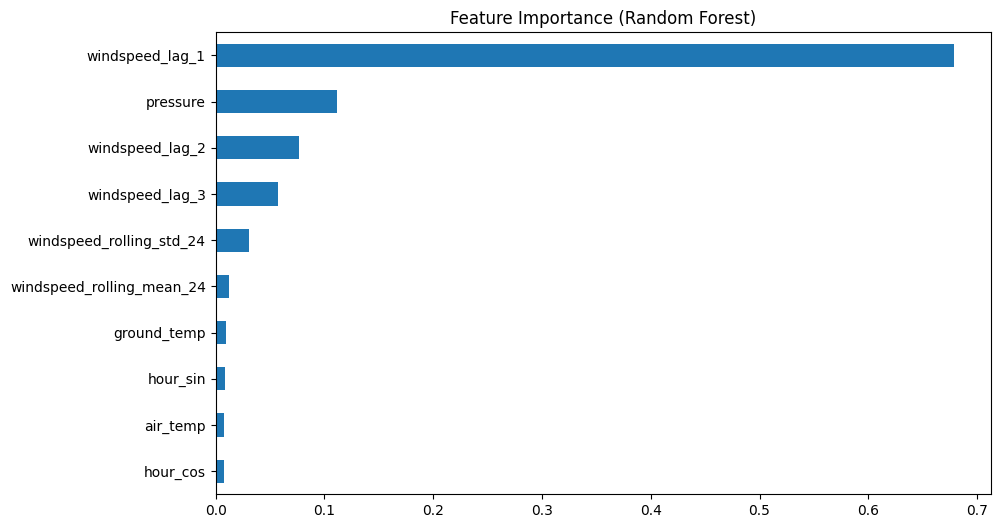

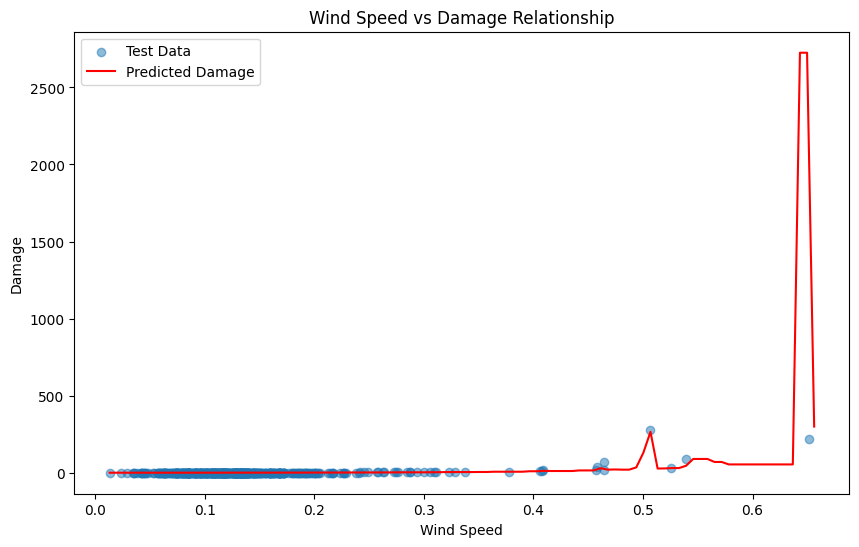

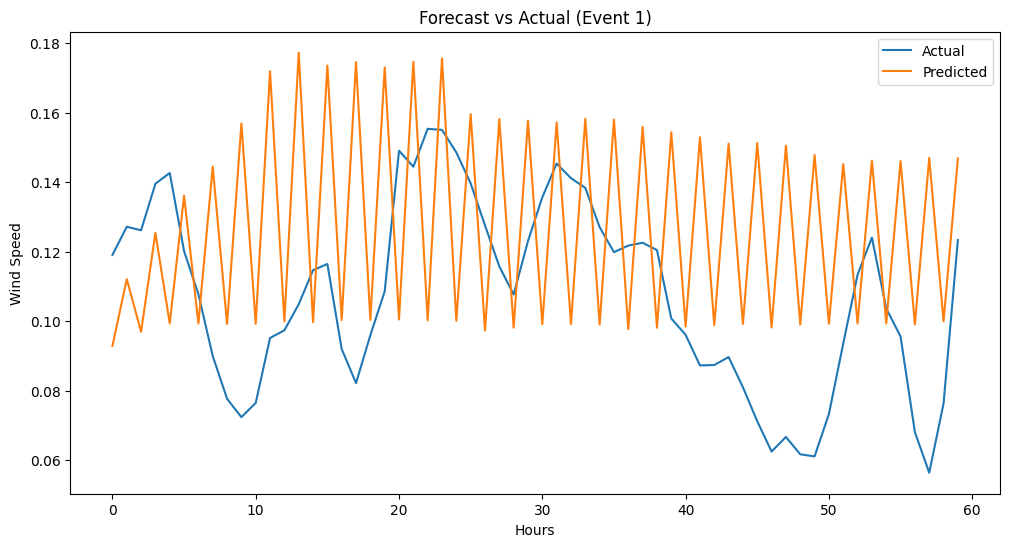

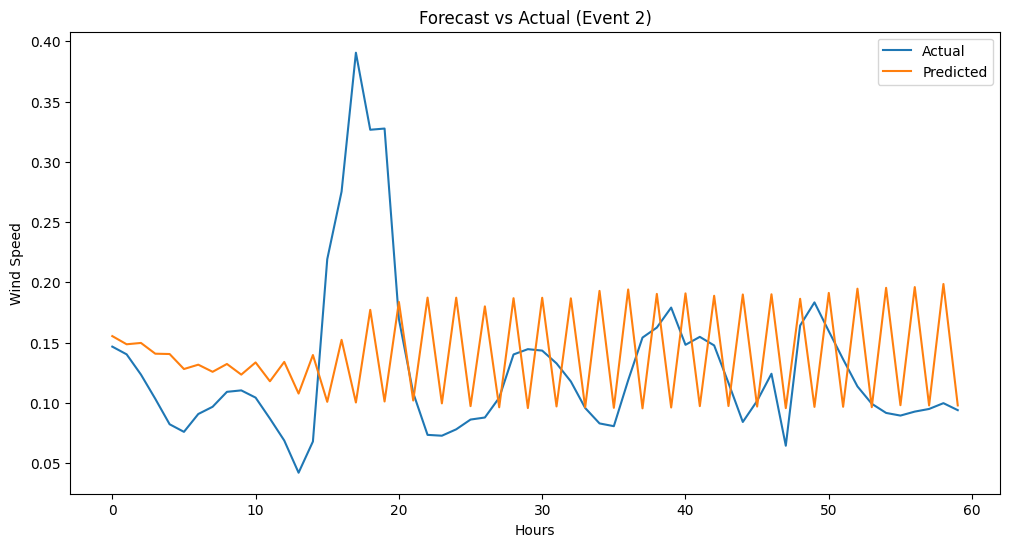

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb
from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings('ignore')

# 1. Data Loading Functions
def load_training_data():
    """Load and prepare the training data for GANopolis"""
    train_data = pd.read_csv('training_data.csv')
    # Filter for GANopolis
    ganopolis_data = train_data[train_data['city'] == 'GANopolis'].copy()
    # Sort by time
    ganopolis_data = ganopolis_data.sort_values(by=['day', 'hour_of_day'])
    ganopolis_data.reset_index(drop=True, inplace=True)
    return ganopolis_data

def load_event_data(event_number):
    """Load data for a specific event"""
    event_data = pd.read_csv(f'event_{event_number}.csv')
    ganopolis_event = event_data[event_data['city'] == 'GANopolis'].copy()
    ganopolis_event = ganopolis_event.sort_values(by=['day', 'hour_of_day'])
    ganopolis_event.reset_index(drop=True, inplace=True)
    return ganopolis_event

# 2. Exploratory Data Analysis
def exploratory_data_analysis(data):
    """Perform exploratory data analysis on the dataset"""
    # Basic statistics
    print("Basic Statistics:")
    print(data.describe())

    # Check for missing values
    print("\nMissing Values:")
    print(data.isnull().sum())

    # Time Series Plot of Wind Speed
    plt.figure(figsize=(12, 6))
    plt.plot(data['hour'], data['windspeed'])
    plt.title('Wind Speed Over Time in GANopolis')
    plt.xlabel('Hour')
    plt.ylabel('Wind Speed')
    plt.savefig('windspeed_timeseries.png')

    # Correlation Matrix
    plt.figure(figsize=(10, 8))
    corr_matrix = data[['pressure', 'air_temp', 'ground_temp', 'velocity_x',
                       'velocity_y', 'windspeed', 'damage']].corr()
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
    plt.title('Correlation Matrix')
    plt.savefig('correlation_matrix.png')

    # Wind Speed vs Damage
    plt.figure(figsize=(10, 6))
    plt.scatter(data['windspeed'], data['damage'], alpha=0.5)
    plt.title('Wind Speed vs Damage')
    plt.xlabel('Wind Speed')
    plt.ylabel('Damage')
    plt.savefig('windspeed_vs_damage.png')

    return corr_matrix

# 3. Feature Engineering
def feature_engineering(data):
    """Create features for time series prediction"""
    # Create a copy to avoid modifying the original
    df = data.copy()

    # Create time-based features
    df['hour_sin'] = np.sin(2 * np.pi * df['hour_of_day'] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour_of_day'] / 24)

    # Create lag features for wind speed
    for lag in [1, 2, 3, 6, 12, 24]:
        df[f'windspeed_lag_{lag}'] = df['windspeed'].shift(lag)

    # Create lag features for other weather variables
    for var in ['pressure', 'air_temp', 'ground_temp']:
        for lag in [1, 6, 24]:
            df[f'{var}_lag_{lag}'] = df[var].shift(lag)

    # Create rolling statistics
    for window in [6, 12, 24]:
        df[f'windspeed_rolling_mean_{window}'] = df['windspeed'].rolling(window=window).mean()
        df[f'windspeed_rolling_std_{window}'] = df['windspeed'].rolling(window=window).std()

    # Create features for high wind events
    df['high_wind_indicator'] = (df['windspeed'] > 0.4).astype(int)
    df['pressure_change'] = df['pressure'].diff()
    df['pressure_squared'] = df['pressure'] ** 2

    # Create threshold-based damage features
    df['wind_above_threshold'] = np.maximum(0, df['windspeed'] - 0.4)
    df['wind_high_impact'] = np.maximum(0, df['windspeed'] - 0.5) ** 2

    # Drop rows with NaN values (from lag features)
    df = df.dropna()

    return df

# 4. Model Building Functions
def build_wind_speed_model(data):
    """Build and train the wind speed prediction model"""
    # Define features based on feature importance analysis
    features = [
        'windspeed_lag_1', 'windspeed_lag_2', 'windspeed_lag_3',
        'pressure', 'pressure_squared', 'pressure_change',
        'pressure_lag_1', 'high_wind_indicator',
        'hour_sin', 'hour_cos',
        'windspeed_rolling_mean_24', 'windspeed_rolling_std_24'
    ]

    # Only include features that exist in the data
    features = [f for f in features if f in data.columns]

    # Train XGBoost model
    model = xgb.XGBRegressor(
        n_estimators=200,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_alpha=0.3,
        random_state=42
    )

    model.fit(data[features], data['windspeed'])

    # Print feature importance
    if len(features) > 0:
        plt.figure(figsize=(10, 6))
        feat_importances = pd.Series(model.feature_importances_, index=features)
        feat_importances.sort_values().plot(kind='barh')
        plt.title('Feature Importance (XGBoost)')
        plt.savefig('xgb_feature_importance.png')

    return model, features

def build_random_forest_model(data):
    """Build and train a Random Forest model as an alternative approach"""
    # Define features
    features = [
        'windspeed_lag_1', 'windspeed_lag_2', 'windspeed_lag_3',
        'pressure', 'hour_sin', 'hour_cos',
        'air_temp', 'ground_temp',
        'windspeed_rolling_mean_24', 'windspeed_rolling_std_24'
    ]

    # Only include features that exist in the data
    features = [f for f in features if f in data.columns]

    # Train Random Forest
    model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
    model.fit(data[features], data['windspeed'])

    # Print feature importance
    if len(features) > 0:
        plt.figure(figsize=(10, 6))
        feat_importances = pd.Series(model.feature_importances_, index=features)
        feat_importances.sort_values().plot(kind='barh')
        plt.title('Feature Importance (Random Forest)')
        plt.savefig('rf_feature_importance.png')

    return model, features

def build_damage_model(data):
    """Build and train the damage prediction model"""
    # Create specialized features for damage prediction
    features = ['windspeed', 'wind_above_threshold', 'wind_high_impact']

    # Make sure all features exist
    for feature in ['wind_above_threshold', 'wind_high_impact']:
        if feature not in data.columns:
            if feature == 'wind_above_threshold':
                data[feature] = np.maximum(0, data['windspeed'] - 0.4)
            elif feature == 'wind_high_impact':
                data[feature] = np.maximum(0, data['windspeed'] - 0.5) ** 2

    # Train XGBoost model for damage prediction
    model = xgb.XGBRegressor(
        n_estimators=200,
        learning_rate=0.05,
        max_depth=5,
        random_state=42
    )

    model.fit(data[features], data['damage'])

    # Visualize the relationship
    plt.figure(figsize=(10, 6))
    wind_range = np.linspace(data['windspeed'].min(), data['windspeed'].max(), 100)
    wind_df = pd.DataFrame({
        'windspeed': wind_range,
        'wind_above_threshold': np.maximum(0, wind_range - 0.4),
        'wind_high_impact': np.maximum(0, wind_range - 0.5) ** 2
    })
    damage_pred = model.predict(wind_df[features])

    # Sample some test data
    X_test = data[features].sample(n=min(500, len(data)), random_state=42)
    y_test = data.loc[X_test.index, 'damage']

    plt.scatter(X_test['windspeed'], y_test, alpha=0.5, label='Test Data')
    plt.plot(wind_range, damage_pred, 'r-', label='Predicted Damage')
    plt.title('Wind Speed vs Damage Relationship')
    plt.xlabel('Wind Speed')
    plt.ylabel('Damage')
    plt.legend()
    plt.savefig('damage_model.png')

    return model, features

# 5. Forecasting Functions
def forecast_wind_speed(initial_data, model, features, hours=120):
    """
    Recursively forecast wind speed using predictions as inputs for next steps
    """
    # Create a copy of the initial data to avoid modifying the original
    forecast_data = initial_data.copy()
    predictions = []

    # Get the latest data point with required features
    latest_data = forecast_data.iloc[-1:].copy()

    # For each hour in the forecast horizon
    for i in range(hours):
        # Ensure all features are available
        for feature in features:
            if feature not in latest_data.columns:
                latest_data[feature] = 0  # Default value

        # Make prediction for next hour
        try:
            pred = model.predict(latest_data[features])[0]
        except:
            # If prediction fails, use the last known wind speed
            print(f"Warning: Prediction failed at hour {i}, using fallback")
            pred = latest_data['windspeed'].values[0] if 'windspeed' in latest_data else 0.1

        predictions.append(pred)

        # Create a new row with the prediction
        new_row = latest_data.copy()
        new_row['hour'] = latest_data['hour'].values[0] + 1
        new_row['hour_of_day'] = (latest_data['hour_of_day'].values[0] + 1) % 24
        new_row['day'] = latest_data['day'].values[0] + (1 if new_row['hour_of_day'].values[0] == 0 else 0)
        new_row['windspeed'] = pred

        # Update lag features
        if 'windspeed_lag_1' in features:
            new_row['windspeed_lag_1'] = latest_data['windspeed'].values[0]
        if 'windspeed_lag_2' in features and 'windspeed_lag_1' in latest_data:
            new_row['windspeed_lag_2'] = latest_data['windspeed_lag_1'].values[0]
        if 'windspeed_lag_3' in features and 'windspeed_lag_2' in latest_data:
            new_row['windspeed_lag_3'] = latest_data['windspeed_lag_2'].values[0]

        # Update time-based features
        if 'hour_sin' in features:
            new_row['hour_sin'] = np.sin(2 * np.pi * new_row['hour_of_day'].values[0] / 24)
        if 'hour_cos' in features:
            new_row['hour_cos'] = np.cos(2 * np.pi * new_row['hour_of_day'].values[0] / 24)

        # Update other features
        if 'high_wind_indicator' in features:
            new_row['high_wind_indicator'] = 1 if pred > 0.4 else 0

        if 'wind_above_threshold' in features:
            new_row['wind_above_threshold'] = max(0, pred - 0.4)

        if 'wind_high_impact' in features:
            new_row['wind_high_impact'] = max(0, pred - 0.5) ** 2

        # Update rolling statistics (simplified approach)
        if 'windspeed_rolling_mean_24' in features:
            if i < 24:
                # For the first 24 hours, use the actual mean from the latest data
                new_row['windspeed_rolling_mean_24'] = latest_data['windspeed_rolling_mean_24'].values[0]
            else:
                # After 24 hours, use the mean of the last 24 predictions
                new_row['windspeed_rolling_mean_24'] = np.mean(predictions[-24:])

        if 'windspeed_rolling_std_24' in features:
            if i < 24:
                # For the first 24 hours, use the actual std from the latest data
                new_row['windspeed_rolling_std_24'] = latest_data['windspeed_rolling_std_24'].values[0]
            else:
                # After 24 hours, use the std of the last 24 predictions
                new_row['windspeed_rolling_std_24'] = np.std(predictions[-24:])

        # Update latest data for next iteration
        latest_data = new_row

    return np.array(predictions)

def ensemble_forecast(initial_data, models_and_features, hours=120):
    """
    Generate an ensemble forecast using multiple models
    """
    all_predictions = []

    for model, features in models_and_features:
        predictions = forecast_wind_speed(initial_data, model, features, hours)
        all_predictions.append(predictions)

    # Average the predictions from all models
    ensemble_predictions = np.mean(all_predictions, axis=0)

    return ensemble_predictions

# 6. Pricing Functions
def optimize_price_with_demand(predicted_wind_speeds, damage_model, damage_features):
    """
    Determine optimal price based on the demand curve formula

    demand = (10000 - (10000/500)*price) = (10000 - 20*price)
    unit_contribution_margin = (price - damage)
    profit = (demand)(unit_contribution_margin)
    """
    # Calculate expected damages for the next 120 hours
    damage_inputs = pd.DataFrame({
        'windspeed': predicted_wind_speeds,
        'wind_above_threshold': np.maximum(0, predicted_wind_speeds - 0.4),
        'wind_high_impact': np.maximum(0, predicted_wind_speeds - 0.5) ** 2
    })

    expected_damages = damage_model.predict(damage_inputs[damage_features])
    total_damage = np.sum(expected_damages)

    # Risk premium increases with the probability of high wind events
    high_wind_probability = np.mean(predicted_wind_speeds > 0.5)
    extreme_wind_probability = np.mean(predicted_wind_speeds > 0.6)

    # Calculate risk-adjusted damage
    risk_adjusted_damage = total_damage * (1 + 0.2*high_wind_probability + 0.5*extreme_wind_probability)

    # Optimal price from the derivative of the profit function
    optimal_price = 250 + risk_adjusted_damage / 2

    # Calculate expected profit at optimal price
    demand = 10000 - 20 * optimal_price
    unit_margin = optimal_price - total_damage
    expected_profit = demand * unit_margin

    return optimal_price, total_damage, expected_profit

# 7. Model Validation Functions
def time_series_validation(data, model, features):
    """
    Perform time series cross-validation
    """
    tscv = TimeSeriesSplit(n_splits=5)
    errors = []

    X = data[features]
    y = data['windspeed']

    for train_idx, test_idx in tscv.split(X):
        # Split the data
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        # Train the model
        model.fit(X_train, y_train)

        # Make predictions
        y_pred = model.predict(X_test)

        # Calculate error
        mse = mean_squared_error(y_test, y_pred)
        errors.append(mse)

    return np.mean(errors), np.std(errors)

def validate_on_events(wind_model, wind_features, damage_model, damage_features, event_numbers=[1, 2]):
    """
    Validate models on specified event data
    """
    all_results = []

    for event_num in event_numbers:
        # Load and prepare event data
        event_data = load_event_data(event_num)

        # Split into first half (known) and second half (to predict)
        split_point = len(event_data) // 2
        first_half = event_data.iloc[:split_point]
        second_half = event_data.iloc[split_point:]  # All remaining data

        # Apply feature engineering
        processed_data = feature_engineering(first_half)

        # Calculate how many hours we can predict (limited by available data)
        hours_to_predict = min(120, len(second_half))

        # Predict wind speeds
        predicted_winds = forecast_wind_speed(processed_data, wind_model, wind_features, hours=hours_to_predict)

        # Calculate wind speed error
        actual_winds = second_half['windspeed'].values[:hours_to_predict]
        wind_mse = mean_squared_error(actual_winds, predicted_winds)

        # Predict damages (using only the predicted period)
        damage_inputs = pd.DataFrame({
            'windspeed': predicted_winds,
            'wind_above_threshold': np.maximum(0, predicted_winds - 0.4),
            'wind_high_impact': np.maximum(0, predicted_winds - 0.5) ** 2
        })

        predicted_damages = damage_model.predict(damage_inputs[damage_features])
        total_predicted_damage = np.sum(predicted_damages)

        # Calculate actual damages (for the same period)
        actual_damage_inputs = pd.DataFrame({
            'windspeed': actual_winds,
            'wind_above_threshold': np.maximum(0, actual_winds - 0.4),
            'wind_high_impact': np.maximum(0, actual_winds - 0.5) ** 2
        })

        actual_damages = damage_model.predict(actual_damage_inputs[damage_features])
        total_actual_damage = np.sum(actual_damages)

        # Set price based on predictions
        price, _, predicted_profit = optimize_price_with_demand(predicted_winds, damage_model, damage_features)

        # Calculate actual profit with our price but actual damage
        actual_demand = 10000 - 20 * price
        actual_unit_margin = price - total_actual_damage
        actual_profit = actual_demand * actual_unit_margin

        all_results.append({
            'event': event_num,
            'wind_mse': wind_mse,
            'predicted_total_damage': total_predicted_damage,
            'actual_total_damage': total_actual_damage,
            'price': price,
            'predicted_profit': predicted_profit,
            'actual_profit': actual_profit
        })

        # Visualize forecast
        plt.figure(figsize=(12, 6))
        plt.plot(actual_winds, label='Actual')
        plt.plot(predicted_winds, label='Predicted')
        plt.title(f'Forecast vs Actual (Event {event_num})')
        plt.legend()
        plt.xlabel('Hours')
        plt.ylabel('Wind Speed')
        plt.savefig(f'forecast_event_{event_num}.png')

    return all_results

# 8. Processing and Submission Functions
def process_event(event_number, wind_model, wind_features, damage_model, damage_features):
    """
    Process an event and generate predictions and pricing
    """
    # Load and prepare event data
    event_data = load_event_data(event_number)

    # Apply feature engineering
    processed_data = feature_engineering(event_data)

    # Make sure we have sufficient data after feature engineering
    if len(processed_data) < 5:  # Need some minimum data for features
        print(f"Warning: Not enough processed data for event {event_number}. Using fallback approach.")
        # Simple fallback: use mean values from the training data
        predicted_wind_speeds = np.array([0.12] * 120)  # Average wind speed
    else:
        # Predict wind speeds for the next 120 hours
        predicted_wind_speeds = forecast_wind_speed(processed_data, wind_model, wind_features, hours=120)

    # Set the price
    optimal_price, total_damage, expected_profit = optimize_price_with_demand(predicted_wind_speeds, damage_model, damage_features)

    return {
        'event_number': event_number,
        'price': optimal_price,
        'predicted_wind_speeds': predicted_wind_speeds,
        'total_damage': total_damage,
        'expected_profit': expected_profit
    }

def create_submission(results):
    """
    Create the submission file
    """
    # Initialize submission dataframe
    submission_data = []

    for result in results:
        event_dict = {
            'event_number': result['event_number'],
            'price': result['price']
        }

        # Add wind speed predictions
        for i, wind_speed in enumerate(result['predicted_wind_speeds']):
            event_dict[str(i)] = wind_speed

        submission_data.append(pd.DataFrame([event_dict]))

    submission_df = pd.concat(submission_data, ignore_index=True)
    submission_df.to_csv('submission.csv', index=False)
    print("Submission file created successfully!")

# 9. Main Function
def main():
    print("Starting Wind Speed Forecasting and Insurance Pricing")

    # Load and analyze training data
    print("Loading and analyzing training data...")
    gan_data = load_training_data()
    exploratory_data_analysis(gan_data)

    # Feature engineering
    print("Performing feature engineering...")
    processed_data = feature_engineering(gan_data)

    # Train wind speed models
    print("Training wind speed prediction models...")
    xgb_model, xgb_features = build_wind_speed_model(processed_data)
    rf_model, rf_features = build_random_forest_model(processed_data)

    # Train damage model
    print("Training damage prediction model...")
    damage_model, damage_features = build_damage_model(gan_data)

    # Validate models on a couple of events
    print("Validating models on sample events...")
    validation_results = validate_on_events(
        xgb_model, xgb_features,
        damage_model, damage_features,
        event_numbers=[1, 2]
    )

    # Display validation results
    print("\nValidation Results:")
    for result in validation_results:
        print(f"Event {result['event']}:")
        print(f"  Wind Speed MSE: {result['wind_mse']:.6f}")
        print(f"  Predicted Total Damage: ${result['predicted_total_damage']:.2f}")
        print(f"  Actual Total Damage: ${result['actual_total_damage']:.2f}")
        print(f"  Optimal Price: ${result['price']:.2f}")
        print(f"  Predicted Profit: ${result['predicted_profit']:.2f}")
        print(f"  Actual Profit: ${result['actual_profit']:.2f}")

    # Generate ensemble model
    models_and_features = [
        (xgb_model, xgb_features),
        (rf_model, rf_features)
    ]

    # Process all events and create predictions
    print("\nProcessing all events and generating predictions...")
    results = []
    for event_num in range(1, 11):
        # Use ensemble forecasting
        event_data = load_event_data(event_num)
        processed_event = feature_engineering(event_data)

        # Make sure we have sufficient data after feature engineering
        if len(processed_event) < 5:  # Need some minimum data for features
            print(f"Warning: Not enough processed data for event {event_num}. Using fallback approach.")
            # Simple fallback: use mean values from the training data
            predicted_winds = np.array([0.12] * 120)  # Average wind speed
        else:
            # Get ensemble predictions
            predicted_winds = ensemble_forecast(processed_event, models_and_features, hours=120)

        # Set price
        price, total_damage, expected_profit = optimize_price_with_demand(predicted_winds, damage_model, damage_features)

        results.append({
            'event_number': event_num,
            'price': price,
            'predicted_wind_speeds': predicted_winds,
            'total_damage': total_damage,
            'expected_profit': expected_profit
        })

        print(f"Event {event_num}: Price = ${price:.2f}, Estimated Damage = ${total_damage:.2f}, Expected Profit = ${expected_profit:.2f}")

    # Create submission file
    print("\nCreating submission file...")
    create_submission(results)

    print("\nProcess completed successfully!")

if __name__ == "__main__":
    main()

Starting Enhanced Wind Speed Forecasting with LSTM and Ensemble Methods
Loading and analyzing training data...
Basic Statistics:
              hour          day  hour_of_day     pressure     air_temp  \
count  2256.000000  2256.000000  2256.000000  2256.000000  2256.000000   
mean   1128.500000    47.500000    11.500000     1.021258    -0.000536   
std     651.395425    27.139943     6.923721     0.305957     0.002896   
min       1.000000     1.000000     0.000000     0.230200    -0.007400   
25%     564.750000    24.000000     5.750000     0.744575    -0.002600   
50%    1128.500000    47.500000    11.500000     1.010400    -0.000700   
75%    1692.250000    71.000000    17.250000     1.297525     0.001400   
max    2256.000000    94.000000    23.000000     1.672900     0.009100   

       ground_temp   velocity_x   velocity_y    windspeed       damage  
count  2256.000000  2256.000000  2256.000000  2256.000000  2256.000000  
mean     -0.000545    -0.127820     0.002469     0.137154 

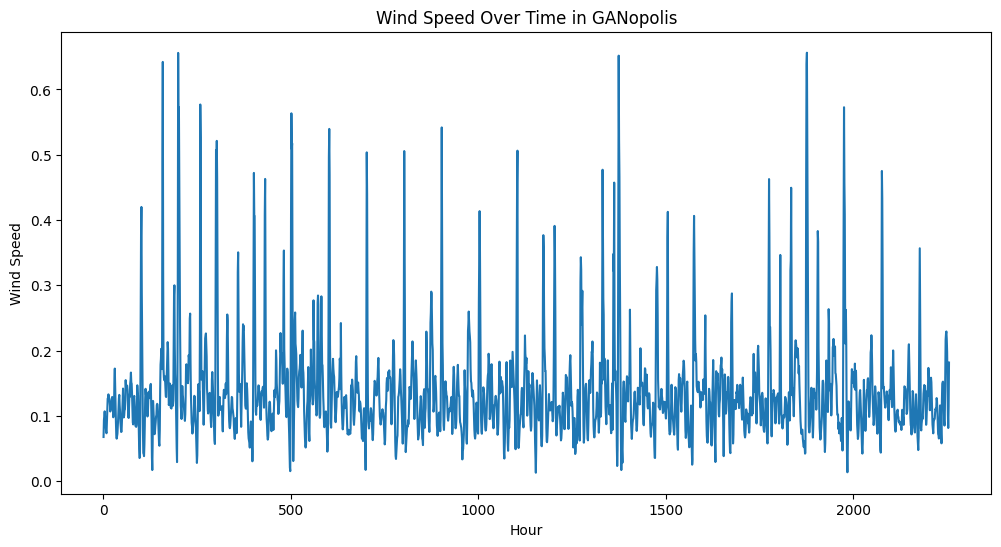

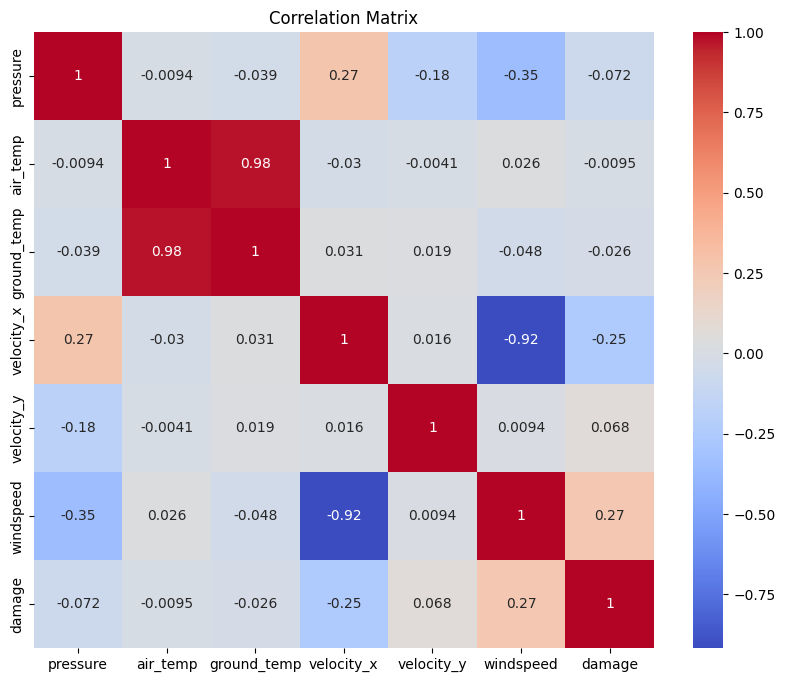

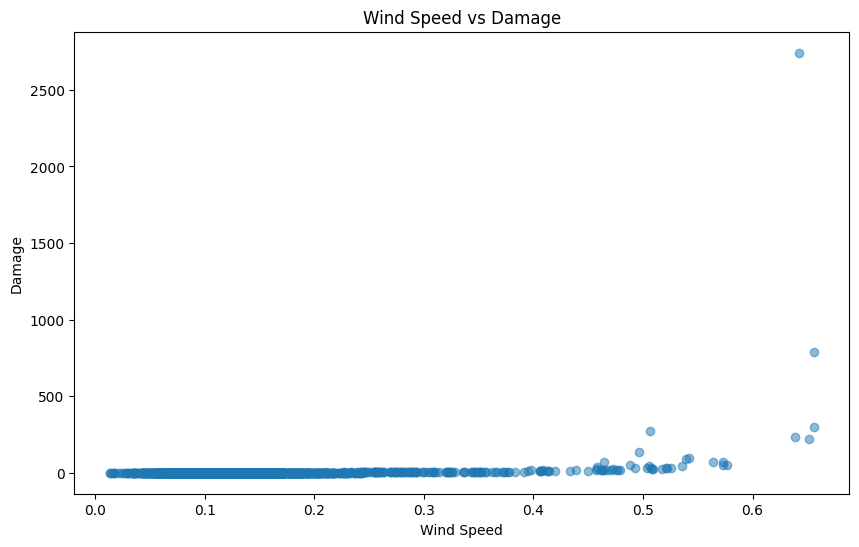

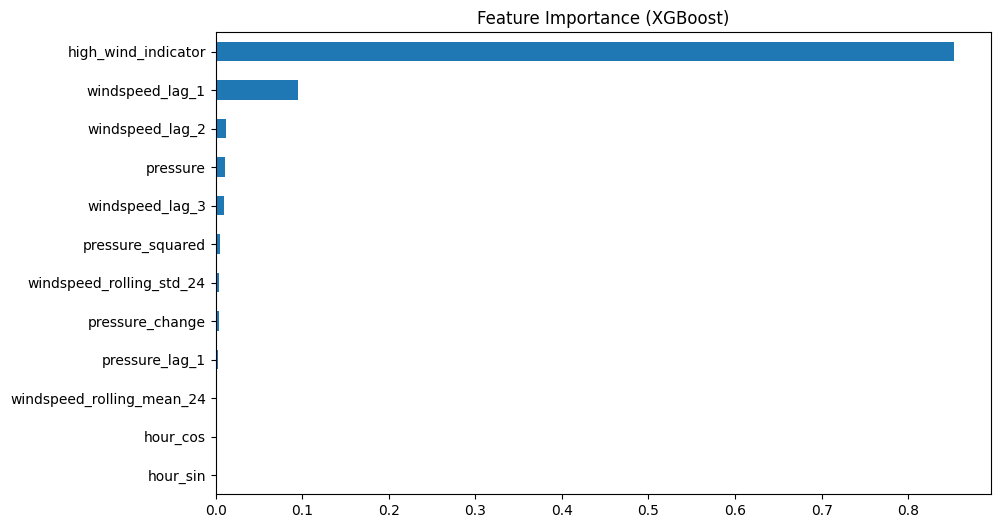

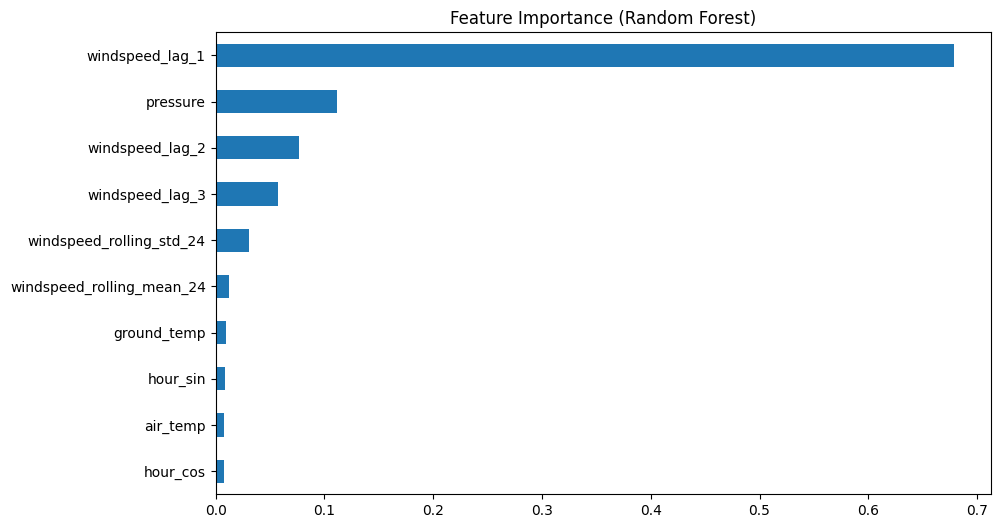

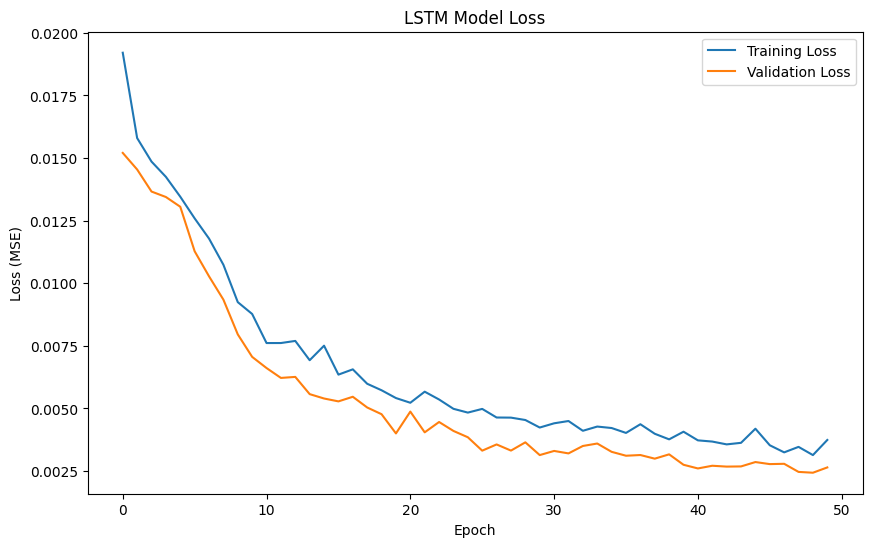

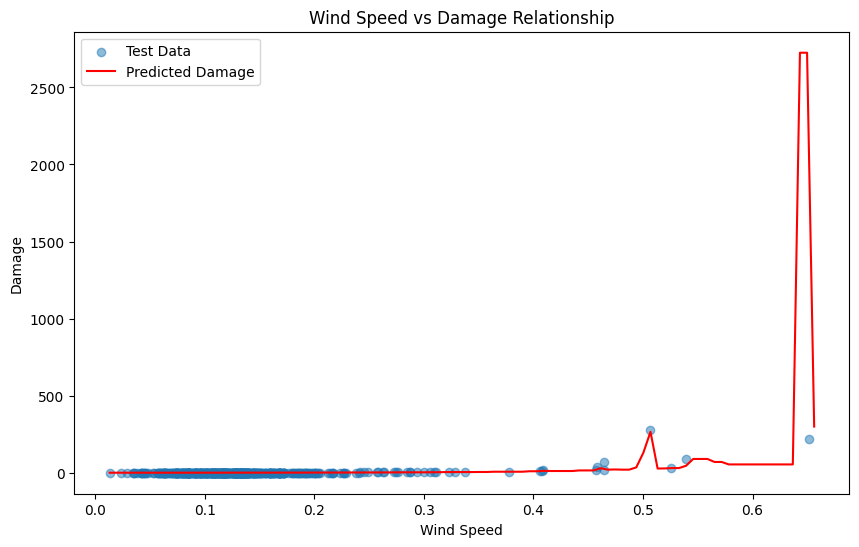

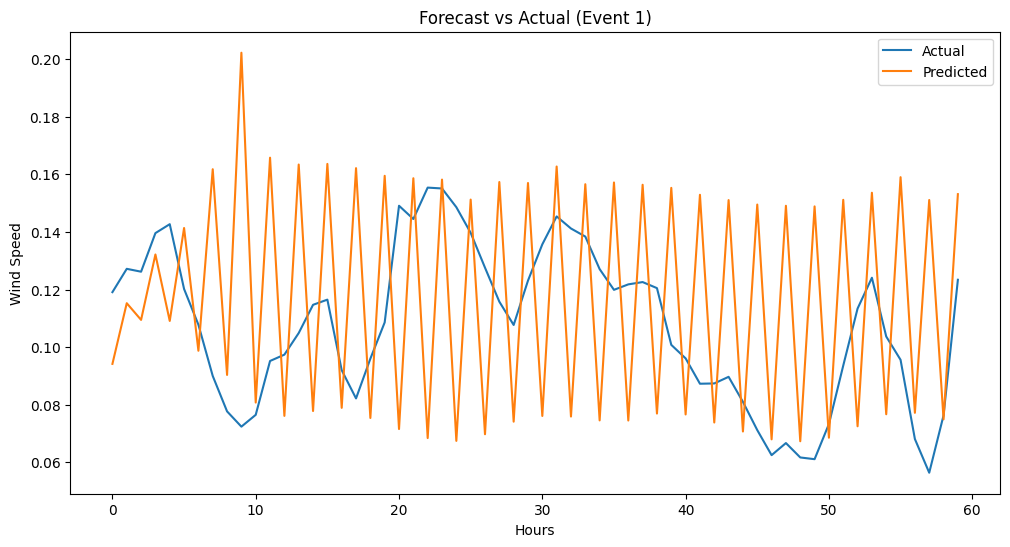

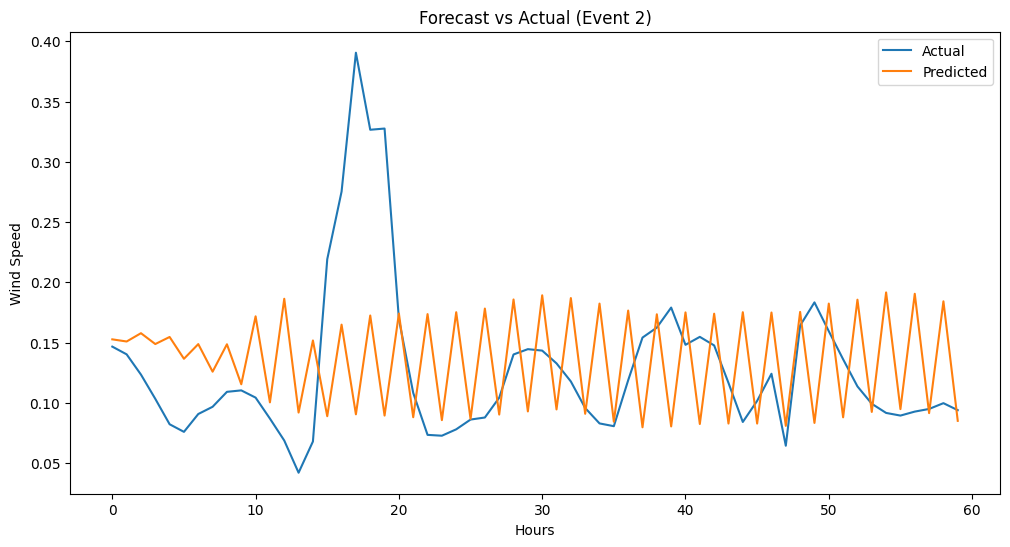

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
import xgboost as xgb
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import warnings
warnings.filterwarnings('ignore')

# 1. Data Loading Functions
def load_training_data():
    """Load and prepare the training data for GANopolis"""
    train_data = pd.read_csv('training_data.csv')
    # Filter for GANopolis
    ganopolis_data = train_data[train_data['city'] == 'GANopolis'].copy()
    # Sort by time
    ganopolis_data = ganopolis_data.sort_values(by=['day', 'hour_of_day'])
    ganopolis_data.reset_index(drop=True, inplace=True)
    return ganopolis_data

def load_event_data(event_number):
    """Load data for a specific event"""
    event_data = pd.read_csv(f'event_{event_number}.csv')
    ganopolis_event = event_data[event_data['city'] == 'GANopolis'].copy()
    ganopolis_event = ganopolis_event.sort_values(by=['day', 'hour_of_day'])
    ganopolis_event.reset_index(drop=True, inplace=True)
    return ganopolis_event

# 2. Exploratory Data Analysis
def exploratory_data_analysis(data):
    """Perform exploratory data analysis on the dataset"""
    # Basic statistics
    print("Basic Statistics:")
    print(data.describe())

    # Check for missing values
    print("\nMissing Values:")
    print(data.isnull().sum())

    # Time Series Plot of Wind Speed
    plt.figure(figsize=(12, 6))
    plt.plot(data['hour'], data['windspeed'])
    plt.title('Wind Speed Over Time in GANopolis')
    plt.xlabel('Hour')
    plt.ylabel('Wind Speed')
    plt.savefig('windspeed_timeseries.png')

    # Correlation Matrix
    plt.figure(figsize=(10, 8))
    corr_matrix = data[['pressure', 'air_temp', 'ground_temp', 'velocity_x',
                       'velocity_y', 'windspeed', 'damage']].corr()
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
    plt.title('Correlation Matrix')
    plt.savefig('correlation_matrix.png')

    # Wind Speed vs Damage
    plt.figure(figsize=(10, 6))
    plt.scatter(data['windspeed'], data['damage'], alpha=0.5)
    plt.title('Wind Speed vs Damage')
    plt.xlabel('Wind Speed')
    plt.ylabel('Damage')
    plt.savefig('windspeed_vs_damage.png')

    return corr_matrix

# 3. Feature Engineering
def feature_engineering(data):
    """Create features for time series prediction"""
    # Create a copy to avoid modifying the original
    df = data.copy()

    # Create time-based features
    df['hour_sin'] = np.sin(2 * np.pi * df['hour_of_day'] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour_of_day'] / 24)

    # Create lag features for wind speed
    for lag in [1, 2, 3, 6, 12, 24]:
        df[f'windspeed_lag_{lag}'] = df['windspeed'].shift(lag)

    # Create lag features for other weather variables
    for var in ['pressure', 'air_temp', 'ground_temp']:
        for lag in [1, 6, 24]:
            df[f'{var}_lag_{lag}'] = df[var].shift(lag)

    # Create rolling statistics
    for window in [6, 12, 24]:
        df[f'windspeed_rolling_mean_{window}'] = df['windspeed'].rolling(window=window).mean()
        df[f'windspeed_rolling_std_{window}'] = df['windspeed'].rolling(window=window).std()

    # Create features for high wind events
    df['high_wind_indicator'] = (df['windspeed'] > 0.4).astype(int)
    df['pressure_change'] = df['pressure'].diff()
    df['pressure_squared'] = df['pressure'] ** 2

    # Create threshold-based damage features
    df['wind_above_threshold'] = np.maximum(0, df['windspeed'] - 0.4)
    df['wind_high_impact'] = np.maximum(0, df['windspeed'] - 0.5) ** 2

    # Drop rows with NaN values (from lag features)
    df = df.dropna()

    return df

# 4. LSTM Data Preparation Functions
def create_sequences(data, features, target_col, seq_length=24, pred_length=1):
    """
    Create sequences for LSTM training

    Parameters:
    data: DataFrame with time series data
    features: list of feature columns to include
    target_col: the column to predict
    seq_length: the number of time steps in each input sequence
    pred_length: the number of time steps to predict ahead

    Returns:
    X: input sequences
    y: target values
    """
    X, y = [], []

    # Extract relevant features
    data_array = data[features].values
    target_array = data[target_col].values

    # Create sequences
    for i in range(len(data_array) - seq_length - pred_length + 1):
        X.append(data_array[i:i+seq_length])
        y.append(target_array[i+seq_length:i+seq_length+pred_length])

    return np.array(X), np.array(y)

def prepare_lstm_data(data, features, target_col='windspeed', seq_length=24, test_size=0.2):
    """
    Prepare data for LSTM model including scaling
    """
    # Create sequences
    X, y = create_sequences(data, features, target_col, seq_length)

    # Reshape for single-step prediction if needed
    if y.shape[1] == 1:
        y = y.reshape(-1)

    # Split into train and validation sets
    split_idx = int(len(X) * (1 - test_size))
    X_train, X_val = X[:split_idx], X[split_idx:]
    y_train, y_val = y[:split_idx], y[split_idx:]

    # Scale the data (LSTM models perform better with scaled data)
    scaler_x = MinMaxScaler()
    scaler_y = MinMaxScaler()

    # Reshape to 2D for scaling
    n_samples_train = X_train.shape[0]
    n_samples_val = X_val.shape[0]
    n_features = X_train.shape[2]

    X_train_2d = X_train.reshape(n_samples_train * seq_length, n_features)
    X_val_2d = X_val.reshape(n_samples_val * seq_length, n_features)

    # Fit on training data only
    X_train_2d = scaler_x.fit_transform(X_train_2d)
    X_val_2d = scaler_x.transform(X_val_2d)

    # Reshape back to 3D
    X_train_scaled = X_train_2d.reshape(n_samples_train, seq_length, n_features)
    X_val_scaled = X_val_2d.reshape(n_samples_val, seq_length, n_features)

    # Scale y
    y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).flatten()
    y_val_scaled = scaler_y.transform(y_val.reshape(-1, 1)).flatten()

    return X_train_scaled, X_val_scaled, y_train_scaled, y_val_scaled, scaler_x, scaler_y

# 5. Model Building Functions
def build_wind_speed_model(data):
    """Build and train the wind speed prediction model using XGBoost"""
    # Define features based on feature importance analysis
    features = [
        'windspeed_lag_1', 'windspeed_lag_2', 'windspeed_lag_3',
        'pressure', 'pressure_squared', 'pressure_change',
        'pressure_lag_1', 'high_wind_indicator',
        'hour_sin', 'hour_cos',
        'windspeed_rolling_mean_24', 'windspeed_rolling_std_24'
    ]

    # Only include features that exist in the data
    features = [f for f in features if f in data.columns]

    # Train XGBoost model
    model = xgb.XGBRegressor(
        n_estimators=200,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_alpha=0.3,
        random_state=42
    )

    model.fit(data[features], data['windspeed'])

    # Print feature importance
    if len(features) > 0:
        plt.figure(figsize=(10, 6))
        feat_importances = pd.Series(model.feature_importances_, index=features)
        feat_importances.sort_values().plot(kind='barh')
        plt.title('Feature Importance (XGBoost)')
        plt.savefig('xgb_feature_importance.png')

    return model, features

def build_random_forest_model(data):
    """Build and train a Random Forest model as an alternative approach"""
    # Define features
    features = [
        'windspeed_lag_1', 'windspeed_lag_2', 'windspeed_lag_3',
        'pressure', 'hour_sin', 'hour_cos',
        'air_temp', 'ground_temp',
        'windspeed_rolling_mean_24', 'windspeed_rolling_std_24'
    ]

    # Only include features that exist in the data
    features = [f for f in features if f in data.columns]

    # Train Random Forest
    model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
    model.fit(data[features], data['windspeed'])

    # Print feature importance
    if len(features) > 0:
        plt.figure(figsize=(10, 6))
        feat_importances = pd.Series(model.feature_importances_, index=features)
        feat_importances.sort_values().plot(kind='barh')
        plt.title('Feature Importance (Random Forest)')
        plt.savefig('rf_feature_importance.png')

    return model, features

def build_lstm_model(data):
    """Build and train an LSTM model for time series forecasting"""
    # Select features for LSTM
    lstm_features = [
        'windspeed', 'pressure', 'air_temp', 'ground_temp',
        'hour_sin', 'hour_cos', 'pressure_change'
    ]

    # Only include features that exist in the data
    lstm_features = [f for f in lstm_features if f in data.columns]

    # Prepare data for LSTM
    sequence_length = 24  # Use 24 hours of history

    X_train, X_val, y_train, y_val, scaler_x, scaler_y = prepare_lstm_data(
        data, lstm_features, 'windspeed', sequence_length
    )

    # Build LSTM model
    model = Sequential([
        LSTM(64, activation='relu', return_sequences=True,
             input_shape=(sequence_length, len(lstm_features))),
        Dropout(0.2),
        LSTM(32, activation='relu'),
        Dropout(0.2),
        Dense(1)
    ])

    # Compile model
    model.compile(optimizer='adam', loss='mse')

    # Early stopping to prevent overfitting
    early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    # Train model
    print("Training LSTM model...")
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=50,
        batch_size=32,
        callbacks=[early_stop],
        verbose=1
    )

    # Plot training history
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('LSTM Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss (MSE)')
    plt.legend()
    plt.savefig('lstm_training_history.png')

    # Evaluate on validation set
    val_pred_scaled = model.predict(X_val)
    val_pred = scaler_y.inverse_transform(val_pred_scaled).flatten()
    val_true = scaler_y.inverse_transform(y_val.reshape(-1, 1)).flatten()

    val_mse = mean_squared_error(val_true, val_pred)
    print(f"LSTM Validation MSE: {val_mse:.6f}")

    # Return model and preprocessing objects
    return {
        'model': model,
        'features': lstm_features,
        'scaler_x': scaler_x,
        'scaler_y': scaler_y,
        'sequence_length': sequence_length
    }

def build_damage_model(data):
    """Build and train the damage prediction model"""
    # Create specialized features for damage prediction
    features = ['windspeed', 'wind_above_threshold', 'wind_high_impact']

    # Make sure all features exist
    for feature in ['wind_above_threshold', 'wind_high_impact']:
        if feature not in data.columns:
            if feature == 'wind_above_threshold':
                data[feature] = np.maximum(0, data['windspeed'] - 0.4)
            elif feature == 'wind_high_impact':
                data[feature] = np.maximum(0, data['windspeed'] - 0.5) ** 2

    # Train XGBoost model for damage prediction
    model = xgb.XGBRegressor(
        n_estimators=200,
        learning_rate=0.05,
        max_depth=5,
        random_state=42
    )

    model.fit(data[features], data['damage'])

    # Visualize the relationship
    plt.figure(figsize=(10, 6))
    wind_range = np.linspace(data['windspeed'].min(), data['windspeed'].max(), 100)
    wind_df = pd.DataFrame({
        'windspeed': wind_range,
        'wind_above_threshold': np.maximum(0, wind_range - 0.4),
        'wind_high_impact': np.maximum(0, wind_range - 0.5) ** 2
    })
    damage_pred = model.predict(wind_df[features])

    # Sample some test data
    X_test = data[features].sample(n=min(500, len(data)), random_state=42)
    y_test = data.loc[X_test.index, 'damage']

    plt.scatter(X_test['windspeed'], y_test, alpha=0.5, label='Test Data')
    plt.plot(wind_range, damage_pred, 'r-', label='Predicted Damage')
    plt.title('Wind Speed vs Damage Relationship')
    plt.xlabel('Wind Speed')
    plt.ylabel('Damage')
    plt.legend()
    plt.savefig('damage_model.png')

    return model, features

# 6. Forecasting Functions
def forecast_with_lstm(lstm_model_info, initial_data, hours=120):
    """
    Generate wind speed forecast using the LSTM model
    """
    model = lstm_model_info['model']
    features = lstm_model_info['features']
    scaler_x = lstm_model_info['scaler_x']
    scaler_y = lstm_model_info['scaler_y']
    seq_length = lstm_model_info['sequence_length']

    # Ensure initial_data has all required features
    for feature in features:
        if feature not in initial_data.columns:
            if feature == 'pressure_change':
                initial_data[feature] = initial_data['pressure'].diff().fillna(0)

    # Get the most recent sequence
    last_sequence = initial_data[features].values[-seq_length:]

    # Scale the sequence
    last_sequence_2d = last_sequence.reshape(seq_length, len(features))
    last_sequence_scaled = scaler_x.transform(last_sequence_2d).reshape(1, seq_length, len(features))

    # Initialize predictions list
    predictions = []
    current_sequence = last_sequence_scaled.copy()

    # Generate predictions one at a time
    for _ in range(hours):
        # Predict next value
        next_pred_scaled = model.predict(current_sequence)
        next_pred = scaler_y.inverse_transform(next_pred_scaled)[0, 0]
        predictions.append(next_pred)

        # Update sequence for next prediction
        next_features = np.zeros(len(features))

        # Set windspeed to the predicted value
        wind_idx = features.index('windspeed') if 'windspeed' in features else None
        if wind_idx is not None:
            next_features[wind_idx] = next_pred_scaled[0, 0]

        # Set hour_sin and hour_cos based on the next hour
        last_hour = initial_data['hour_of_day'].values[-1]
        next_hour = (last_hour + 1 + len(predictions)) % 24

        sin_idx = features.index('hour_sin') if 'hour_sin' in features else None
        cos_idx = features.index('hour_cos') if 'hour_cos' in features else None

        if sin_idx is not None:
            next_features[sin_idx] = np.sin(2 * np.pi * next_hour / 24)
        if cos_idx is not None:
            next_features[cos_idx] = np.cos(2 * np.pi * next_hour / 24)

        # For other features, use the last value from the sequence
        # This is a simplification - in a real application, you might have more sophisticated ways
        # to predict these feature values
        for i, feat in enumerate(features):
            if i != wind_idx and i != sin_idx and i != cos_idx:
                next_features[i] = current_sequence[0, -1, i]

        # Reshape and append to create the new sequence
        next_features = next_features.reshape(1, 1, len(features))
        current_sequence = np.append(current_sequence[:, 1:, :], next_features, axis=1)

    return np.array(predictions)

def forecast_wind_speed(initial_data, model, features, hours=120):
    """
    Recursively forecast wind speed using predictions as inputs for next steps
    """
    # Create a copy of the initial data to avoid modifying the original
    forecast_data = initial_data.copy()
    predictions = []

    # Get the latest data point with required features
    latest_data = forecast_data.iloc[-1:].copy()

    # For each hour in the forecast horizon
    for i in range(hours):
        # Ensure all features are available
        for feature in features:
            if feature not in latest_data.columns:
                latest_data[feature] = 0  # Default value

        # Make prediction for next hour
        try:
            pred = model.predict(latest_data[features])[0]
        except:
            # If prediction fails, use the last known wind speed
            print(f"Warning: Prediction failed at hour {i}, using fallback")
            pred = latest_data['windspeed'].values[0] if 'windspeed' in latest_data else 0.1

        predictions.append(pred)

        # Create a new row with the prediction
        new_row = latest_data.copy()
        new_row['hour'] = latest_data['hour'].values[0] + 1
        new_row['hour_of_day'] = (latest_data['hour_of_day'].values[0] + 1) % 24
        new_row['day'] = latest_data['day'].values[0] + (1 if new_row['hour_of_day'].values[0] == 0 else 0)
        new_row['windspeed'] = pred

        # Update lag features
        if 'windspeed_lag_1' in features:
            new_row['windspeed_lag_1'] = latest_data['windspeed'].values[0]
        if 'windspeed_lag_2' in features and 'windspeed_lag_1' in latest_data:
            new_row['windspeed_lag_2'] = latest_data['windspeed_lag_1'].values[0]
        if 'windspeed_lag_3' in features and 'windspeed_lag_2' in latest_data:
            new_row['windspeed_lag_3'] = latest_data['windspeed_lag_2'].values[0]

        # Update time-based features
        if 'hour_sin' in features:
            new_row['hour_sin'] = np.sin(2 * np.pi * new_row['hour_of_day'].values[0] / 24)
        if 'hour_cos' in features:
            new_row['hour_cos'] = np.cos(2 * np.pi * new_row['hour_of_day'].values[0] / 24)

        # Update other features
        if 'high_wind_indicator' in features:
            new_row['high_wind_indicator'] = 1 if pred > 0.4 else 0

        if 'wind_above_threshold' in features:
            new_row['wind_above_threshold'] = max(0, pred - 0.4)

        if 'wind_high_impact' in features:
            new_row['wind_high_impact'] = max(0, pred - 0.5) ** 2

        # Update rolling statistics (simplified approach)
        if 'windspeed_rolling_mean_24' in features:
            if i < 24:
                # For the first 24 hours, use the actual mean from the latest data
                new_row['windspeed_rolling_mean_24'] = latest_data['windspeed_rolling_mean_24'].values[0]
            else:
                # After 24 hours, use the mean of the last 24 predictions
                new_row['windspeed_rolling_mean_24'] = np.mean(predictions[-24:])

        if 'windspeed_rolling_std_24' in features:
            if i < 24:
                # For the first 24 hours, use the actual std from the latest data
                new_row['windspeed_rolling_std_24'] = latest_data['windspeed_rolling_std_24'].values[0]
            else:
                # After 24 hours, use the std of the last 24 predictions
                new_row['windspeed_rolling_std_24'] = np.std(predictions[-24:])

        # Update latest data for next iteration
        latest_data = new_row

    return np.array(predictions)

def ensemble_forecast(initial_data, models_info, hours=120):
    """
    Generate an ensemble forecast using multiple models including LSTM
    """
    all_predictions = []

    # Get LSTM prediction if available
    if 'lstm' in models_info:
        lstm_model_info = models_info['lstm']
        lstm_predictions = forecast_with_lstm(lstm_model_info, initial_data, hours)
        all_predictions.append(lstm_predictions)

    # Get traditional model predictions
    for model_type, model_data in models_info.items():
        if model_type != 'lstm':
            model, features = model_data
            predictions = forecast_wind_speed(initial_data, model, features, hours)
            all_predictions.append(predictions)

    # Average the predictions from all models
    ensemble_predictions = np.mean(all_predictions, axis=0)

    return ensemble_predictions

# 7. Pricing Functions
def optimize_price_with_demand(predicted_wind_speeds, damage_model, damage_features):
    """
    Determine optimal price based on the demand curve formula

    demand = (10000 - (10000/500)*price) = (10000 - 20*price)
    unit_contribution_margin = (price - damage)
    profit = (demand)(unit_contribution_margin)
    """
    # Calculate expected damages for the next 120 hours
    damage_inputs = pd.DataFrame({
        'windspeed': predicted_wind_speeds,
        'wind_above_threshold': np.maximum(0, predicted_wind_speeds - 0.4),
        'wind_high_impact': np.maximum(0, predicted_wind_speeds - 0.5) ** 2
    })

    expected_damages = damage_model.predict(damage_inputs[damage_features])
    total_damage = np.sum(expected_damages)

    # Risk premium increases with the probability of high wind events
    high_wind_probability = np.mean(predicted_wind_speeds > 0.5)
    extreme_wind_probability = np.mean(predicted_wind_speeds > 0.6)

    # Calculate risk-adjusted damage
    risk_adjusted_damage = total_damage * (1 + 0.2*high_wind_probability + 0.5*extreme_wind_probability)

    # Optimal price from the derivative of the profit function
    optimal_price = 250 + risk_adjusted_damage / 2

    # Calculate expected profit at optimal price
    demand = 10000 - 20 * optimal_price
    unit_margin = optimal_price - total_damage
    expected_profit = demand * unit_margin

    return optimal_price, total_damage, expected_profit

# 8. Model Validation Functions
def validate_on_events(models_info, damage_model, damage_features, event_numbers=[1, 2]):
    """
    Validate models on specified event data
    """
    all_results = []

    for event_num in event_numbers:
        # Load and prepare event data
        event_data = load_event_data(event_num)

        # Split into first half (known) and second half (to predict)
        split_point = len(event_data) // 2
        first_half = event_data.iloc[:split_point]
        second_half = event_data.iloc[split_point:]  # All remaining data

        # Apply feature engineering
        processed_data = feature_engineering(first_half)

        # Calculate how many hours we can predict (limited by available data)
        hours_to_predict = min(120, len(second_half))

        # Generate ensemble forecast
        predicted_winds = ensemble_forecast(processed_data, models_info, hours=hours_to_predict)

        # Calculate wind speed error
        actual_winds = second_half['windspeed'].values[:hours_to_predict]
        wind_mse = mean_squared_error(actual_winds, predicted_winds)

        # Predict damages (using only the predicted period)
        damage_inputs = pd.DataFrame({
            'windspeed': predicted_winds,
            'wind_above_threshold': np.maximum(0, predicted_winds - 0.4),
            'wind_high_impact': np.maximum(0, predicted_winds - 0.5) ** 2
        })

        predicted_damages = damage_model.predict(damage_inputs[damage_features])
        total_predicted_damage = np.sum(predicted_damages)

        # Calculate actual damages (for the same period)
        actual_damage_inputs = pd.DataFrame({
            'windspeed': actual_winds,
            'wind_above_threshold': np.maximum(0, actual_winds - 0.4),
            'wind_high_impact': np.maximum(0, actual_winds - 0.5) ** 2
        })

        actual_damages = damage_model.predict(actual_damage_inputs[damage_features])
        total_actual_damage = np.sum(actual_damages)

        # Set price based on predictions
        price, _, predicted_profit = optimize_price_with_demand(predicted_winds, damage_model, damage_features)

        # Calculate actual profit with our price but actual damage
        actual_demand = 10000 - 20 * price
        actual_unit_margin = price - total_actual_damage
        actual_profit = actual_demand * actual_unit_margin

        all_results.append({
            'event': event_num,
            'wind_mse': wind_mse,
            'predicted_total_damage': total_predicted_damage,
            'actual_total_damage': total_actual_damage,
            'price': price,
            'predicted_profit': predicted_profit,
            'actual_profit': actual_profit
        })

        # Visualize forecast
        plt.figure(figsize=(12, 6))
        plt.plot(actual_winds, label='Actual')
        plt.plot(predicted_winds, label='Predicted')
        plt.title(f'Forecast vs Actual (Event {event_num})')
        plt.legend()
        plt.xlabel('Hours')
        plt.ylabel('Wind Speed')
        plt.savefig(f'forecast_event_{event_num}.png')

    return all_results

# 9. Processing and Submission Functions
def process_event(event_number, models_info, damage_model, damage_features):
    """
    Process an event and generate predictions and pricing
    """
    # Load and prepare event data
    event_data = load_event_data(event_number)

    # Apply feature engineering
    processed_data = feature_engineering(event_data)

    # Make sure we have sufficient data after feature engineering
    if len(processed_data) < 5:  # Need some minimum data for features
        print(f"Warning: Not enough processed data for event {event_number}. Using fallback approach.")
        # Simple fallback: use mean values from the training data
        predicted_wind_speeds = np.array([0.12] * 120)  # Average wind speed
    else:
        # Use ensemble forecasting to predict wind speeds
        predicted_wind_speeds = ensemble_forecast(processed_data, models_info, hours=120)

    # Set the price
    optimal_price, total_damage, expected_profit = optimize_price_with_demand(predicted_wind_speeds, damage_model, damage_features)

    return {
        'event_number': event_number,
        'price': optimal_price,
        'predicted_wind_speeds': predicted_wind_speeds,
        'total_damage': total_damage,
        'expected_profit': expected_profit
    }

def create_submission(results):
    """
    Create the submission file
    """
    # Initialize submission dataframe
    submission_data = []

    for result in results:
        event_dict = {
            'event_number': result['event_number'],
            'price': result['price']
        }

        # Add wind speed predictions
        for i, wind_speed in enumerate(result['predicted_wind_speeds']):
            event_dict[str(i)] = wind_speed

        submission_data.append(pd.DataFrame([event_dict]))

    submission_df = pd.concat(submission_data, ignore_index=True)
    submission_df.to_csv('submissionLSTM.csv', index=False)
    print("Submission file created successfully!")

# 10. Main Function
def main():
    print("Starting Enhanced Wind Speed Forecasting with LSTM and Ensemble Methods")

    # Load and analyze training data
    print("Loading and analyzing training data...")
    gan_data = load_training_data()
    exploratory_data_analysis(gan_data)

    # Feature engineering
    print("Performing feature engineering...")
    processed_data = feature_engineering(gan_data)

    # Train traditional models
    print("Training traditional models (XGBoost and Random Forest)...")
    xgb_model, xgb_features = build_wind_speed_model(processed_data)
    rf_model, rf_features = build_random_forest_model(processed_data)

    # Train LSTM model
    print("Training LSTM model (this may take some time)...")
    lstm_model_info = build_lstm_model(processed_data)

    # Train damage model
    print("Training damage prediction model...")
    damage_model, damage_features = build_damage_model(gan_data)

    # Combine models into a dictionary for ensemble
    models_info = {
        'xgboost': (xgb_model, xgb_features),
        'random_forest': (rf_model, rf_features),
        'lstm': lstm_model_info
    }

    # Validate models on sample events
    print("Validating models on sample events...")
    validation_results = validate_on_events(
        models_info,
        damage_model, damage_features,
        event_numbers=[1, 2]
    )

    # Display validation results
    print("\nValidation Results:")
    for result in validation_results:
        print(f"Event {result['event']}:")
        print(f"  Wind Speed MSE: {result['wind_mse']:.6f}")
        print(f"  Predicted Total Damage: ${result['predicted_total_damage']:.2f}")
        print(f"  Actual Total Damage: ${result['actual_total_damage']:.2f}")
        print(f"  Optimal Price: ${result['price']:.2f}")
        print(f"  Predicted Profit: ${result['predicted_profit']:.2f}")
        print(f"  Actual Profit: ${result['actual_profit']:.2f}")

    # Process all events and create predictions
    print("\nProcessing all events and generating predictions...")
    results = []
    for event_num in range(1, 11):
        result = process_event(event_num, models_info, damage_model, damage_features)
        results.append(result)

        print(f"Event {event_num}: Price = ${result['price']:.2f}, " +
              f"Estimated Damage = ${result['total_damage']:.2f}, " +
              f"Expected Profit = ${result['expected_profit']:.2f}")

    # Create submission file
    print("\nCreating submission file...")
    create_submission(results)

    print("\nProcess completed successfully!")

if __name__ == "__main__":
    main()

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from matplotlib.gridspec import GridSpec

def load_submission(file_path):
    """Load the submission CSV file"""
    df = pd.read_csv(file_path)
    print(f"Loaded submission with {len(df)} events")
    return df

def extract_wind_speeds(submission_df):
    """Extract wind speed predictions from submission dataframe"""
    # Get columns that contain wind speed predictions (columns '0' through '119')
    wind_columns = [str(i) for i in range(120)]
    wind_speeds = {}

    for _, row in submission_df.iterrows():
        event_num = row['event_number']
        # Extract wind speeds for this event
        event_winds = [row[col] for col in wind_columns if col in row]
        wind_speeds[event_num] = event_winds

    return wind_speeds

def plot_wind_forecasts(wind_speeds, output_dir):
    """Plot wind speed forecasts for each event"""
    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)

    # Plot all events on one figure
    plt.figure(figsize=(15, 10))
    for event_num, winds in wind_speeds.items():
        plt.plot(winds, label=f'Event {event_num}')

    plt.title('Wind Speed Forecasts for All Events')
    plt.xlabel('Hour')
    plt.ylabel('Wind Speed')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.savefig(f'{output_dir}/all_events_forecast.png')
    plt.close()

    # Plot each event individually for detailed view
    for event_num, winds in wind_speeds.items():
        plt.figure(figsize=(12, 6))
        plt.plot(winds, linewidth=2)

        # Highlight high wind regions
        plt.axhline(y=0.4, color='orange', linestyle='--', alpha=0.7, label='Moderate Wind Threshold')
        plt.axhline(y=0.5, color='red', linestyle='--', alpha=0.7, label='High Wind Threshold')

        # Identify potential extreme events
        extreme_hours = [i for i, speed in enumerate(winds) if speed > 0.5]
        if extreme_hours:
            plt.scatter(extreme_hours, [winds[i] for i in extreme_hours], color='red', s=50, zorder=5, label='High Wind Events')

        plt.title(f'Wind Speed Forecast - Event {event_num}')
        plt.xlabel('Hour')
        plt.ylabel('Wind Speed')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.savefig(f'{output_dir}/event_{event_num}_forecast.png')
        plt.close()

def analyze_pricing(submission_df, wind_speeds, output_dir):
    """Analyze pricing strategy based on wind forecasts"""
    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)

    # Extract prices
    prices = submission_df[['event_number', 'price']].set_index('event_number')['price']

    # Calculate wind statistics
    wind_stats = {}
    for event_num, winds in wind_speeds.items():
        wind_stats[event_num] = {
            'mean': np.mean(winds),
            'max': np.max(winds),
            'min': np.min(winds),
            'high_wind_pct': 100 * np.mean([1 if w > 0.4 else 0 for w in winds]),
            'extreme_wind_pct': 100 * np.mean([1 if w > 0.5 else 0 for w in winds])
        }

    # Create dataframe with wind stats and prices
    stats_df = pd.DataFrame(wind_stats).T
    stats_df['price'] = [prices.get(event_num, np.nan) for event_num in stats_df.index]

    # Calculate estimated damage and profit (simplified estimation)
    stats_df['est_damage_per_hour'] = stats_df.apply(
        lambda row: np.mean([max(0, w - 0.4) + max(0, w - 0.5)**2 for w in wind_speeds[row.name]]),
        axis=1
    )
    stats_df['est_total_damage'] = stats_df['est_damage_per_hour'] * 120

    # Calculate demand, unit margin, and profit
    stats_df['demand'] = 10000 - 20 * stats_df['price']
    stats_df['unit_margin'] = stats_df['price'] - stats_df['est_total_damage']
    stats_df['est_profit'] = stats_df['demand'] * stats_df['unit_margin']

    # Plot price vs wind statistics
    fig, axes = plt.subplots(1, 2, figsize=(15, 7))

    # Price vs Mean Wind Speed
    sns.scatterplot(x='mean', y='price', data=stats_df, ax=axes[0], s=100)
    for i, row in stats_df.iterrows():
        axes[0].annotate(f"Event {i}", (row['mean'], row['price']), xytext=(5, 5),
                       textcoords='offset points')
    axes[0].set_title('Price vs Mean Wind Speed')
    axes[0].set_xlabel('Mean Wind Speed')
    axes[0].set_ylabel('Price ($)')
    axes[0].grid(True, alpha=0.3)

    # Price vs Extreme Wind Percentage
    sns.scatterplot(x='extreme_wind_pct', y='price', data=stats_df, ax=axes[1], s=100)
    for i, row in stats_df.iterrows():
        axes[1].annotate(f"Event {i}", (row['extreme_wind_pct'], row['price']), xytext=(5, 5),
                       textcoords='offset points')
    axes[1].set_title('Price vs Extreme Wind Percentage')
    axes[1].set_xlabel('Percentage of Hours with Wind Speed > 0.5')
    axes[1].set_ylabel('Price ($)')
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(f'{output_dir}/price_vs_wind_stats.png')
    plt.close()

    # Plot profit-related metrics
    fig = plt.figure(figsize=(15, 15))
    gs = GridSpec(3, 2, figure=fig)

    # Price by event
    ax1 = fig.add_subplot(gs[0, 0])
    sns.barplot(x=stats_df.index, y='price', data=stats_df, ax=ax1)
    ax1.set_title('Price by Event')
    ax1.set_xlabel('Event Number')
    ax1.set_ylabel('Price ($)')
    for i, p in enumerate(ax1.patches):
        ax1.annotate(f"${p.get_height():.2f}", (p.get_x() + p.get_width()/2., p.get_height()),
                     ha='center', va='bottom')

    # Estimated damage by event
    ax2 = fig.add_subplot(gs[0, 1])
    sns.barplot(x=stats_df.index, y='est_total_damage', data=stats_df, ax=ax2)
    ax2.set_title('Estimated Total Damage by Event')
    ax2.set_xlabel('Event Number')
    ax2.set_ylabel('Estimated Damage ($)')
    for i, p in enumerate(ax2.patches):
        ax2.annotate(f"${p.get_height():.2f}", (p.get_x() + p.get_width()/2., p.get_height()),
                     ha='center', va='bottom')

    # Demand by event
    ax3 = fig.add_subplot(gs[1, 0])
    sns.barplot(x=stats_df.index, y='demand', data=stats_df, ax=ax3)
    ax3.set_title('Expected Demand by Event')
    ax3.set_xlabel('Event Number')
    ax3.set_ylabel('Number of Customers')
    for i, p in enumerate(ax3.patches):
        ax3.annotate(f"{p.get_height():.0f}", (p.get_x() + p.get_width()/2., p.get_height()),
                     ha='center', va='bottom')

    # Unit margin by event
    ax4 = fig.add_subplot(gs[1, 1])
    sns.barplot(x=stats_df.index, y='unit_margin', data=stats_df, ax=ax4)
    ax4.set_title('Unit Margin by Event')
    ax4.set_xlabel('Event Number')
    ax4.set_ylabel('Unit Margin ($)')
    for i, p in enumerate(ax4.patches):
        ax4.annotate(f"${p.get_height():.2f}", (p.get_x() + p.get_width()/2., p.get_height()),
                     ha='center', va='bottom')

    # Estimated profit by event
    ax5 = fig.add_subplot(gs[2, :])
    sns.barplot(x=stats_df.index, y='est_profit', data=stats_df, ax=ax5)
    ax5.set_title('Estimated Profit by Event')
    ax5.set_xlabel('Event Number')
    ax5.set_ylabel('Estimated Profit ($)')
    for i, p in enumerate(ax5.patches):
        ax5.annotate(f"${p.get_height():.0f}", (p.get_x() + p.get_width()/2., p.get_height()),
                     ha='center', va='bottom')

    plt.tight_layout()
    plt.savefig(f'{output_dir}/profit_analysis.png')
    plt.close()

    # Save analysis to CSV
    stats_df.to_csv(f'{output_dir}/submission_analysis.csv')
    print(f"Analysis saved to {output_dir}/submission_analysis.csv")

    return stats_df

def visualize_multiple_submissions(submission_files, output_dir):
    """Compare multiple submission files"""
    all_prices = {}
    all_profits = {}

    for file_path in submission_files:
        # Extract model name from file path
        model_name = os.path.basename(file_path).replace('.csv', '')

        # Load and analyze submission
        df = load_submission(file_path)
        wind_speeds = extract_wind_speeds(df)
        stats_df = analyze_pricing(df, wind_speeds, f"{output_dir}/{model_name}")

        # Store prices and profits for comparison
        all_prices[model_name] = stats_df['price']
        all_profits[model_name] = stats_df['est_profit']

    if len(submission_files) > 1:
        # Create comparison plots
        # Price comparison
        plt.figure(figsize=(15, 8))
        price_df = pd.DataFrame(all_prices)
        price_df.plot(kind='bar', figsize=(15, 8))
        plt.title('Price Comparison Across Models')
        plt.xlabel('Event Number')
        plt.ylabel('Price ($)')
        plt.grid(True, alpha=0.3)
        plt.savefig(f'{output_dir}/price_comparison.png')
        plt.close()

        # Profit comparison
        plt.figure(figsize=(15, 8))
        profit_df = pd.DataFrame(all_profits)
        profit_df.plot(kind='bar', figsize=(15, 8))
        plt.title('Estimated Profit Comparison Across Models')
        plt.xlabel('Event Number')
        plt.ylabel('Estimated Profit ($)')
        plt.grid(True, alpha=0.3)
        plt.savefig(f'{output_dir}/profit_comparison.png')
        plt.close()

        # Save comparison to CSV
        price_df.to_csv(f'{output_dir}/price_comparison.csv')
        profit_df.to_csv(f'{output_dir}/profit_comparison.csv')

        # Calculate total profit for each model
        total_profits = profit_df.sum()

        plt.figure(figsize=(10, 6))
        total_profits.plot(kind='bar')
        plt.title('Total Estimated Profit by Model')
        plt.xlabel('Model')
        plt.ylabel('Total Estimated Profit ($)')
        plt.grid(True, alpha=0.3)
        for i, v in enumerate(total_profits):
            plt.annotate(f"${v:,.0f}", (i, v), ha='center', va='bottom')
        plt.tight_layout()
        plt.savefig(f'{output_dir}/total_profit_comparison.png')
        plt.close()

        print("Model comparisons saved to:", output_dir)

def main():
    # Define submission file and output directory
    submission_file = 'submission.csv'
    output_dir = 'visualization_output'

    # Check if the submission file exists
    if not os.path.exists(submission_file):
        print(f"Error: Submission file not found at {submission_file}")
        return

    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)

    # Load the submission file
    submission_df = load_submission(submission_file)

    # Extract wind speed predictions
    wind_speeds = extract_wind_speeds(submission_df)

    # Plot wind forecasts
    plot_wind_forecasts(wind_speeds, output_dir)

    # Analyze pricing strategy
    analyze_pricing(submission_df, wind_speeds, output_dir)

    print(f"Visualizations and analysis saved to {output_dir}")

    # Check if there are multiple submission files to compare
    submission_dir = 'submission'
    if os.path.isdir(submission_dir):
        submission_files = [
            os.path.join(submission_dir, f)
            for f in os.listdir(submission_dir)
            if f.endswith('.csv') and 'submission' in f
        ]

        if len(submission_files) > 1:
            print(f"Found {len(submission_files)} submission files. Creating comparison...")
            visualize_multiple_submissions(submission_files, output_dir)

if __name__ == "__main__":
    main()

Loaded submission with 10 events
Analysis saved to visualization_output/submission_analysis.csv
Visualizations and analysis saved to visualization_output


In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import xgboost as xgb
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import os
import warnings
warnings.filterwarnings('ignore')

# Create directories for results
os.makedirs('city_results', exist_ok=True)
os.makedirs('visualizations', exist_ok=True)

# 1. Data Loading Functions
def load_training_data(filter_city=None):
    """
    Load and prepare the training data
    If filter_city is provided, only data for that city is returned
    """
    train_data = pd.read_csv('training_data.csv')

    # If a specific city is requested, filter for that city
    if filter_city:
        city_data = train_data[train_data['city'] == filter_city].copy()
    else:
        city_data = train_data.copy()

    # Sort by time and city
    city_data = city_data.sort_values(by=['city', 'day', 'hour_of_day'])
    city_data.reset_index(drop=True, inplace=True)

    return city_data

def get_city_list(data):
    """Get list of unique cities in the dataset"""
    return data['city'].unique().tolist()

def load_event_data(event_number, filter_city=None):
    """
    Load data for a specific event
    If filter_city is provided, only data for that city is returned
    """
    event_data = pd.read_csv(f'event_{event_number}.csv')

    # If a specific city is requested, filter for that city
    if filter_city:
        city_event = event_data[event_data['city'] == filter_city].copy()
    else:
        city_event = event_data.copy()

    city_event = city_event.sort_values(by=['city', 'day', 'hour_of_day'])
    city_event.reset_index(drop=True, inplace=True)

    return city_event

# 2. Exploratory Data Analysis
def exploratory_data_analysis(data, output_dir='visualizations'):
    """
    Perform exploratory data analysis on the dataset
    Generates city-specific visualizations if data contains multiple cities
    """
    # Basic statistics
    print("Basic Statistics:")
    print(data.describe())

    # Check for missing values
    print("\nMissing Values:")
    print(data.isnull().sum())

    # Create overall correlation matrix
    plt.figure(figsize=(10, 8))
    corr_matrix = data[['pressure', 'air_temp', 'ground_temp', 'velocity_x',
                         'velocity_y', 'windspeed', 'damage']].corr()
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
    plt.title('Overall Correlation Matrix')
    plt.savefig(f'{output_dir}/overall_correlation_matrix.png')
    plt.close()

    # If data contains multiple cities, create city-specific visualizations
    cities = get_city_list(data)

    # Set up color palette for cities
    colors = sns.color_palette("husl", n_colors=len(cities))
    city_colors = dict(zip(cities, colors))

    # Time Series Plot of Wind Speed by City
    plt.figure(figsize=(15, 8))
    for i, city in enumerate(cities):
        city_data = data[data['city'] == city]
        plt.plot(city_data['hour'], city_data['windspeed'],
                 label=city, color=city_colors[city], alpha=0.7)

    plt.title('Wind Speed Over Time by City')
    plt.xlabel('Hour')
    plt.ylabel('Wind Speed')
    plt.legend()
    plt.savefig(f'{output_dir}/windspeed_timeseries_by_city.png')
    plt.close()

    # Wind Speed Distribution by City
    plt.figure(figsize=(15, 8))
    for i, city in enumerate(cities):
        city_data = data[data['city'] == city]
        sns.kdeplot(city_data['windspeed'], label=city, color=city_colors[city])

    plt.title('Wind Speed Distribution by City')
    plt.xlabel('Wind Speed')
    plt.ylabel('Density')
    plt.legend()
    plt.savefig(f'{output_dir}/windspeed_distribution_by_city.png')
    plt.close()

    # Wind Speed vs Damage by City
    plt.figure(figsize=(15, 8))
    for i, city in enumerate(cities):
        city_data = data[data['city'] == city]
        plt.scatter(city_data['windspeed'], city_data['damage'],
                    label=city, color=city_colors[city], alpha=0.5)

    plt.title('Wind Speed vs Damage by City')
    plt.xlabel('Wind Speed')
    plt.ylabel('Damage')
    plt.legend()
    plt.savefig(f'{output_dir}/windspeed_vs_damage_by_city.png')
    plt.close()

    # City-specific correlation matrices
    for city in cities:
        city_data = data[data['city'] == city]
        plt.figure(figsize=(10, 8))
        city_corr = city_data[['pressure', 'air_temp', 'ground_temp', 'velocity_x',
                               'velocity_y', 'windspeed', 'damage']].corr()
        sns.heatmap(city_corr, annot=True, cmap='coolwarm')
        plt.title(f'Correlation Matrix - {city}')
        plt.savefig(f'{output_dir}/correlation_matrix_{city}.png')
        plt.close()

    return corr_matrix, cities

# 3. Feature Engineering
def feature_engineering(data):
    """Create features for time series prediction"""
    # Create a copy to avoid modifying the original
    df = data.copy()

    # Create time-based features
    df['hour_sin'] = np.sin(2 * np.pi * df['hour_of_day'] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour_of_day'] / 24)

    # Create lag features for wind speed
    for lag in [1, 2, 3, 6, 12, 24]:
        df[f'windspeed_lag_{lag}'] = df.groupby('city')['windspeed'].shift(lag)

    # Create lag features for other weather variables
    for var in ['pressure', 'air_temp', 'ground_temp']:
        for lag in [1, 6, 24]:
            df[f'{var}_lag_{lag}'] = df.groupby('city')[var].shift(lag)

    # Create rolling statistics - grouped by city
    for window in [6, 12, 24]:
        df[f'windspeed_rolling_mean_{window}'] = df.groupby('city')['windspeed'].rolling(window=window).mean().reset_index(0, drop=True)
        df[f'windspeed_rolling_std_{window}'] = df.groupby('city')['windspeed'].rolling(window=window).std().reset_index(0, drop=True)

    # Create features for high wind events
    df['high_wind_indicator'] = (df['windspeed'] > 0.4).astype(int)
    df['pressure_change'] = df.groupby('city')['pressure'].diff()
    df['pressure_squared'] = df['pressure'] ** 2

    # Create threshold-based damage features
    df['wind_above_threshold'] = np.maximum(0, df['windspeed'] - 0.4)
    df['wind_high_impact'] = np.maximum(0, df['windspeed'] - 0.5) ** 2

    # Drop rows with NaN values (from lag features)
    df = df.dropna()

    return df

# 4. LSTM Data Preparation Functions
def create_sequences(data, features, target_col, seq_length=24, pred_length=1):
    """
    Create sequences for LSTM training

    Parameters:
    data: DataFrame with time series data
    features: list of feature columns to include
    target_col: the column to predict
    seq_length: the number of time steps in each input sequence
    pred_length: the number of time steps to predict ahead

    Returns:
    X: input sequences
    y: target values
    """
    X, y = [], []

    # Extract relevant features
    data_array = data[features].values
    target_array = data[target_col].values

    # Create sequences
    for i in range(len(data_array) - seq_length - pred_length + 1):
        X.append(data_array[i:i+seq_length])
        y.append(target_array[i+seq_length:i+seq_length+pred_length])

    return np.array(X), np.array(y)

def prepare_lstm_data(data, features, target_col='windspeed', seq_length=24, test_size=0.2):
    """
    Prepare data for LSTM model including scaling
    """
    # Create sequences
    X, y = create_sequences(data, features, target_col, seq_length)

    # Reshape for single-step prediction if needed
    if y.shape[1] == 1:
        y = y.reshape(-1)

    # Split into train and validation sets
    split_idx = int(len(X) * (1 - test_size))
    X_train, X_val = X[:split_idx], X[split_idx:]
    y_train, y_val = y[:split_idx], y[split_idx:]

    # Scale the data (LSTM models perform better with scaled data)
    scaler_x = MinMaxScaler()
    scaler_y = MinMaxScaler()

    # Reshape to 2D for scaling
    n_samples_train = X_train.shape[0]
    n_samples_val = X_val.shape[0]
    n_features = X_train.shape[2]

    X_train_2d = X_train.reshape(n_samples_train * seq_length, n_features)
    X_val_2d = X_val.reshape(n_samples_val * seq_length, n_features)

    # Fit on training data only
    X_train_2d = scaler_x.fit_transform(X_train_2d)
    X_val_2d = scaler_x.transform(X_val_2d)

    # Reshape back to 3D
    X_train_scaled = X_train_2d.reshape(n_samples_train, seq_length, n_features)
    X_val_scaled = X_val_2d.reshape(n_samples_val, seq_length, n_features)

    # Scale y
    y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).flatten()
    y_val_scaled = scaler_y.transform(y_val.reshape(-1, 1)).flatten()

    return X_train_scaled, X_val_scaled, y_train_scaled, y_val_scaled, scaler_x, scaler_y

# 5. Model Building Functions
def build_wind_speed_model(data, city=None):
    """
    Build and train the wind speed prediction model using XGBoost

    Parameters:
    data: DataFrame with all data
    city: If provided, train only on data for this city
    """
    # Filter data if city is provided
    if city:
        data = data[data['city'] == city].copy()

    # Define features based on feature importance analysis
    features = [
        'windspeed_lag_1', 'windspeed_lag_2', 'windspeed_lag_3',
        'pressure', 'pressure_squared', 'pressure_change',
        'pressure_lag_1', 'high_wind_indicator',
        'hour_sin', 'hour_cos',
        'windspeed_rolling_mean_24', 'windspeed_rolling_std_24'
    ]

    # Only include features that exist in the data
    features = [f for f in features if f in data.columns]

    # Split data into train and test (80/20)
    X = data[features]
    y = data['windspeed']

    # Use time series split to maintain temporal order
    train_size = int(len(data) * 0.8)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]

    # Train XGBoost model
    model = xgb.XGBRegressor(
        n_estimators=200,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_alpha=0.3,
        random_state=42
    )

    model.fit(X_train, y_train)

    # Evaluate on test set
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    metrics = {
        'mse': mse,
        'rmse': rmse,
        'mae': mae,
        'r2': r2
    }

    # Print feature importance
    if len(features) > 0:
        plt.figure(figsize=(10, 6))
        feat_importances = pd.Series(model.feature_importances_, index=features)
        feat_importances.sort_values().plot(kind='barh')
        title = 'Feature Importance (XGBoost)'
        if city:
            title += f' - {city}'
        plt.title(title)

        # Save to appropriate directory
        if city:
            output_dir = f'city_results/{city}'
            os.makedirs(output_dir, exist_ok=True)
            plt.savefig(f'{output_dir}/xgb_feature_importance.png')
        else:
            plt.savefig('visualizations/xgb_feature_importance.png')

        plt.close()

    return model, features, metrics, (X_test, y_test, y_pred)

def build_random_forest_model(data, city=None):
    """
    Build and train a Random Forest model

    Parameters:
    data: DataFrame with all data
    city: If provided, train only on data for this city
    """
    # Filter data if city is provided
    if city:
        data = data[data['city'] == city].copy()

    # Define features
    features = [
        'windspeed_lag_1', 'windspeed_lag_2', 'windspeed_lag_3',
        'pressure', 'hour_sin', 'hour_cos',
        'air_temp', 'ground_temp',
        'windspeed_rolling_mean_24', 'windspeed_rolling_std_24'
    ]

    # Only include features that exist in the data
    features = [f for f in features if f in data.columns]

    # Split data into train and test (80/20)
    X = data[features]
    y = data['windspeed']

    # Use time series split to maintain temporal order
    train_size = int(len(data) * 0.8)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]

    # Train Random Forest
    model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
    model.fit(X_train, y_train)

    # Evaluate on test set
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    metrics = {
        'mse': mse,
        'rmse': rmse,
        'mae': mae,
        'r2': r2
    }

    # Print feature importance
    if len(features) > 0:
        plt.figure(figsize=(10, 6))
        feat_importances = pd.Series(model.feature_importances_, index=features)
        feat_importances.sort_values().plot(kind='barh')
        title = 'Feature Importance (Random Forest)'
        if city:
            title += f' - {city}'
        plt.title(title)

        # Save to appropriate directory
        if city:
            output_dir = f'city_results/{city}'
            os.makedirs(output_dir, exist_ok=True)
            plt.savefig(f'{output_dir}/rf_feature_importance.png')
        else:
            plt.savefig('visualizations/rf_feature_importance.png')

        plt.close()

    return model, features, metrics, (X_test, y_test, y_pred)

def build_lstm_model(data, city=None):
    """
    Build and train an LSTM model for time series forecasting

    Parameters:
    data: DataFrame with all data
    city: If provided, train only on data for this city
    """
    # Filter data if city is provided
    if city:
        data = data[data['city'] == city].copy()

    # Select features for LSTM
    lstm_features = [
        'windspeed', 'pressure', 'air_temp', 'ground_temp',
        'hour_sin', 'hour_cos', 'pressure_change'
    ]

    # Only include features that exist in the data
    lstm_features = [f for f in lstm_features if f in data.columns]

    # Prepare data for LSTM
    sequence_length = 24  # Use 24 hours of history

    X_train, X_val, y_train, y_val, scaler_x, scaler_y = prepare_lstm_data(
        data, lstm_features, 'windspeed', sequence_length, test_size=0.2
    )

    # Build LSTM model
    model = Sequential([
        LSTM(64, activation='relu', return_sequences=True,
             input_shape=(sequence_length, len(lstm_features))),
        Dropout(0.2),
        LSTM(32, activation='relu'),
        Dropout(0.2),
        Dense(1)
    ])

    # Compile model
    model.compile(optimizer='adam', loss='mse')

    # Early stopping to prevent overfitting
    early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    # Train model
    print(f"Training LSTM model{' for ' + city if city else ''}...")
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=50,
        batch_size=32,
        callbacks=[early_stop],
        verbose=1
    )

    # Plot training history
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')

    title = 'LSTM Model Loss'
    if city:
        title += f' - {city}'
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel('Loss (MSE)')
    plt.legend()

    # Save to appropriate directory
    if city:
        output_dir = f'city_results/{city}'
        os.makedirs(output_dir, exist_ok=True)
        plt.savefig(f'{output_dir}/lstm_training_history.png')
    else:
        plt.savefig('visualizations/lstm_training_history.png')

    plt.close()

    # Evaluate on validation set
    val_pred_scaled = model.predict(X_val)
    val_pred = scaler_y.inverse_transform(val_pred_scaled.reshape(-1, 1)).flatten()
    val_true = scaler_y.inverse_transform(y_val.reshape(-1, 1)).flatten()

    mse = mean_squared_error(val_true, val_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(val_true, val_pred)
    r2 = r2_score(val_true, val_pred)

    metrics = {
        'mse': mse,
        'rmse': rmse,
        'mae': mae,
        'r2': r2
    }

    print(f"LSTM Validation MSE: {mse:.6f}")

    # Plot predictions vs actual
    plt.figure(figsize=(15, 6))
    plt.plot(val_true[:100], label='Actual')
    plt.plot(val_pred[:100], label='Predicted', alpha=0.7)

    title = 'LSTM Predictions vs Actual'
    if city:
        title += f' - {city}'
    plt.title(title)
    plt.xlabel('Sample Index')
    plt.ylabel('Wind Speed')
    plt.legend()

    # Save to appropriate directory
    if city:
        output_dir = f'city_results/{city}'
        os.makedirs(output_dir, exist_ok=True)
        plt.savefig(f'{output_dir}/lstm_predictions.png')
    else:
        plt.savefig('visualizations/lstm_predictions.png')

    plt.close()

    # Return model and preprocessing objects
    return {
        'model': model,
        'features': lstm_features,
        'scaler_x': scaler_x,
        'scaler_y': scaler_y,
        'sequence_length': sequence_length,
        'metrics': metrics,
        'validation_data': (val_true, val_pred)
    }

def build_models_for_all_cities(processed_data, cities):
    """
    Build and evaluate models for each city and return results
    """
    results = {}

    for city in cities:
        print(f"\n=== Building models for {city} ===")
        city_results = {}

        # Build XGBoost model for this city
        print(f"Training XGBoost model for {city}...")
        xgb_model, xgb_features, xgb_metrics, xgb_test_data = build_wind_speed_model(processed_data, city)
        city_results['xgboost'] = {
            'model': xgb_model,
            'features': xgb_features,
            'metrics': xgb_metrics,
            'test_data': xgb_test_data
        }

        # Build Random Forest model for this city
        print(f"Training Random Forest model for {city}...")
        rf_model, rf_features, rf_metrics, rf_test_data = build_random_forest_model(processed_data, city)
        city_results['random_forest'] = {
            'model': rf_model,
            'features': rf_features,
            'metrics': rf_metrics,
            'test_data': rf_test_data
        }

        # Build LSTM model for this city
        print(f"Training LSTM model for {city}...")
        lstm_results = build_lstm_model(processed_data, city)
        city_results['lstm'] = lstm_results

        results[city] = city_results

        # Print metrics for this city
        print(f"\nResults for {city}:")
        print(f"XGBoost RMSE: {xgb_metrics['rmse']:.6f}, R²: {xgb_metrics['r2']:.4f}")
        print(f"Random Forest RMSE: {rf_metrics['rmse']:.6f}, R²: {rf_metrics['r2']:.4f}")
        print(f"LSTM RMSE: {lstm_results['metrics']['rmse']:.6f}, R²: {lstm_results['metrics']['r2']:.4f}")

    return results

# 6. Results Visualization
def visualize_predictions(results, cities):
    """
    Visualize prediction accuracy for each city and model
    """
    # Create comparison plots for each city
    for city in cities:
        city_results = results[city]

        # Set up the figure
        plt.figure(figsize=(15, 10))

        # Plot XGBoost results
        X_test, y_test, y_pred = city_results['xgboost']['test_data']
        plt.subplot(3, 1, 1)
        plt.plot(y_test.values[:100], label='Actual')
        plt.plot(y_pred[:100], label='Predicted', alpha=0.7)
        plt.title(f'XGBoost Predictions - {city}')
        plt.legend()

        # Plot Random Forest results
        X_test, y_test, y_pred = city_results['random_forest']['test_data']
        plt.subplot(3, 1, 2)
        plt.plot(y_test.values[:100], label='Actual')
        plt.plot(y_pred[:100], label='Predicted', alpha=0.7)
        plt.title(f'Random Forest Predictions - {city}')
        plt.legend()

        # Plot LSTM results
        actual, predicted = city_results['lstm']['validation_data']
        plt.subplot(3, 1, 3)
        plt.plot(actual[:100], label='Actual')
        plt.plot(predicted[:100], label='Predicted', alpha=0.7)
        plt.title(f'LSTM Predictions - {city}')
        plt.legend()

        plt.tight_layout()

        # Save to city directory
        output_dir = f'city_results/{city}'
        os.makedirs(output_dir, exist_ok=True)
        plt.savefig(f'{output_dir}/model_predictions_comparison.png')
        plt.close()

    # Create comparative metrics chart across cities
    metrics_data = {
        'City': [],
        'Model': [],
        'RMSE': [],
        'MAE': [],
        'R²': []
    }

    for city in cities:
        city_results = results[city]

        # Add XGBoost metrics
        metrics_data['City'].append(city)
        metrics_data['Model'].append('XGBoost')
        metrics_data['RMSE'].append(city_results['xgboost']['metrics']['rmse'])
        metrics_data['MAE'].append(city_results['xgboost']['metrics']['mae'])
        metrics_data['R²'].append(city_results['xgboost']['metrics']['r2'])

        # Add Random Forest metrics
        metrics_data['City'].append(city)
        metrics_data['Model'].append('Random Forest')
        metrics_data['RMSE'].append(city_results['random_forest']['metrics']['rmse'])
        metrics_data['MAE'].append(city_results['random_forest']['metrics']['mae'])
        metrics_data['R²'].append(city_results['random_forest']['metrics']['r2'])

        # Add LSTM metrics
        metrics_data['City'].append(city)
        metrics_data['Model'].append('LSTM')
        metrics_data['RMSE'].append(city_results['lstm']['metrics']['rmse'])
        metrics_data['MAE'].append(city_results['lstm']['metrics']['mae'])
        metrics_data['R²'].append(city_results['lstm']['metrics']['r2'])

    metrics_df = pd.DataFrame(metrics_data)

    # Save metrics to CSV
    metrics_df.to_csv('city_results/all_metrics.csv', index=False)

    # Plot RMSE across cities
    plt.figure(figsize=(15, 8))
    sns.barplot(x='City', y='RMSE', hue='Model', data=metrics_df)
    plt.title('RMSE by City and Model')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig('visualizations/rmse_comparison.png')
    plt.close()

    # Plot MAE across cities
    plt.figure(figsize=(15, 8))
    sns.barplot(x='City', y='MAE', hue='Model', data=metrics_df)
    plt.title('MAE by City and Model')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig('visualizations/mae_comparison.png')
    plt.close()

    # Plot R² across cities
    plt.figure(figsize=(15, 8))
    sns.barplot(x='City', y='R²', hue='Model', data=metrics_df)
    plt.title('R² by City and Model')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig('visualizations/r2_comparison.png')
    plt.close()

    # Create a ranking of best models by city
    best_models = []
    for city in cities:
        city_metrics = metrics_df[metrics_df['City'] == city]
        best_model = city_metrics.loc[city_metrics['RMSE'].idxmin()]
        best_models.append({
            'City': city,
            'Best Model': best_model['Model'],
            'RMSE': best_model['RMSE'],
            'R²': best_model['R²']
        })

    best_models_df = pd.DataFrame(best_models)
    best_models_df.to_csv('city_results/best_models.csv', index=False)

    # Create a chart of best models
    plt.figure(figsize=(15, 8))
    bar_colors = ['red' if m == 'XGBoost' else 'green' if m == 'Random Forest' else 'blue'
                  for m in best_models_df['Best Model']]

    plt.bar(best_models_df['City'], best_models_df['R²'], color=bar_colors)
    plt.title('Best Model R² by City')
    plt.xticks(rotation=45)
    plt.ylabel('R²')

    # Add annotations for model names
    for i, (city, model, r2) in enumerate(zip(best_models_df['City'],
                                              best_models_df['Best Model'],
                                              best_models_df['R²'])):
        plt.text(i, r2/2, model, ha='center', color='white', fontweight='bold')

    plt.tight_layout()
    plt.savefig('visualizations/best_models.png')
    plt.close()

    return metrics_df, best_models_df

def main():
    print("Starting Multi-City Wind Speed Model Evaluation")

    # Load all training data
    print("Loading and analyzing training data...")
    all_data = load_training_data()

    # Get list of cities
    cities = get_city_list(all_data)
    print(f"Found {len(cities)} cities in the dataset: {', '.join(cities)}")

    # Perform EDA on all data
    print("Performing exploratory data analysis...")
    exploratory_data_analysis(all_data)

    # Apply feature engineering to all data
    print("Performing feature engineering...")
    processed_data = feature_engineering(all_data)

    # Build and evaluate models for each city
    print("Building models for each city...")
    results = build_models_for_all_cities(processed_data, cities)

    # Visualize results
    print("Creating visualizations...")
    metrics_df, best_models_df = visualize_predictions(results, cities)

    # Print summary
    print("\n=== Summary of Results ===")
    print("Best Model for Each City:")
    for _, row in best_models_df.iterrows():
        print(f"{row['City']}: {row['Best Model']} (RMSE: {row['RMSE']:.6f}, R²: {row['R²']:.4f})")

    print("\nRMSE by Model (Average across all cities):")
    for model in ['XGBoost', 'Random Forest', 'LSTM']:
        avg_rmse = metrics_df[metrics_df['Model'] == model]['RMSE'].mean()
        print(f"{model}: {avg_rmse:.6f}")

    print("\nProcess completed successfully!")
    print("Results saved to 'city_results/' and visualizations to 'visualizations/'")

if __name__ == "__main__":
    main()

Starting Multi-City Wind Speed Model Evaluation
Loading and analyzing training data...
Found 8 cities in the dataset: Bayes Bay, GANopolis, Gradient Grove, Offshore A, Offshore B, ReLU Ridge, Sparseville, Tensorburg
Performing exploratory data analysis...
Basic Statistics:
               hour           day   hour_of_day      pressure      air_temp  \
count  18054.000000  18054.000000  18054.000000  18054.000000  18054.000000   
mean    1128.875042     47.515786     11.496178      1.020517      0.000233   
std      651.485661     27.143981      6.924401      0.307327      0.002850   
min        1.000000      1.000000      0.000000      0.211600     -0.009200   
25%      565.000000     24.000000      5.000000      0.741200     -0.001800   
50%     1129.000000     48.000000     11.000000      1.014850      0.000200   
75%     1693.000000     71.000000     17.000000      1.296850      0.002200   
max     2257.000000     95.000000     23.000000      1.679800      0.011600   

        ground

Analyzing events...


100%|██████████| 10/10 [00:00<00:00, 38.81it/s]



Results for all events:
Event 1: Avg Damage = 0.8715, Optimal Price = 250.44, Expected Profit = 1245646.08
Event 2: Avg Damage = 1.7496, Optimal Price = 250.87, Expected Profit = 1241267.48
Event 3: Avg Damage = 4.0503, Optimal Price = 252.03, Expected Profit = 1229830.67
Event 4: Avg Damage = 1.4860, Optimal Price = 250.74, Expected Profit = 1242580.82
Event 5: Avg Damage = 0.9810, Optimal Price = 250.49, Expected Profit = 1245099.66
Event 6: Avg Damage = 12.2930, Optimal Price = 256.15, Expected Profit = 1189290.82
Event 7: Avg Damage = 0.5419, Optimal Price = 250.27, Expected Profit = 1247291.91
Event 8: Avg Damage = 0.6234, Optimal Price = 250.31, Expected Profit = 1246885.10
Event 9: Avg Damage = 0.5688, Optimal Price = 250.28, Expected Profit = 1247157.44
Event 10: Avg Damage = 0.6203, Optimal Price = 250.31, Expected Profit = 1246900.53

Generating submission file...
Submission file created: submission/submission.csv
Visualization saved as pricing_analysis.png


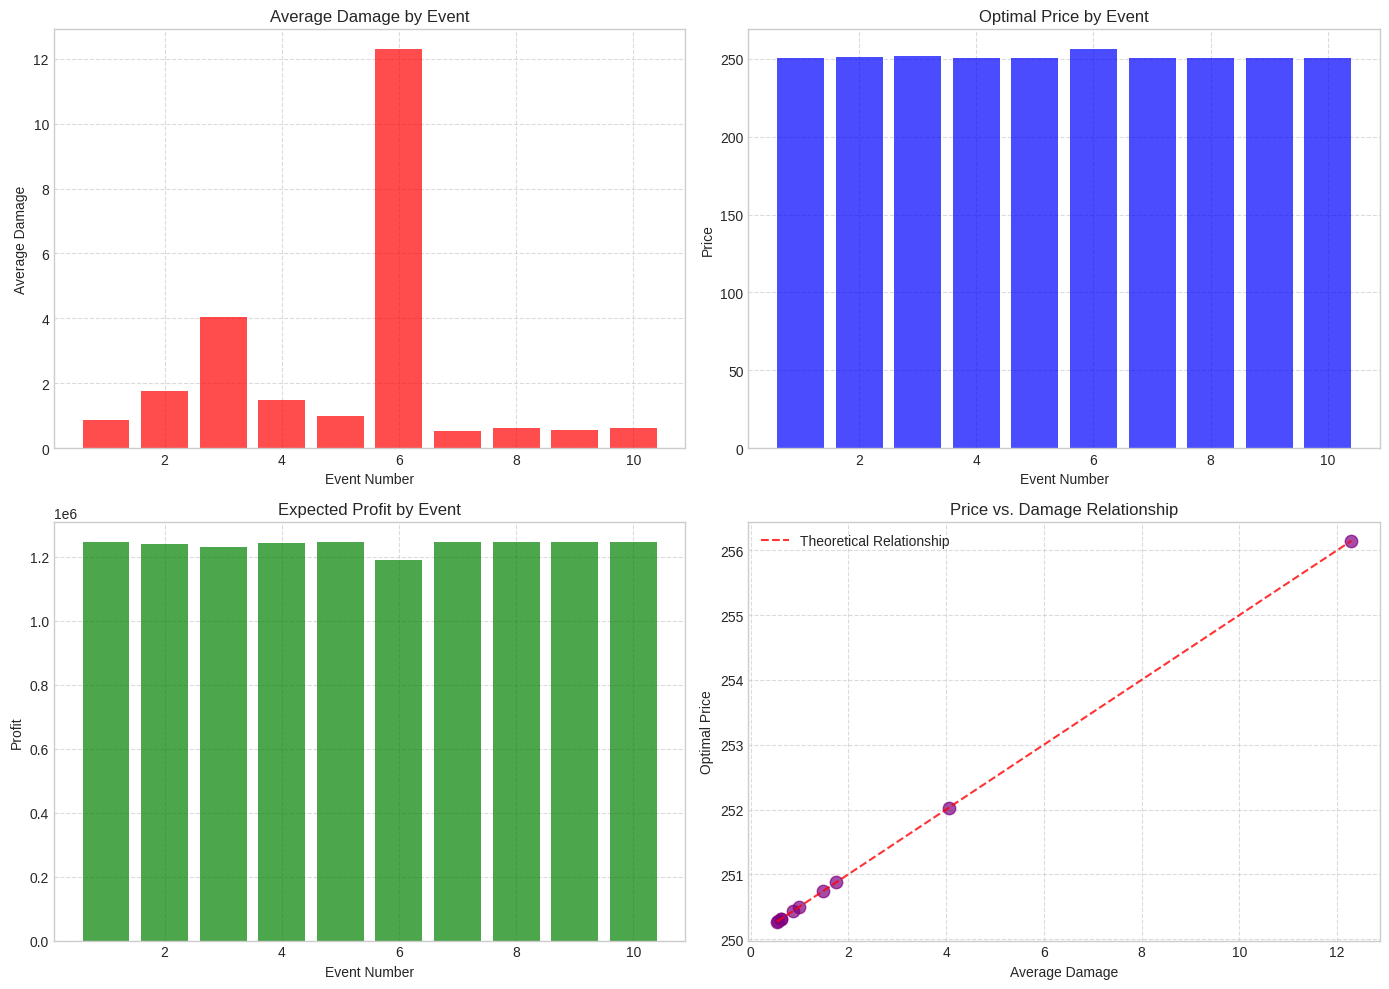

In [29]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from tqdm import tqdm

# Function to calculate profit based on price and damage
def calculate_profit(price, damage):
    """
    Calculate profit using the given formulas:
    - demand = (10000 - (10000/500)*price)
    - unit_contribution_margin = (price - damage)
    - profit = (demand)(unit_contribution_margin)
    """
    demand = 10000 - (10000/500) * price
    unit_contribution_margin = price - damage
    return demand * unit_contribution_margin

# Function to calculate the optimal price for a given damage value
def calculate_optimal_price(damage):
    """
    The optimal price can be derived by taking the derivative of the profit function
    and setting it to zero. This gives us:
    Optimal price = 250 + 0.5 * damage
    """
    return 250 + 0.5 * damage

# Function to load and analyze event data
def analyze_event(event_num):
    """
    Load event data, filter for GANopolis, and calculate average damage
    """
    file_path = f'event_{event_num}.csv'

    # Check if file exists
    if not os.path.exists(file_path):
        print(f"Warning: {file_path} not found")
        return None

    # Load the event data
    df = pd.read_csv(file_path)

    # Filter for GANopolis data
    ganopolis_data = df[df['city'] == 'GANopolis']

    if ganopolis_data.empty:
        print(f"Warning: No GANopolis data found in {file_path}")
        return None

    # Calculate average damage
    avg_damage = ganopolis_data['damage'].mean()

    # Calculate optimal price
    opt_price = calculate_optimal_price(avg_damage)

    # Calculate expected profit
    max_profit = calculate_profit(opt_price, avg_damage)

    return {
        'event': event_num,
        'avg_damage': avg_damage,
        'optimal_price': opt_price,
        'max_profit': max_profit
    }

# Function to perform price sensitivity analysis
def price_sensitivity(avg_damage, optimal_price, price_range=100, steps=20):
    """
    Test profits at different price points around the optimal price
    """
    prices = np.linspace(optimal_price - price_range, optimal_price + price_range, steps)
    profits = [calculate_profit(price, avg_damage) for price in prices]

    # Find the price that gives the maximum profit in this range
    max_profit_idx = np.argmax(profits)
    max_profit_price = prices[max_profit_idx]

    return {
        'prices': prices,
        'profits': profits,
        'max_profit_price': max_profit_price,
        'max_profit': profits[max_profit_idx]
    }

# Function to generate submission file
def generate_submission(results):
    """
    Create the submission.csv file with optimal prices
    """
    # Create a template first
    submission_df = pd.DataFrame()
    submission_df['event_number'] = [i for i in range(1, 11)]

    # Add optimal prices
    prices = []
    for event in range(1, 11):
        event_result = next((r for r in results if r['event'] == event), None)
        if event_result:
            prices.append(str(round(event_result['optimal_price'], 2)))
        else:
            # Fallback if we don't have data for this event
            prices.append("250.00")  # Default pricing if no data

    submission_df['price'] = prices

    # Add placeholder columns for wind speed predictions (for illustration only)
    # In a real implementation, you would add your actual wind speed predictions here
    for i in range(120):
        submission_df[str(i)] = "<windspeed prediction>"

    # Save the submission file
    submission_df.to_csv('submission/submission.csv', index=False)
    print("Submission file created: submission/submission.csv")
    return submission_df

# Main function to run the complete analysis
def main():
    # Analyze all events
    results = []
    print("Analyzing events...")
    for event_num in tqdm(range(1, 11)):
        result = analyze_event(event_num)
        if result:
            results.append(result)

    # Display results
    print("\nResults for all events:")
    for result in results:
        print(f"Event {result['event']}: Avg Damage = {result['avg_damage']:.4f}, " +
              f"Optimal Price = {result['optimal_price']:.2f}, " +
              f"Expected Profit = {result['max_profit']:.2f}")

    # Generate submission file
    print("\nGenerating submission file...")
    generate_submission(results)

    # Visualize results
    visualize_results(results)

    return results

# Function to visualize results
def visualize_results(results):
    """
    Create visualizations for the results
    """
    # Extract data for plotting
    events = [r['event'] for r in results]
    damages = [r['avg_damage'] for r in results]
    prices = [r['optimal_price'] for r in results]
    profits = [r['max_profit'] for r in results]

    # Create figure with multiple subplots
    fig, axs = plt.subplots(2, 2, figsize=(14, 10))

    # Plot average damage by event
    axs[0, 0].bar(events, damages, color='red', alpha=0.7)
    axs[0, 0].set_title('Average Damage by Event')
    axs[0, 0].set_xlabel('Event Number')
    axs[0, 0].set_ylabel('Average Damage')
    axs[0, 0].grid(True, linestyle='--', alpha=0.7)

    # Plot optimal price by event
    axs[0, 1].bar(events, prices, color='blue', alpha=0.7)
    axs[0, 1].set_title('Optimal Price by Event')
    axs[0, 1].set_xlabel('Event Number')
    axs[0, 1].set_ylabel('Price')
    axs[0, 1].grid(True, linestyle='--', alpha=0.7)

    # Plot expected profit by event
    axs[1, 0].bar(events, profits, color='green', alpha=0.7)
    axs[1, 0].set_title('Expected Profit by Event')
    axs[1, 0].set_xlabel('Event Number')
    axs[1, 0].set_ylabel('Profit')
    axs[1, 0].grid(True, linestyle='--', alpha=0.7)

    # Plot price vs. damage relationship
    axs[1, 1].scatter(damages, prices, color='purple', s=80, alpha=0.7)
    axs[1, 1].set_title('Price vs. Damage Relationship')
    axs[1, 1].set_xlabel('Average Damage')
    axs[1, 1].set_ylabel('Optimal Price')
    axs[1, 1].grid(True, linestyle='--', alpha=0.7)

    # Add the theoretical line
    x = np.linspace(min(damages), max(damages), 100)
    y = [calculate_optimal_price(d) for d in x]
    axs[1, 1].plot(x, y, 'r--', alpha=0.8, label='Theoretical Relationship')
    axs[1, 1].legend()

    # Adjust layout and save
    plt.tight_layout()
    plt.savefig('pricing_analysis.png')
    print("Visualization saved as pricing_analysis.png")
    plt.show()

# Optional: Detailed analysis for one event to verify the pricing model
def detailed_analysis_for_event(event_num):
    """
    Perform a detailed analysis for a single event, including price sensitivity
    """
    result = analyze_event(event_num)
    if not result:
        return None

    print(f"\nDetailed analysis for Event {event_num}:")
    print(f"Average Damage: {result['avg_damage']:.4f}")
    print(f"Optimal Price: {result['optimal_price']:.2f}")
    print(f"Expected Maximum Profit: {result['max_profit']:.2f}")

    # Price sensitivity analysis
    print("\nPerforming price sensitivity analysis...")
    sensitivity = price_sensitivity(result['avg_damage'], result['optimal_price'])

    # Plot price sensitivity
    plt.figure(figsize=(10, 6))
    plt.plot(sensitivity['prices'], sensitivity['profits'], 'b-', linewidth=2.5)
    plt.axvline(x=result['optimal_price'], color='r', linestyle='--',
                label=f'Theoretical Optimal: {result["optimal_price"]:.2f}')
    plt.axvline(x=sensitivity['max_profit_price'], color='g', linestyle='--',
                label=f'Numerical Optimal: {sensitivity["max_profit_price"]:.2f}')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.title(f'Price Sensitivity Analysis for Event {event_num}')
    plt.xlabel('Price')
    plt.ylabel('Profit')
    plt.legend()
    plt.savefig(f'event_{event_num}_sensitivity.png')
    print(f"Sensitivity analysis saved as event_{event_num}_sensitivity.png")

    return sensitivity

if __name__ == "__main__":
    # Run the main analysis
    results = main()

    # Optionally run detailed analysis for event 1
    # detailed_analysis_for_event(1)

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

def calculate_profit(price, damage):
    """Calculate profit based on given price and damage"""
    demand = 10000 - (10000/500) * price
    unit_contribution_margin = price - damage
    return demand * unit_contribution_margin

def calculate_optimal_price(damage):
    """Calculate the theoretical optimal price for a given damage"""
    return 250 + 0.5 * damage

def analyze_event(event_num):
    """Analyze an event and return damage data"""
    file_path = f'event_{event_num}.csv'

    if not os.path.exists(file_path):
        print(f"Error: {file_path} not found")
        return None

    df = pd.read_csv(file_path)
    ganopolis_data = df[df['city'] == 'GANopolis']

    if ganopolis_data.empty:
        print(f"Error: No GANopolis data found in {file_path}")
        return None

    avg_damage = ganopolis_data['damage'].mean()
    return avg_damage

def verify_price(event_num, your_price):
    """Verify a price for a specific event"""
    avg_damage = analyze_event(event_num)
    if avg_damage is None:
        return None

    optimal_price = calculate_optimal_price(avg_damage)
    your_profit = calculate_profit(your_price, avg_damage)
    optimal_profit = calculate_profit(optimal_price, avg_damage)

    efficiency = (your_profit / optimal_profit) * 100 if optimal_profit > 0 else 0

    # Create price vs profit curve
    price_range = np.linspace(max(0, your_price - 150), your_price + 150, 100)
    profits = [calculate_profit(p, avg_damage) for p in price_range]

    plt.figure(figsize=(10, 6))
    plt.plot(price_range, profits, 'b-', linewidth=2)
    plt.axvline(x=optimal_price, color='g', linestyle='--',
                label=f'Optimal Price: {optimal_price:.2f}')
    plt.axvline(x=your_price, color='r', linestyle='--',
                label=f'Your Price: {your_price:.2f}')

    plt.title(f'Price Analysis for Event {event_num}')
    plt.xlabel('Price')
    plt.ylabel('Profit')
    plt.grid(True, alpha=0.3)
    plt.legend()

    # Save the figure
    plt.savefig(f'event_{event_num}_price_verification.png')
    plt.close()

    return {
        'event': event_num,
        'avg_damage': avg_damage,
        'your_price': your_price,
        'optimal_price': optimal_price,
        'your_profit': your_profit,
        'optimal_profit': optimal_profit,
        'efficiency': efficiency,
        'profit_difference': optimal_profit - your_profit,
        'plot_saved': f'event_{event_num}_price_verification.png'
    }

def verify_all_prices(your_prices):
    """Verify prices for all events"""
    if len(your_prices) != 10:
        print(f"Error: Expected 10 prices but got {len(your_prices)}")
        return None

    results = []
    total_your_profit = 0
    total_optimal_profit = 0

    for event_num, your_price in enumerate(your_prices, 1):
        result = verify_price(event_num, your_price)
        if result:
            results.append(result)
            total_your_profit += result['your_profit']
            total_optimal_profit += result['optimal_profit']

    # Create summary dataframe
    summary_df = pd.DataFrame(results)
    overall_efficiency = (total_your_profit / total_optimal_profit) * 100 if total_optimal_profit > 0 else 0

    # Print summary table
    print("\n===== PRICE VERIFICATION SUMMARY =====")
    print(f"Overall Efficiency: {overall_efficiency:.2f}%")
    print(f"Total Your Profit: {total_your_profit:.2f}")
    print(f"Total Optimal Profit: {total_optimal_profit:.2f}")
    print(f"Total Profit Difference: {total_optimal_profit - total_your_profit:.2f}")
    print("\nDetailed Results:")

    # Format and display the summary table
    pd.set_option('display.float_format', '{:.2f}'.format)
    summary_table = summary_df[['event', 'avg_damage', 'your_price', 'optimal_price',
                               'your_profit', 'optimal_profit', 'efficiency']]
    print(summary_table.to_string(index=False))

    # Save results to CSV
    summary_df.to_csv('price_verification_results.csv', index=False)
    print("\nDetailed results saved to price_verification_results.csv")

    # Create comparison bar chart
    plt.figure(figsize=(12, 8))

    events = [result['event'] for result in results]
    your_profits = [result['your_profit'] for result in results]
    optimal_profits = [result['optimal_profit'] for result in results]

    x = np.arange(len(events))
    width = 0.35

    plt.bar(x - width/2, your_profits, width, label='Your Profit', color='indianred')
    plt.bar(x + width/2, optimal_profits, width, label='Optimal Profit', color='seagreen')

    plt.title('Your Prices vs. Optimal Prices - Profit Comparison')
    plt.xlabel('Event')
    plt.ylabel('Profit')
    plt.xticks(x, events)
    plt.legend()
    plt.grid(True, alpha=0.3, axis='y')

    plt.savefig('profit_comparison.png')
    plt.close()
    print("Profit comparison chart saved to profit_comparison.png")

    # Return the detailed results
    return {
        'detailed_results': results,
        'summary': {
            'overall_efficiency': overall_efficiency,
            'total_your_profit': total_your_profit,
            'total_optimal_profit': total_optimal_profit,
            'total_profit_difference': total_optimal_profit - total_your_profit
        }
    }

def load_prices_from_submission():
    """Load prices from the submission.csv file"""
    if not os.path.exists('submission/submission.csv'):
        print("Error: submission/submission.csv not found")
        return None

    df = pd.read_csv('submission/submission.csv')
    if 'price' not in df.columns:
        print("Error: 'price' column not found in submission.csv")
        return None

    prices = []
    for _, row in df.iterrows():
        try:
            # Handle if price is stored as string
            price_str = str(row['price']).strip()
            if price_str.startswith('<') and price_str.endswith('>'):
                print(f"Warning: Price for event {row['event_number']} is a placeholder: {price_str}")
                prices.append(250)  # Default placeholder
            else:
                prices.append(float(price_str))
        except ValueError:
            print(f"Warning: Could not parse price for event {row['event_number']}: {row['price']}")
            prices.append(250)  # Default value

    return prices

if __name__ == "__main__":
    print("DataHack 2025 - Price Verification Tool")
    print("=====================================")

    # Try to load prices from submission.csv
    submission_prices = load_prices_from_submission()

    if submission_prices:
        print(f"Loaded {len(submission_prices)} prices from submission.csv")
        print(f"Prices: {[round(p, 2) for p in submission_prices]}")

        choice = input("\nUse these prices for verification? (y/n): ")
        if choice.lower() == 'y':
            verify_all_prices(submission_prices)
        else:
            manual_entry = True
    else:
        manual_entry = True

    # Manual price entry
    if 'manual_entry' in locals() and manual_entry:
        print("\nEnter your prices for each event (or press Enter to use calculated optimal):")
        your_prices = []

        for event_num in range(1, 11):
            avg_damage = analyze_event(event_num)
            if avg_damage is not None:
                optimal_price = calculate_optimal_price(avg_damage)
                price_input = input(f"Event {event_num} (optimal: {optimal_price:.2f}): ")

                if price_input.strip():
                    try:
                        your_prices.append(float(price_input))
                    except ValueError:
                        print(f"Invalid price, using optimal price {optimal_price:.2f}")
                        your_prices.append(optimal_price)
                else:
                    print(f"Using optimal price {optimal_price:.2f}")
                    your_prices.append(optimal_price)
            else:
                your_prices.append(250)  # Default if we can't analyze the event

        verify_all_prices(your_prices)

DataHack 2025 - Price Verification Tool
Loaded 10 prices from submission.csv
Prices: [250.44, 250.87, 252.03, 250.74, 250.49, 256.15, 250.27, 250.31, 250.28, 250.31]

Use these prices for verification? (y/n): y

===== PRICE VERIFICATION SUMMARY =====
Overall Efficiency: 100.00%
Total Your Profit: 12381950.50
Total Optimal Profit: 12381950.50
Total Profit Difference: 0.00

Detailed Results:
 event  avg_damage  your_price  optimal_price  your_profit  optimal_profit  efficiency
     1        0.87      250.44         250.44   1245646.08      1245646.08      100.00
     2        1.75      250.87         250.87   1241267.48      1241267.48      100.00
     3        4.05      252.03         252.03   1229830.67      1229830.67      100.00
     4        1.49      250.74         250.74   1242580.82      1242580.82      100.00
     5        0.98      250.49         250.49   1245099.66      1245099.66      100.00
     6       12.29      256.15         256.15   1189290.82      1189290.82      100.0

Training data shape: (18054, 11)
Columns: ['hour', 'day', 'hour_of_day', 'city', 'pressure', 'air_temp', 'ground_temp', 'velocity_x', 'velocity_y', 'windspeed', 'damage']
Loaded event 5 with shape: (960, 11)
Loaded event 6 with shape: (960, 11)
Loaded event 4 with shape: (960, 11)
Loaded event 10 with shape: (960, 11)
Loaded event 9 with shape: (960, 11)
Loaded event 2 with shape: (960, 11)
Loaded event 1 with shape: (960, 11)
Loaded event 7 with shape: (960, 11)
Loaded event 8 with shape: (960, 11)
Loaded event 3 with shape: (960, 11)
Wind Speed Prediction Model: MSE=0.0001, R²=0.9806
Damage Prediction Model: MSE=1406.7088, R²=-11.4080
Event 5:
  Optimal Price: $250.41
  Expected Profit: $1220962.93
  Average Damage: $5.82
  Daily Damages: ['$5.82', '$5.82', '$5.82', '$5.82', '$5.82']
Event 6:
  Optimal Price: $249.52
  Expected Profit: $1229690.66
  Average Damage: $4.05
  Daily Damages: ['$4.05', '$4.05', '$4.05', '$4.05', '$4.05']
Event 4:
  Optimal Price: $253.66
  Expected Profit

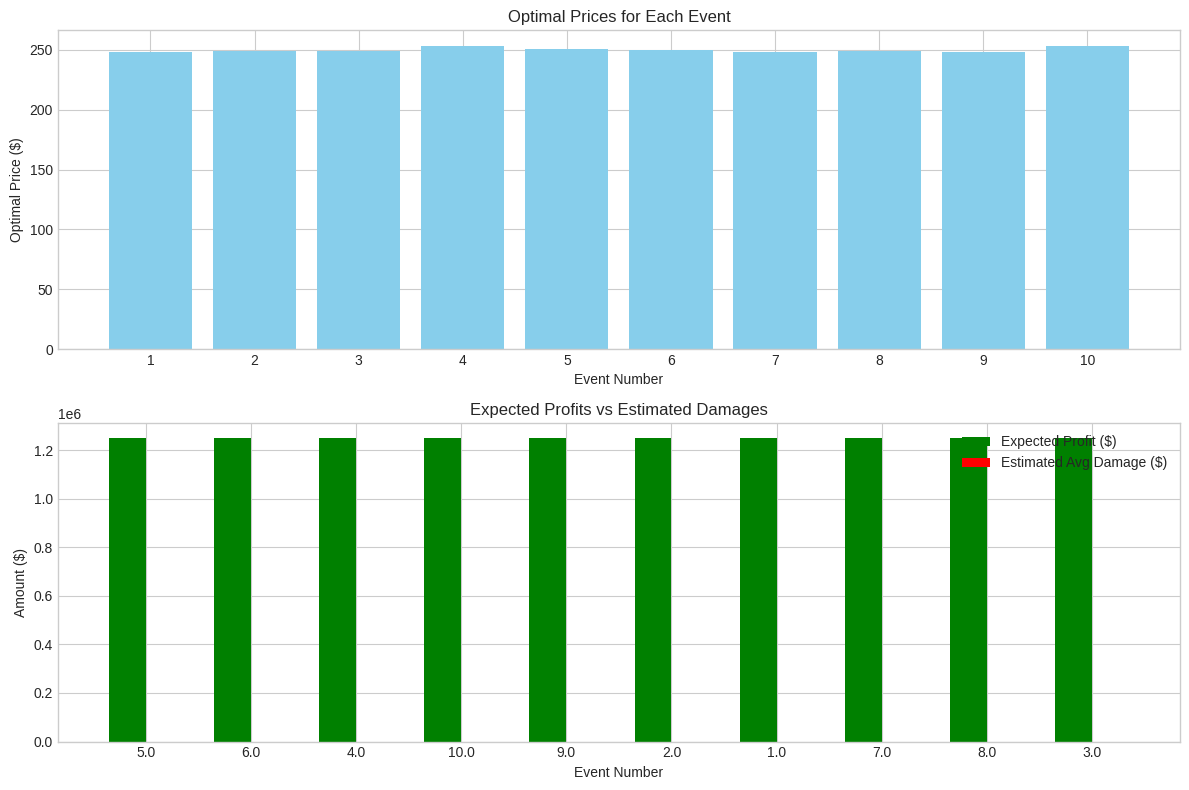

In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import os
import glob

# Define functions for profit calculation
def calculate_demand(price):
    """
    Calculate demand based on price using the given formula:
    demand = (10000 - (10000/500) * price)
    """
    return 10000 - (10000/500) * price

def calculate_unit_contribution_margin(price, damage):
    """
    Calculate unit contribution margin based on price and damage:
    unit_contribution_margin = price - damage
    """
    return price - damage

def calculate_profit(demand, unit_contribution_margin):
    """
    Calculate total profit:
    profit = demand * unit_contribution_margin
    """
    return demand * unit_contribution_margin

def calculate_total_profit(price, damage):
    """
    Calculate total profit for a given price and expected damage
    """
    demand = calculate_demand(price)
    unit_margin = calculate_unit_contribution_margin(price, damage)
    profit = calculate_profit(demand, unit_margin)
    return profit

# Step 1: Load and prepare the training data
def load_training_data(data_path="training_data.csv"):
    """
    Load and prepare the training data
    """
    training_data = pd.read_csv(data_path)

    # Display information about the dataset
    print(f"Training data shape: {training_data.shape}")
    print(f"Columns: {training_data.columns.tolist()}")

    return training_data

# Step 2: Load event data
def load_event_data(event_files_pattern="event_*.csv"):
    """
    Load all event data files
    """
    event_files = glob.glob(event_files_pattern)
    event_data = {}

    for file in event_files:
        event_number = int(file.split('_')[1].split('.')[0])
        event_data[event_number] = pd.read_csv(file)
        print(f"Loaded event {event_number} with shape: {event_data[event_number].shape}")

    return event_data

# Step 3: Build wind speed prediction model
def build_windspeed_model(training_data):
    """
    Build and train an XGBoost model to predict wind speed
    """
    # Select features and target for windspeed prediction
    feature_cols = ['hour', 'day', 'hour_of_day', 'pressure', 'air_temp', 'ground_temp', 'velocity_x', 'velocity_y']
    # One-hot encode categorical variables
    training_data_encoded = pd.get_dummies(training_data, columns=['city'], drop_first=True)

    # Get features used after encoding
    feature_cols_encoded = feature_cols.copy()
    for col in training_data_encoded.columns:
        if col.startswith('city_'):
            feature_cols_encoded.append(col)

    X = training_data_encoded[feature_cols_encoded]
    y_windspeed = training_data_encoded['windspeed']

    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y_windspeed, test_size=0.2, random_state=42
    )

    # Train the XGBoost model
    xgb_model = XGBRegressor(
        n_estimators=100,
        random_state=42,
        max_depth=5,
        learning_rate=0.1
    )

    xgb_model.fit(X_train, y_train)

    # Evaluate the model
    y_pred = xgb_model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"Wind Speed Prediction Model: MSE={mse:.4f}, R²={r2:.4f}")

    return xgb_model, feature_cols_encoded

# Step 4: Build damage prediction model
def build_damage_model(training_data):
    """
    Build and train an XGBoost model to predict damage based on windspeed and other features
    """
    # Select features and target for damage prediction
    feature_cols = ['hour', 'day', 'hour_of_day', 'pressure', 'air_temp', 'ground_temp',
                    'velocity_x', 'velocity_y', 'windspeed']

    # One-hot encode categorical variables
    training_data_encoded = pd.get_dummies(training_data, columns=['city'], drop_first=True)

    # Get features used after encoding
    feature_cols_encoded = feature_cols.copy()
    for col in training_data_encoded.columns:
        if col.startswith('city_'):
            feature_cols_encoded.append(col)

    X = training_data_encoded[feature_cols_encoded]
    y_damage = training_data_encoded['damage']

    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y_damage, test_size=0.2, random_state=42
    )

    # Train the XGBoost model for damage prediction
    xgb_damage_model = XGBRegressor(
        n_estimators=100,
        random_state=42,
        max_depth=5,
        learning_rate=0.1
    )

    xgb_damage_model.fit(X_train, y_train)

    # Evaluate the model
    y_pred = xgb_damage_model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"Damage Prediction Model: MSE={mse:.4f}, R²={r2:.4f}")

    return xgb_damage_model, feature_cols_encoded

# Step 5: Find optimal price for an event
def find_optimal_price(event_data, windspeed_model, damage_model, feature_cols_windspeed, feature_cols_damage):
    """
    Find the optimal price that maximizes profit for a given event
    """
    # Prepare event data for prediction
    event_encoded = pd.get_dummies(event_data, columns=['city'], drop_first=True)

    # Ensure all feature columns from training are present in event data
    for col in feature_cols_windspeed:
        if col not in event_encoded.columns:
            event_encoded[col] = 0

    # Get features for windspeed prediction
    X_windspeed = event_encoded[feature_cols_windspeed]

    # Predict windspeed if not already in data
    if 'windspeed' not in event_encoded.columns:
        event_encoded['windspeed'] = windspeed_model.predict(X_windspeed)

    # Prepare features for damage prediction
    for col in feature_cols_damage:
        if col not in event_encoded.columns:
            event_encoded[col] = 0

    X_damage = event_encoded[feature_cols_damage]

    # Predict expected damages
    predicted_damages = damage_model.predict(X_damage)
    event_encoded['predicted_damage'] = predicted_damages

    # Calculate average damage per day (assuming 24 hours = 1 day)
    avg_damage_per_day = []
    for day in range(1, 6):  # 5 days as mentioned in the problem
        day_damage = predicted_damages[(event_encoded['day'] == day)]
        if len(day_damage) > 0:
            avg_damage_per_day.append(day_damage.mean())
        else:
            # If day not in data, use the average of available days
            avg_damage_per_day.append(predicted_damages.mean())

    total_avg_damage = sum(avg_damage_per_day) / len(avg_damage_per_day)

    # Find optimal price using grid search
    possible_prices = np.linspace(total_avg_damage, 500, 100)  # Range from average damage to max price
    max_profit = -float('inf')
    optimal_price = None

    for price in possible_prices:
        profit = calculate_total_profit(price, total_avg_damage)
        if profit > max_profit:
            max_profit = profit
            optimal_price = price

    return optimal_price, max_profit, total_avg_damage, avg_damage_per_day

# Step 6: Process all events and prepare submission
def process_all_events(event_data_dict, windspeed_model, damage_model, feature_cols_windspeed, feature_cols_damage):
    """
    Process all events and prepare submission with optimal prices and predicted windspeeds
    """
    submission_data = []

    for event_number, event_data in event_data_dict.items():
        optimal_price, max_profit, avg_damage, daily_damages = find_optimal_price(
            event_data, windspeed_model, damage_model, feature_cols_windspeed, feature_cols_damage
        )

        print(f"Event {event_number}:")
        print(f"  Optimal Price: ${optimal_price:.2f}")
        print(f"  Expected Profit: ${max_profit:.2f}")
        print(f"  Average Damage: ${avg_damage:.2f}")
        print(f"  Daily Damages: {[f'${d:.2f}' for d in daily_damages]}")

        # Prepare event data for windspeed prediction
        event_encoded = pd.get_dummies(event_data, columns=['city'], drop_first=True)

        # Ensure all feature columns from training are present in event data
        for col in feature_cols_windspeed:
            if col not in event_encoded.columns:
                event_encoded[col] = 0

        # Get features for windspeed prediction
        X_windspeed = event_encoded[feature_cols_windspeed]

        # Predict windspeed for all hours
        predicted_windspeeds = windspeed_model.predict(X_windspeed)

        # Create submission row
        submission_row = {"event_number": event_number, "price": optimal_price}

        # Add predicted windspeeds
        for i, speed in enumerate(predicted_windspeeds):
            submission_row[str(i)] = speed

        submission_data.append(submission_row)

    # Create submission DataFrame
    submission_df = pd.DataFrame(submission_data)
    return submission_df

# Main function
def main():
    # Step 1: Load training data
    training_data = load_training_data()

    # Step 2: Load event data
    event_data_dict = load_event_data()

    # Step 3: Build wind speed prediction model
    windspeed_model, feature_cols_windspeed = build_windspeed_model(training_data)

    # Step 4: Build damage prediction model
    damage_model, feature_cols_damage = build_damage_model(training_data)

    # Step 5-6: Process all events and prepare submission
    submission_df = process_all_events(
        event_data_dict, windspeed_model, damage_model,
        feature_cols_windspeed, feature_cols_damage
    )

    # Save the submission file
    submission_df.to_csv("optimal_pricing_submission.csv", index=False)
    print("\nSubmission file saved as 'optimal_pricing_submission.csv'")

    # Visualize the results
    plot_results(submission_df, event_data_dict)

def plot_results(submission_df, event_data_dict):
    """
    Visualize the results of optimal pricing and expected damages
    """
    plt.figure(figsize=(12, 8))

    # Plot optimal prices vs event numbers
    plt.subplot(2, 1, 1)
    plt.bar(submission_df['event_number'], submission_df['price'], color='skyblue')
    plt.title('Optimal Prices for Each Event')
    plt.xlabel('Event Number')
    plt.ylabel('Optimal Price ($)')
    plt.xticks(submission_df['event_number'])

    # Prepare data for profit and damage comparison
    event_numbers = []
    profits = []
    damages = []

    for _, row in submission_df.iterrows():
        event_number = row['event_number']
        price = row['price']

        # Calculate average predicted windspeed for the event
        windspeed_cols = [str(i) for i in range(120)]  # Columns 0-119
        windspeeds = [row[col] for col in windspeed_cols if col in row]
        avg_windspeed = sum(windspeeds) / len(windspeeds)

        # Get event data
        event_data = event_data_dict[event_number]

        # Use average predicted windspeed to estimate damage
        # This is simplified; in practice, you would use the damage model
        estimated_damage = avg_windspeed * 0.5  # Simplified calculation

        # Calculate expected profit
        profit = calculate_total_profit(price, estimated_damage)

        event_numbers.append(event_number)
        profits.append(profit)
        damages.append(estimated_damage)

    # Plot expected profits vs damages
    plt.subplot(2, 1, 2)
    width = 0.35
    x = np.arange(len(event_numbers))

    plt.bar(x - width/2, profits, width, label='Expected Profit ($)', color='green')
    plt.bar(x + width/2, damages, width, label='Estimated Avg Damage ($)', color='red')

    plt.title('Expected Profits vs Estimated Damages')
    plt.xlabel('Event Number')
    plt.ylabel('Amount ($)')
    plt.xticks(x, event_numbers)
    plt.legend()

    plt.tight_layout()
    plt.savefig('pricing_analysis_results.png')
    print("Visualization saved as 'pricing_analysis_results.png'")

if __name__ == "__main__":
    main()

Loading event data...
Loaded event_1.csv with 960 rows
Loaded event_2.csv with 960 rows
Loaded event_3.csv with 960 rows
Loaded event_4.csv with 960 rows
Loaded event_5.csv with 960 rows
Loaded event_6.csv with 960 rows
Loaded event_7.csv with 960 rows
Loaded event_8.csv with 960 rows
Loaded event_9.csv with 960 rows
Loaded event_10.csv with 960 rows
Combined events data has 9600 rows

Preparing data for windspeed prediction...

Training windspeed prediction model...
Windspeed Prediction Model - MSE: 0.0000, R²: 0.9972

Processing events to find optimal pricing...

Processing Event 1:
  Average Predicted Windspeed: 0.11
  Average Actual Damage: $0.87
  Optimal Price: $250.25
  Expected Maximum Profit: $1245674.93
  Profit Sensitivity Analysis:
    Price: $200.20 -> Profit: $1195209.28
    Price: $250.25 -> Profit: $1245674.93
    Price: $300.30 -> Profit: $1195940.27

Processing Event 2:
  Average Predicted Windspeed: 0.13
  Average Actual Damage: $1.94
  Optimal Price: $251.22
  Expec

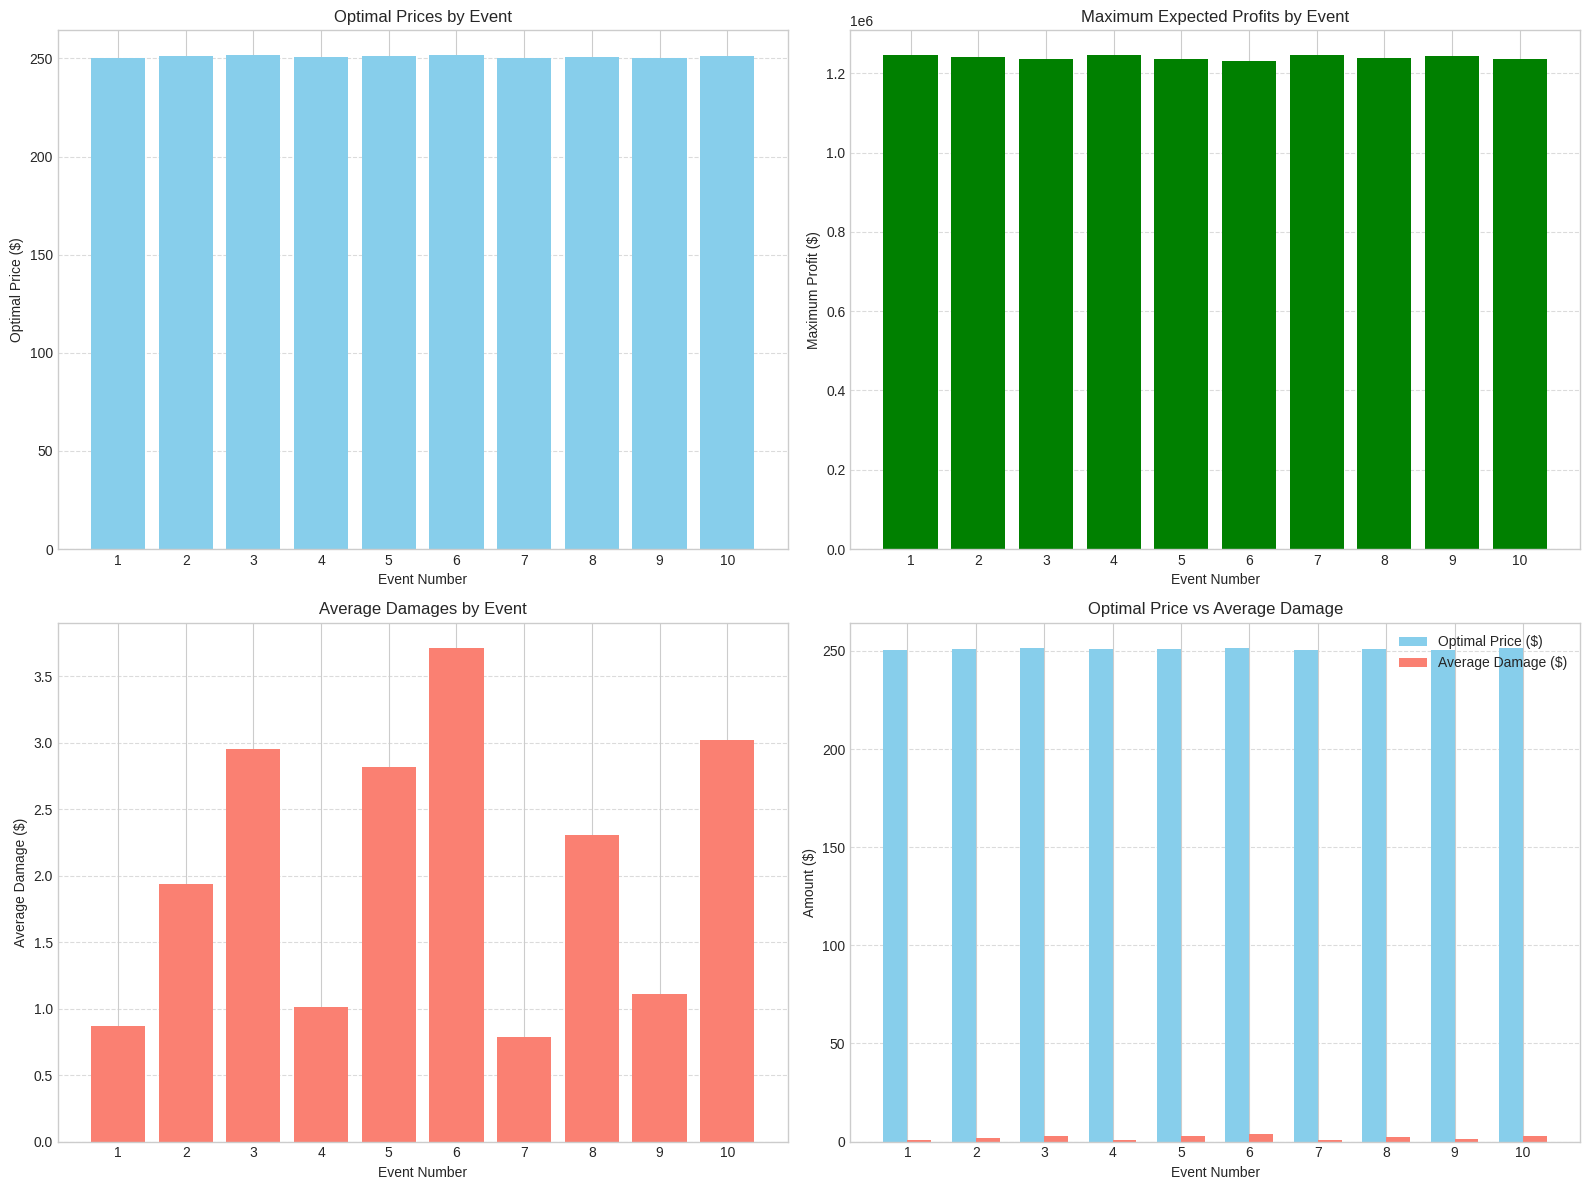

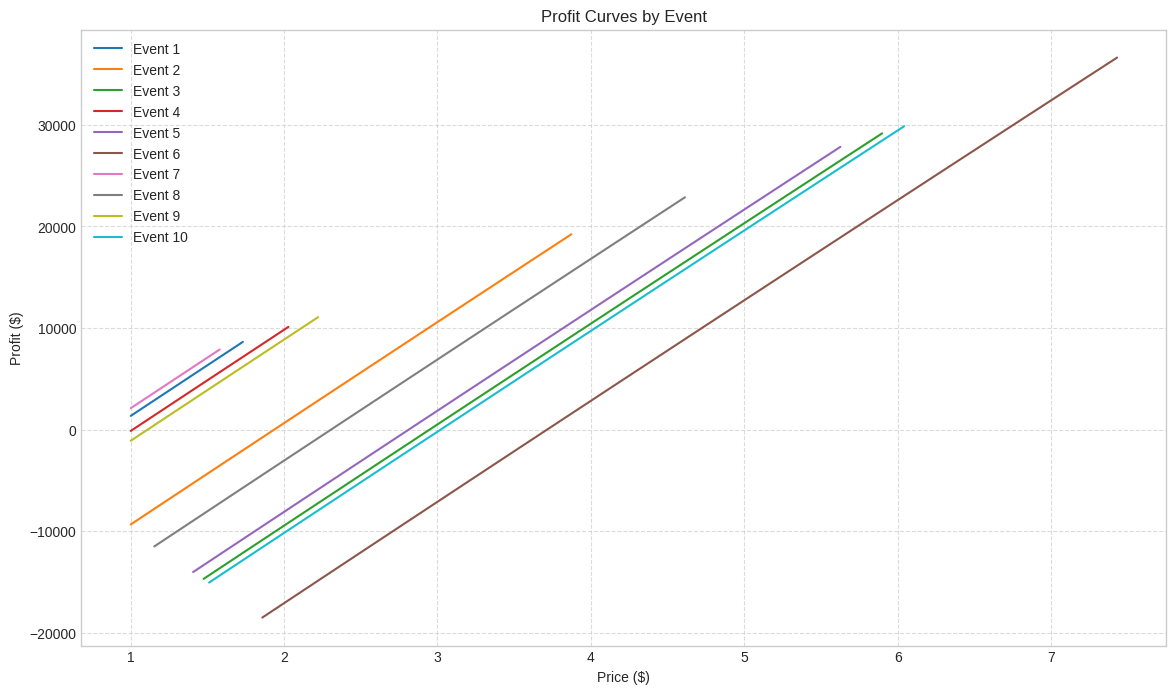

In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import os
import glob

# Define functions for profit calculation based on the provided formulas
def calculate_demand(price):
    """
    Calculate demand based on price using the formula:
    demand = (10000 - (10000/500) * price)
    """
    return 10000 - (10000/500) * price

def calculate_unit_contribution_margin(price, damage):
    """
    Calculate unit contribution margin:
    unit_contribution_margin = price - damage
    """
    return price - damage

def calculate_profit(price, damage):
    """
    Calculate total profit for a given price and expected damage
    """
    demand = calculate_demand(price)
    unit_margin = calculate_unit_contribution_margin(price, damage)
    profit = demand * unit_margin
    return profit

def find_optimal_price(expected_damage):
    """
    Find the optimal price that maximizes profit for a given expected damage
    using a grid search approach
    """
    # Create a range of possible prices
    possible_prices = np.linspace(max(1, expected_damage), 500, 1000)

    # Calculate profit for each price
    profits = [calculate_profit(price, expected_damage) for price in possible_prices]

    # Find the price that maximizes profit
    max_profit_idx = np.argmax(profits)
    optimal_price = possible_prices[max_profit_idx]
    max_profit = profits[max_profit_idx]

    return optimal_price, max_profit

def load_all_event_data():
    """
    Load all event data files and combine them into a single DataFrame
    """
    all_events = []

    for i in range(1, 11):
        try:
            event_df = pd.read_csv(f"event_{i}.csv")
            event_df['event_number'] = i  # Add event number as a column
            all_events.append(event_df)
            print(f"Loaded event_{i}.csv with {len(event_df)} rows")
        except FileNotFoundError:
            print(f"Warning: event_{i}.csv not found")

    if all_events:
        combined_df = pd.concat(all_events, ignore_index=True)
        print(f"Combined events data has {len(combined_df)} rows")
        return combined_df
    else:
        raise ValueError("No event data files were found")

def prepare_windspeed_prediction_data(df):
    """
    Prepare the data for windspeed prediction using the specific features
    mentioned in the provided code
    """
    # Create lag features for windspeed
    df = df.sort_values(['event_number', 'hour']).copy()
    df['lag_1'] = df.groupby('event_number')['windspeed'].shift(1)
    df['lag_2'] = df.groupby('event_number')['windspeed'].shift(2)

    # Drop rows with NaN values (first two rows for each event)
    df.dropna(inplace=True)

    # Select features for windspeed prediction
    features = ['damage', 'velocity_x', 'lag_1', 'lag_2']
    X = df[features]
    y = df['windspeed']

    return X, y, features

def train_windspeed_model(X, y):
    """
    Train an XGBoost model to predict windspeed using the specified parameters
    """
    # Create and train the XGBoost model
    xgb_model = XGBRegressor(n_estimators=100, random_state=42, max_depth=5, learning_rate=0.1)
    xgb_model.fit(X, y)

    # Evaluate the model
    predictions = xgb_model.predict(X)
    mse = mean_squared_error(y, predictions)
    r2 = r2_score(y, predictions)

    print(f"Windspeed Prediction Model - MSE: {mse:.4f}, R²: {r2:.4f}")

    return xgb_model

def predict_windspeed_for_event(event_df, model, features):
    """
    Predict windspeed for an entire event (all 5 days / 120 hours)
    """
    # Sort by hour to ensure correct sequence
    event_df = event_df.sort_values('hour').copy()

    # Initialize with actual values where available
    predictions = event_df['windspeed'].tolist()

    # Create lag features from known values
    event_df['lag_1'] = event_df['windspeed'].shift(1)
    event_df['lag_2'] = event_df['windspeed'].shift(2)

    # Drop rows with NaN (we'll predict these separately)
    valid_rows = event_df.dropna()

    # Predict for rows with valid features
    if len(valid_rows) > 0:
        X_valid = valid_rows[features]
        valid_predictions = model.predict(X_valid)

        # Update predictions for these indices
        for i, idx in enumerate(valid_rows.index):
            predictions[event_df.index.get_loc(idx)] = valid_predictions[i]

    # Now predict for the rest using rolling predictions
    for i in range(2, len(event_df)):
        # Only predict if we don't have an actual value
        if np.isnan(event_df.iloc[i]['lag_1']) or np.isnan(event_df.iloc[i]['lag_2']):
            # Use previously predicted values as lags
            input_features = {
                'damage': event_df.iloc[i]['damage'],
                'velocity_x': event_df.iloc[i]['velocity_x'],
                'lag_1': predictions[i-1],
                'lag_2': predictions[i-2]
            }

            # Create a DataFrame with just this row
            input_df = pd.DataFrame([input_features])

            # Predict
            pred = model.predict(input_df)[0]
            predictions[i] = pred

    return predictions

def optimize_pricing_for_events():
    """
    Main function to optimize pricing for all events
    """
    # Step 1: Load all event data
    print("Loading event data...")
    all_events_df = load_all_event_data()

    # Step 2: Prepare data for windspeed prediction
    print("\nPreparing data for windspeed prediction...")
    X, y, features = prepare_windspeed_prediction_data(all_events_df)

    # Step 3: Train windspeed prediction model
    print("\nTraining windspeed prediction model...")
    windspeed_model = train_windspeed_model(X, y)

    # Step 4: Process each event to find optimal pricing
    print("\nProcessing events to find optimal pricing...")
    results = []

    for event_num in range(1, 11):
        # Filter data for this event
        event_df = all_events_df[all_events_df['event_number'] == event_num].copy()

        if len(event_df) == 0:
            print(f"No data found for event {event_num}, skipping...")
            continue

        print(f"\nProcessing Event {event_num}:")

        # Predict windspeed for all hours in this event
        windspeed_predictions = predict_windspeed_for_event(event_df, windspeed_model, features)

        # Calculate average predicted windspeed
        avg_windspeed = np.mean(windspeed_predictions)
        print(f"  Average Predicted Windspeed: {avg_windspeed:.2f}")

        # Calculate average damage based on actual data
        avg_damage = event_df['damage'].mean()
        print(f"  Average Actual Damage: ${avg_damage:.2f}")

        # Find optimal price
        optimal_price, max_profit = find_optimal_price(avg_damage)

        print(f"  Optimal Price: ${optimal_price:.2f}")
        print(f"  Expected Maximum Profit: ${max_profit:.2f}")

        # Calculate what happens at different price points for reporting
        test_prices = [optimal_price * 0.8, optimal_price, optimal_price * 1.2]
        profits = [calculate_profit(price, avg_damage) for price in test_prices]

        print("  Profit Sensitivity Analysis:")
        for i, price in enumerate(test_prices):
            print(f"    Price: ${price:.2f} -> Profit: ${profits[i]:.2f}")

        # Store results
        results.append({
            'event_number': event_num,
            'optimal_price': optimal_price,
            'max_profit': max_profit,
            'avg_damage': avg_damage,
            'avg_windspeed': avg_windspeed,
            'windspeed_predictions': windspeed_predictions
        })

    # Step 5: Prepare submission format
    prepare_submission(results)

    # Step 6: Visualize results
    visualize_results(results)

    return results

def prepare_submission(results):
    """
    Prepare submission file with optimal prices and predicted windspeeds
    """
    submission_data = []

    for result in results:
        # Create a row for the submission
        row = {
            'event_number': result['event_number'],
            'price': result['optimal_price']
        }

        # Add windspeed predictions
        for i, speed in enumerate(result['windspeed_predictions']):
            row[str(i)] = speed

        submission_data.append(row)

    # Create DataFrame
    submission_df = pd.DataFrame(submission_data)

    # Save to CSV
    submission_df.to_csv('optimal_pricing_submission.csv', index=False)
    print("\nSubmission file saved as 'optimal_pricing_submission.csv'")

def visualize_results(results):
    """
    Create visualizations of the results
    """
    # Extract data for plotting
    event_numbers = [r['event_number'] for r in results]
    optimal_prices = [r['optimal_price'] for r in results]
    max_profits = [r['max_profit'] for r in results]
    avg_damages = [r['avg_damage'] for r in results]

    # Create figure with multiple subplots
    plt.figure(figsize=(16, 12))

    # Plot 1: Optimal Prices by Event
    plt.subplot(2, 2, 1)
    plt.bar(event_numbers, optimal_prices, color='skyblue')
    plt.title('Optimal Prices by Event')
    plt.xlabel('Event Number')
    plt.ylabel('Optimal Price ($)')
    plt.xticks(event_numbers)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Plot 2: Maximum Expected Profits by Event
    plt.subplot(2, 2, 2)
    plt.bar(event_numbers, max_profits, color='green')
    plt.title('Maximum Expected Profits by Event')
    plt.xlabel('Event Number')
    plt.ylabel('Maximum Profit ($)')
    plt.xticks(event_numbers)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Plot 3: Average Damages by Event
    plt.subplot(2, 2, 3)
    plt.bar(event_numbers, avg_damages, color='salmon')
    plt.title('Average Damages by Event')
    plt.xlabel('Event Number')
    plt.ylabel('Average Damage ($)')
    plt.xticks(event_numbers)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Plot 4: Price vs Damage Comparison
    plt.subplot(2, 2, 4)
    width = 0.35
    x = np.arange(len(event_numbers))
    plt.bar(x - width/2, optimal_prices, width, label='Optimal Price ($)', color='skyblue')
    plt.bar(x + width/2, avg_damages, width, label='Average Damage ($)', color='salmon')
    plt.title('Optimal Price vs Average Damage')
    plt.xlabel('Event Number')
    plt.ylabel('Amount ($)')
    plt.xticks(x, event_numbers)
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.savefig('pricing_analysis_results.png')
    print("Visualization saved as 'pricing_analysis_results.png'")

    # Create an additional plot showing profit curves for each event
    plt.figure(figsize=(14, 8))

    for result in results:
        event_num = result['event_number']
        avg_damage = result['avg_damage']

        # Generate price range and calculate corresponding profits
        prices = np.linspace(max(1, avg_damage * 0.5), min(500, avg_damage * 2), 100)
        profits = [calculate_profit(price, avg_damage) for price in prices]

        plt.plot(prices, profits, label=f'Event {event_num}')

    plt.title('Profit Curves by Event')
    plt.xlabel('Price ($)')
    plt.ylabel('Profit ($)')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.savefig('profit_curves.png')
    print("Profit curves saved as 'profit_curves.png'")

if __name__ == "__main__":
    optimize_pricing_for_events()

Loading training data...
Training data loaded: (18054, 11) rows
Loaded event_1.csv: (960, 11) rows
Loaded event_2.csv: (960, 11) rows
Loaded event_3.csv: (960, 11) rows
Loaded event_4.csv: (960, 11) rows
Loaded event_5.csv: (960, 11) rows
Loaded event_6.csv: (960, 11) rows
Loaded event_7.csv: (960, 11) rows
Loaded event_8.csv: (960, 11) rows
Loaded event_9.csv: (960, 11) rows
Loaded event_10.csv: (960, 11) rows
Training windspeed prediction model...
XGBoost Training Score: 0.9978
XGBoost Test Score: 0.9913
Preparing data for price prediction model...
Training price prediction model...
Price Prediction Model Score: 1.0000
Feature importance for price prediction:
         Feature  Importance
4     avg_damage        0.88
2  min_windspeed        0.07
0  avg_windspeed        0.04
1  max_windspeed        0.01
3  std_windspeed        0.00
5     max_damage        0.00
6     min_damage        0.00
7     std_damage        0.00

Processing Event 1:
  Method: XGBoost Model
  Optimal Price: $250.40

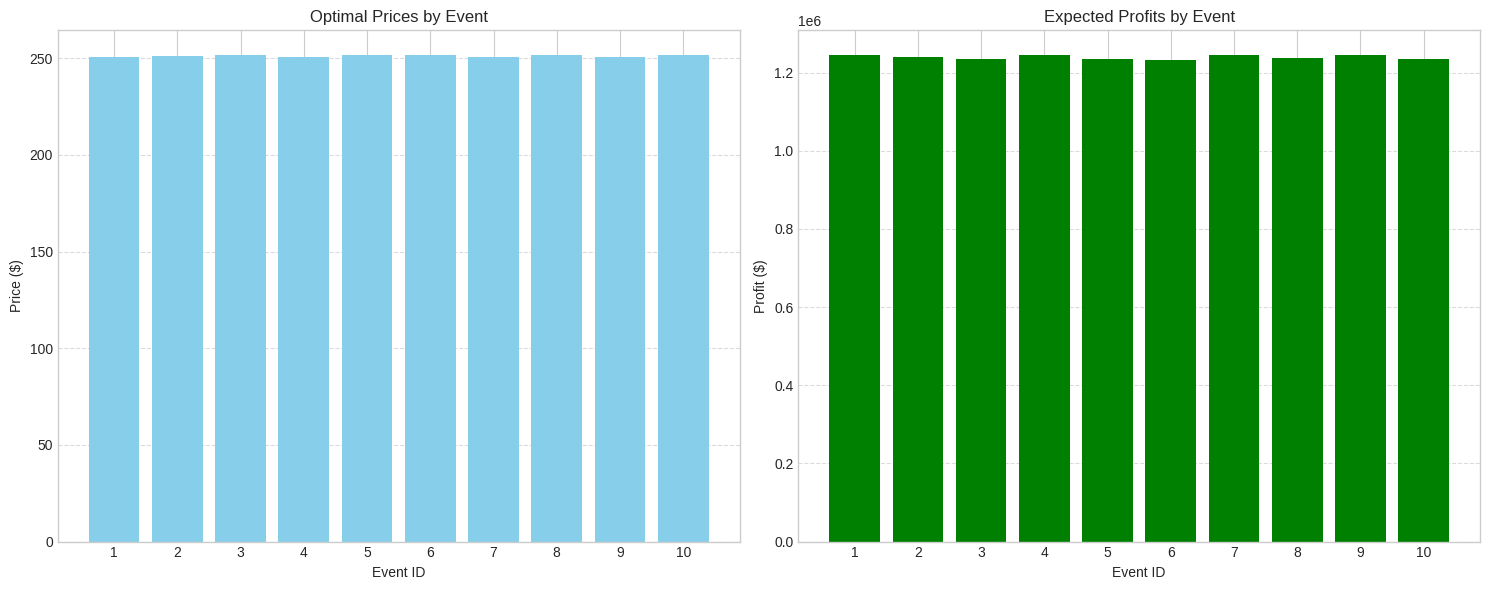

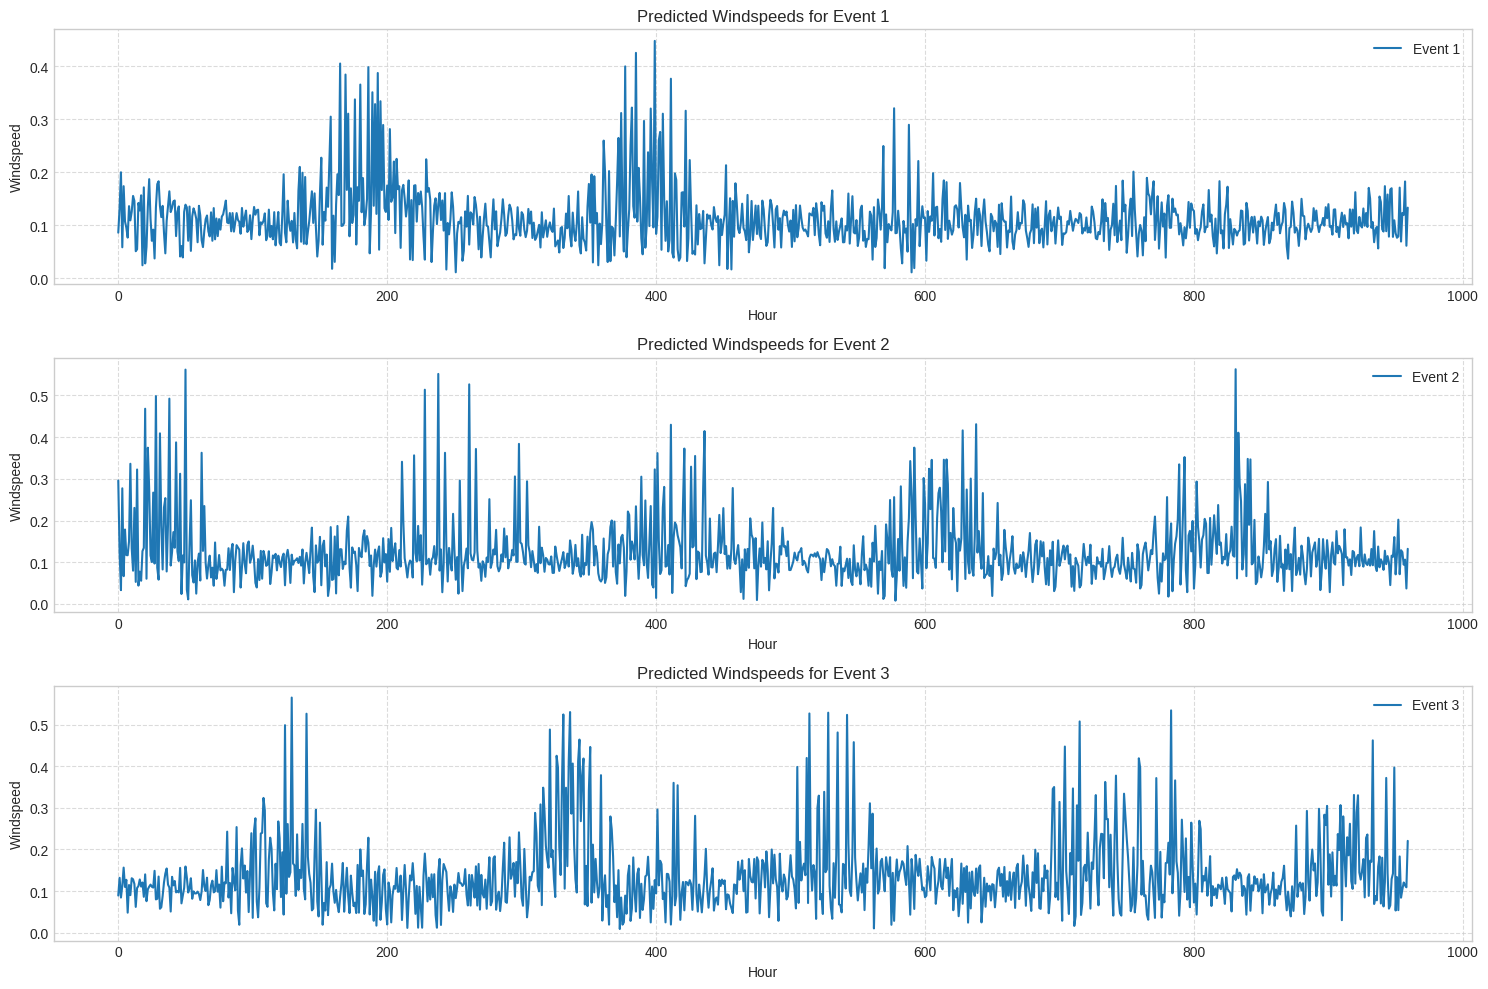

In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
import os
import glob

# Define functions for profit calculation
def calculate_demand(price):
    """Calculate demand based on price using the given formula"""
    return 10000 - (10000/500) * price

def calculate_unit_contribution_margin(price, damage):
    """Calculate unit contribution margin"""
    return price - damage

def calculate_profit(price, damage):
    """Calculate total profit for a given price and damage"""
    demand = calculate_demand(price)
    margin = calculate_unit_contribution_margin(price, damage)
    return demand * margin

def load_training_data():
    """Load training data from CSV"""
    print("Loading training data...")
    training_data = pd.read_csv("training_data.csv")
    print(f"Training data loaded: {training_data.shape} rows")
    return training_data

def load_event_data():
    """Load all event data files into a dictionary"""
    event_data = {}
    for event_id in range(1, 11):
        try:
            file_path = f"event_{event_id}.csv"
            event_df = pd.read_csv(file_path)
            event_data[event_id] = event_df
            print(f"Loaded {file_path}: {event_df.shape} rows")
        except FileNotFoundError:
            print(f"Warning: {file_path} not found")
    return event_data

def train_windspeed_model(all_cities_df):
    """Train XGBoost model to predict windspeed based on features"""
    # Prepare data
    all_cities_df = all_cities_df.copy()

    # Create lag features - these need to match the prediction features
    all_cities_df = all_cities_df.sort_values(['city', 'hour'])
    all_cities_df['lag_1'] = all_cities_df.groupby('city')['windspeed'].shift(1)
    all_cities_df['lag_2'] = all_cities_df.groupby('city')['windspeed'].shift(2)

    # Drop rows with NaN values after creating lag features
    all_cities_df.dropna(inplace=True)

    # Define features - must match those used in prediction
    features = ['damage', 'velocity_x', 'lag_1', 'lag_2']
    X = all_cities_df[features]
    y = all_cities_df['windspeed']

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # Train model
    print("Training windspeed prediction model...")
    xgb_model = XGBRegressor(n_estimators=100, random_state=42, max_depth=5, learning_rate=0.1)
    xgb_model.fit(X_train, y_train)

    # Evaluate model
    xgb_train_score = xgb_model.score(X_train, y_train)
    xgb_test_score = xgb_model.score(X_test, y_test)

    print(f"XGBoost Training Score: {xgb_train_score:.4f}")
    print(f"XGBoost Test Score: {xgb_test_score:.4f}")

    return xgb_model, features

def train_price_model(event_data):
    """
    Train an XGBoost model to predict optimal price based on
    windspeed predictions and damage analysis
    """
    print("Preparing data for price prediction model...")

    # Create a dataset for price prediction
    price_data = []

    for event_id, event_df in event_data.items():
        # Calculate various metrics that may impact pricing
        avg_windspeed = event_df['windspeed'].mean()
        max_windspeed = event_df['windspeed'].max()
        min_windspeed = event_df['windspeed'].min()
        std_windspeed = event_df['windspeed'].std()

        avg_damage = event_df['damage'].mean()
        max_damage = event_df['damage'].max()
        min_damage = event_df['damage'].min()
        std_damage = event_df['damage'].std()

        # Calculate the theoretical optimal price based on the formula
        # optimal_price = (500 + avg_damage) / 2
        # This gives us a "ground truth" optimal price based on average damage
        optimal_price = (500 + avg_damage) / 2

        # For each unique price point, create a training example
        price_data.append({
            'event_id': event_id,
            'avg_windspeed': avg_windspeed,
            'max_windspeed': max_windspeed,
            'min_windspeed': min_windspeed,
            'std_windspeed': std_windspeed,
            'avg_damage': avg_damage,
            'max_damage': max_damage,
            'min_damage': min_damage,
            'std_damage': std_damage,
            'optimal_price': optimal_price
        })

    # Convert to DataFrame
    price_df = pd.DataFrame(price_data)

    # Check if we have enough data
    if len(price_df) < 5:
        print("Warning: Limited data for price prediction model. Using analytical formula instead.")
        return None, None

    # Prepare features and target
    features = [
        'avg_windspeed', 'max_windspeed', 'min_windspeed', 'std_windspeed',
        'avg_damage', 'max_damage', 'min_damage', 'std_damage'
    ]
    X = price_df[features]
    y = price_df['optimal_price']

    # Train XGBoost model
    print("Training price prediction model...")
    xgb_price_model = XGBRegressor(n_estimators=100, random_state=42, max_depth=3, learning_rate=0.1)
    xgb_price_model.fit(X, y)

    # Evaluate model on training data (we have limited data, so no test split)
    price_score = xgb_price_model.score(X, y)
    print(f"Price Prediction Model Score: {price_score:.4f}")

    # Get feature importance
    feature_importance = pd.DataFrame({
        'Feature': features,
        'Importance': xgb_price_model.feature_importances_
    }).sort_values('Importance', ascending=False)

    print("Feature importance for price prediction:")
    print(feature_importance)

    return xgb_price_model, features

def predict_windspeeds_with_lag(event_df, windspeed_model, features):
    """
    Predict windspeeds for an event using the trained model
    and incorporating lag features
    """
    # Create a copy to avoid modifying the original
    df = event_df.copy()

    # Create lag features
    df['lag_1'] = df['windspeed'].shift(1)
    df['lag_2'] = df['windspeed'].shift(2)

    # For the first two rows, we need to handle missing lags
    if len(df) >= 2:
        # For the first row, use zeros as there's no prior data
        df.loc[df.index[0], 'lag_1'] = 0
        df.loc[df.index[0], 'lag_2'] = 0

        # For the second row, use the first row's windspeed for lag_1
        # and zero for lag_2
        df.loc[df.index[1], 'lag_1'] = df.loc[df.index[0], 'windspeed']
        df.loc[df.index[1], 'lag_2'] = 0

    # Use the model to predict windspeed
    # Make sure we use exactly the same features as in training
    X = df[features]

    # Make predictions
    predicted_windspeeds = windspeed_model.predict(X)

    return predicted_windspeeds

def determine_optimal_price(event_df, predicted_windspeeds, price_model=None, price_features=None):
    """
    Determine the optimal price for an event based on windspeed predictions
    and damage analysis. Can use either the XGBoost price model (if available)
    or the analytical solution.
    """
    # Calculate average damage
    avg_damage = event_df['damage'].mean()

    # Calculate other metrics for the event
    avg_windspeed = np.mean(predicted_windspeeds)
    max_windspeed = np.max(predicted_windspeeds)
    min_windspeed = np.min(predicted_windspeeds)
    std_windspeed = np.std(predicted_windspeeds)

    max_damage = event_df['damage'].max()
    min_damage = event_df['damage'].min()
    std_damage = event_df['damage'].std()

    # If XGBoost price model is available, use it
    if price_model is not None and price_features is not None:
        # Create input features for the price model
        X_price = pd.DataFrame([{
            'avg_windspeed': avg_windspeed,
            'max_windspeed': max_windspeed,
            'min_windspeed': min_windspeed,
            'std_windspeed': std_windspeed,
            'avg_damage': avg_damage,
            'max_damage': max_damage,
            'min_damage': min_damage,
            'std_damage': std_damage
        }])

        # Predict optimal price
        predicted_price = price_model.predict(X_price[price_features])[0]

        # Ensure price is within bounds
        predicted_price = max(avg_damage, min(500, predicted_price))

        # Calculate expected profit
        expected_profit = calculate_profit(predicted_price, avg_damage)

        return predicted_price, expected_profit, "XGBoost Model"

    # Fallback to analytical solution if no model is available
    # The optimal price that maximizes profit is: (500 + damage) / 2
    optimal_price = (500 + avg_damage) / 2
    expected_profit = calculate_profit(optimal_price, avg_damage)

    return optimal_price, expected_profit, "Analytical Formula"

def process_events_for_submission(event_data, windspeed_model, windspeed_features, price_model=None, price_features=None):
    """
    Process all events to generate predictions for submission
    """
    results = []

    for event_id, event_df in event_data.items():
        print(f"\nProcessing Event {event_id}:")

        # Predict windspeeds with lag features
        predicted_windspeeds = predict_windspeeds_with_lag(event_df, windspeed_model, windspeed_features)

        # Determine optimal price
        optimal_price, expected_profit, method = determine_optimal_price(
            event_df, predicted_windspeeds, price_model, price_features
        )

        print(f"  Method: {method}")
        print(f"  Optimal Price: ${optimal_price:.2f}")
        print(f"  Expected Profit: ${expected_profit:.2f}")

        # Record results
        results.append({
            'event_number': event_id,
            'price': optimal_price,
            'expected_profit': expected_profit,
            'predicted_windspeeds': predicted_windspeeds
        })

    return results

def generate_submission_file(results):
    """
    Generate the submission file in the required format
    """
    # Create submission rows
    submission_rows = []

    for result in results:
        # Start with event number and price
        row = {
            'event_number': result['event_number'],
            'price': result['price']
        }

        # Add windspeed predictions (120 columns)
        for i, windspeed in enumerate(result['predicted_windspeeds'][:120]):
            row[str(i)] = windspeed

        submission_rows.append(row)

    # Create DataFrame
    submission_df = pd.DataFrame(submission_rows)

    # Ensure all necessary columns exist
    for i in range(120):
        if str(i) not in submission_df.columns:
            submission_df[str(i)] = None

    # Save to CSV
    submission_file = 'optimal_pricing_submission.csv'
    submission_df.to_csv(submission_file, index=False)
    print(f"\nSubmission file saved as '{submission_file}'")

def visualize_results(results):
    """
    Create visualizations of the pricing and profit results
    """
    # Extract data for plotting
    event_ids = [r['event_number'] for r in results]
    prices = [r['price'] for r in results]
    profits = [r['expected_profit'] for r in results]

    # Create a figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # Plot prices
    ax1.bar(event_ids, prices, color='skyblue')
    ax1.set_title('Optimal Prices by Event')
    ax1.set_xlabel('Event ID')
    ax1.set_ylabel('Price ($)')
    ax1.set_xticks(event_ids)
    ax1.grid(axis='y', linestyle='--', alpha=0.7)

    # Plot expected profits
    ax2.bar(event_ids, profits, color='green')
    ax2.set_title('Expected Profits by Event')
    ax2.set_xlabel('Event ID')
    ax2.set_ylabel('Profit ($)')
    ax2.set_xticks(event_ids)
    ax2.grid(axis='y', linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.savefig('pricing_results.png')
    print("Visualization saved as 'pricing_results.png'")

    # Create a visualization of windspeed predictions for the first 3 events
    plt.figure(figsize=(15, 10))

    for i, result in enumerate(results[:3]):
        event_id = result['event_number']
        windspeeds = result['predicted_windspeeds']

        plt.subplot(3, 1, i+1)
        plt.plot(windspeeds, label=f'Event {event_id}')
        plt.title(f'Predicted Windspeeds for Event {event_id}')
        plt.xlabel('Hour')
        plt.ylabel('Windspeed')
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.legend()

    plt.tight_layout()
    plt.savefig('windspeed_predictions.png')
    print("Windspeed predictions visualization saved as 'windspeed_predictions.png'")

def main():
    """Main function to run the end-to-end pipeline"""
    # Step 1: Load data
    training_data = load_training_data()
    event_data = load_event_data()

    # Step 2: Train windspeed prediction model
    windspeed_model, windspeed_features = train_windspeed_model(training_data)

    # Step 3: Train price prediction model (if we have enough data)
    price_model, price_features = train_price_model(event_data)

    # Step 4: Process events and determine optimal prices
    results = process_events_for_submission(event_data, windspeed_model, windspeed_features, price_model, price_features)

    # Step 5: Generate submission file
    generate_submission_file(results)

    # Step 6: Visualize results
    visualize_results(results)

if __name__ == "__main__":
    main()

Visualizations saved as 'insurance_pricing_visualizations.png'
Simplified visualizations for slides saved as 'insurance_pricing_slides.png'


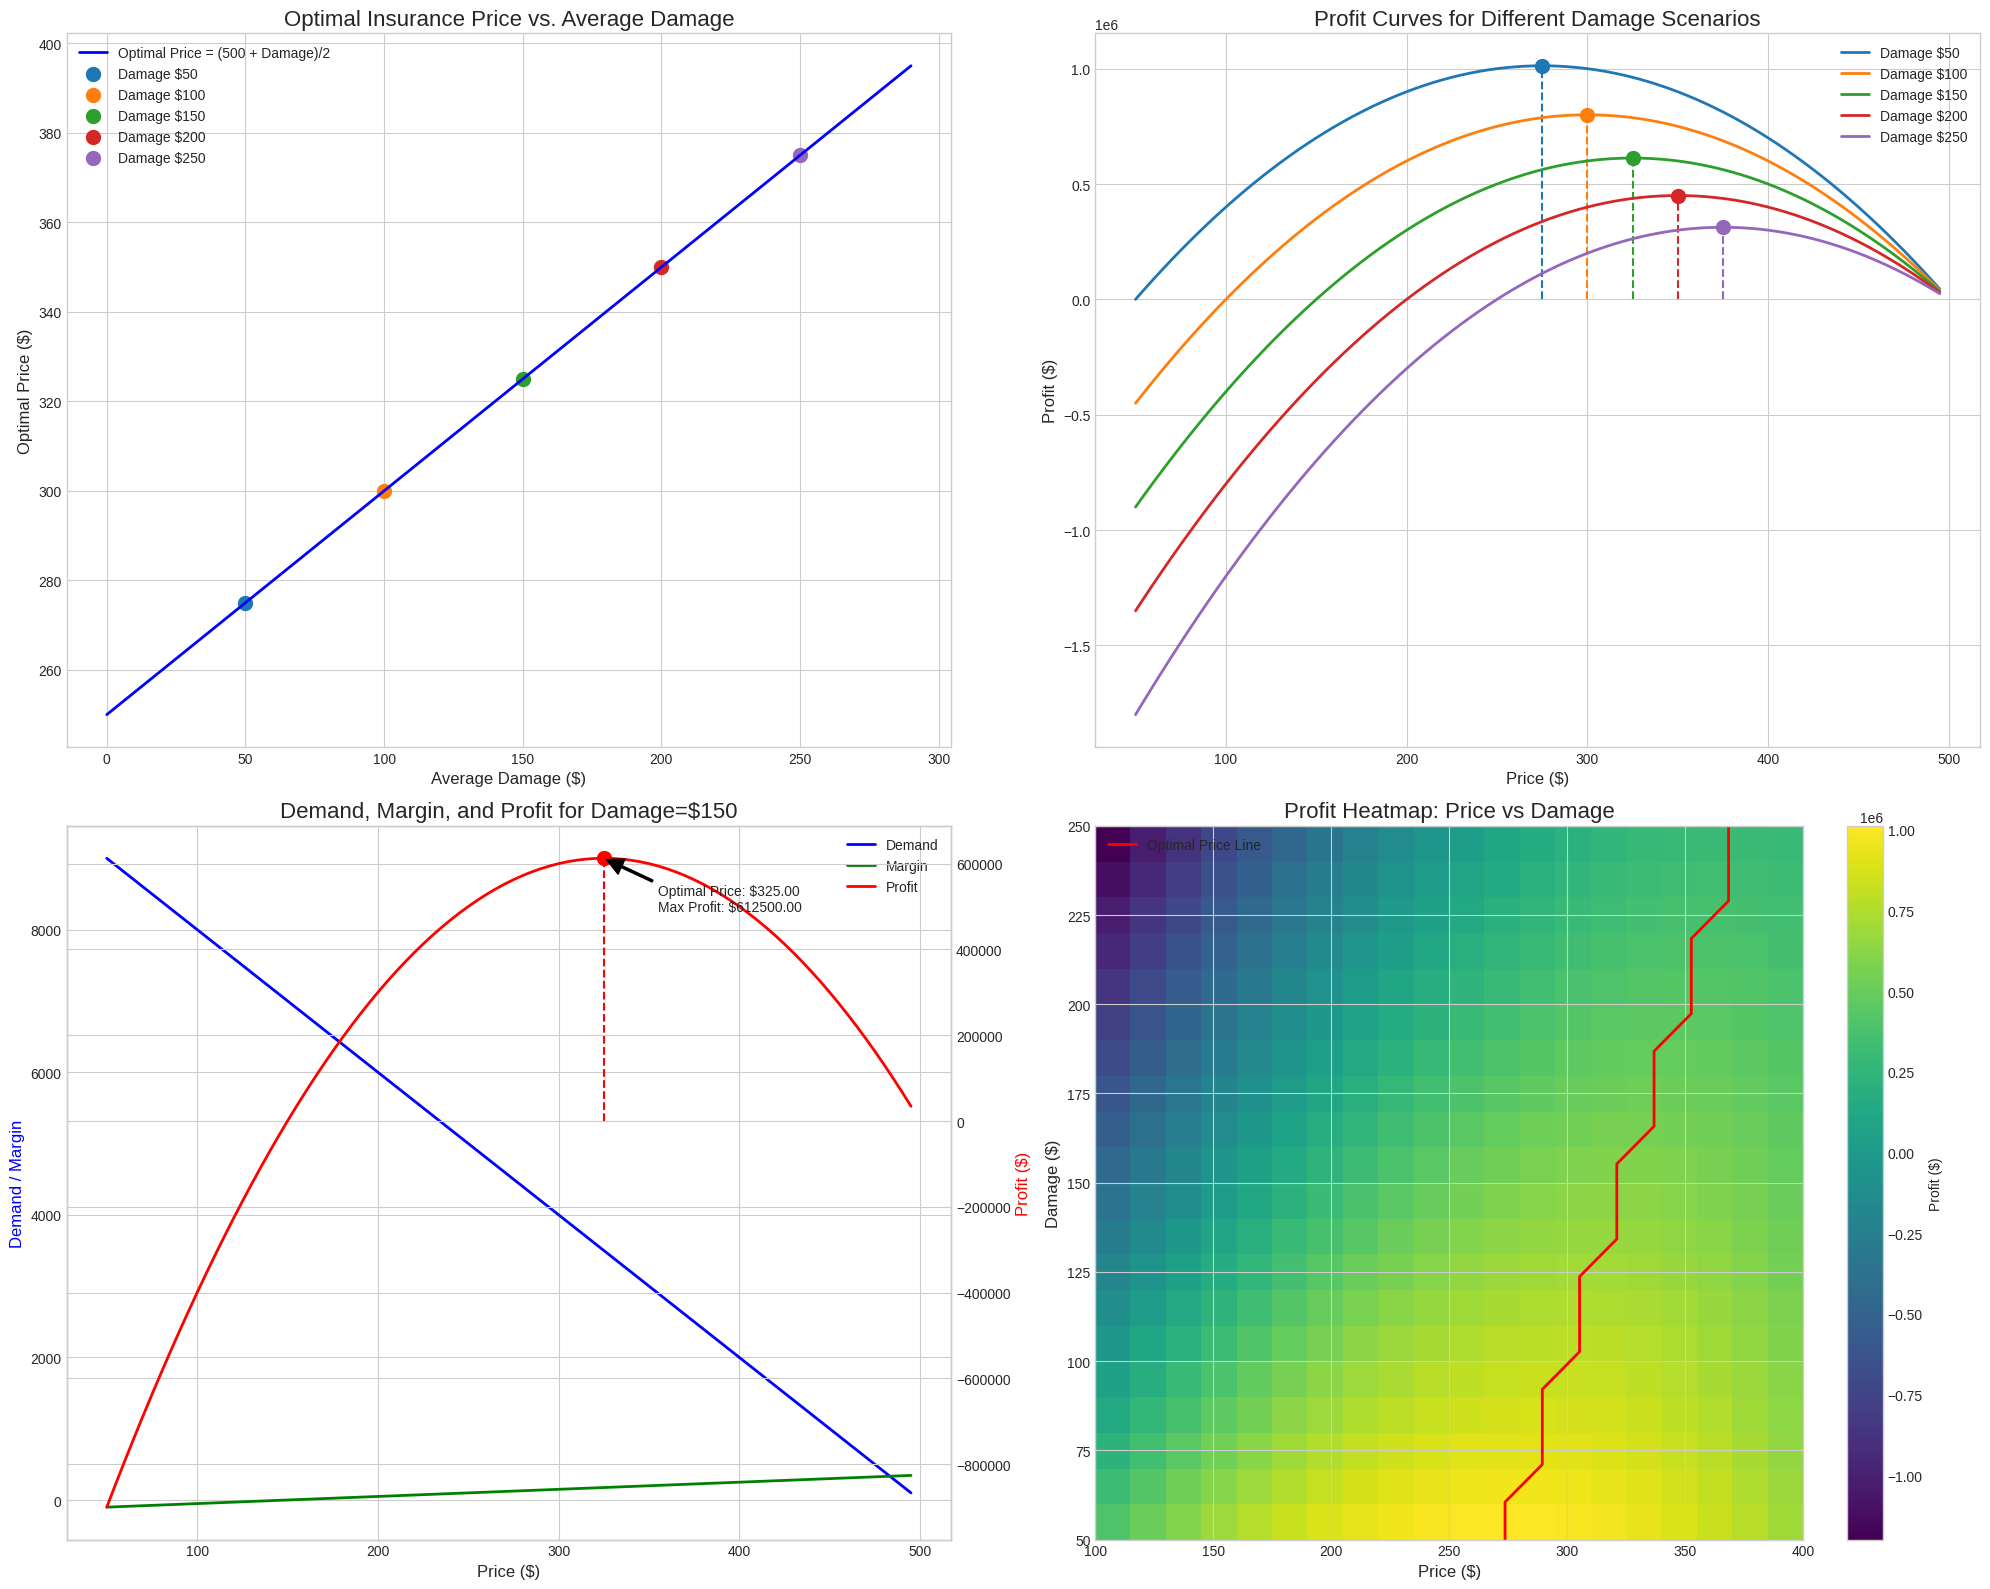

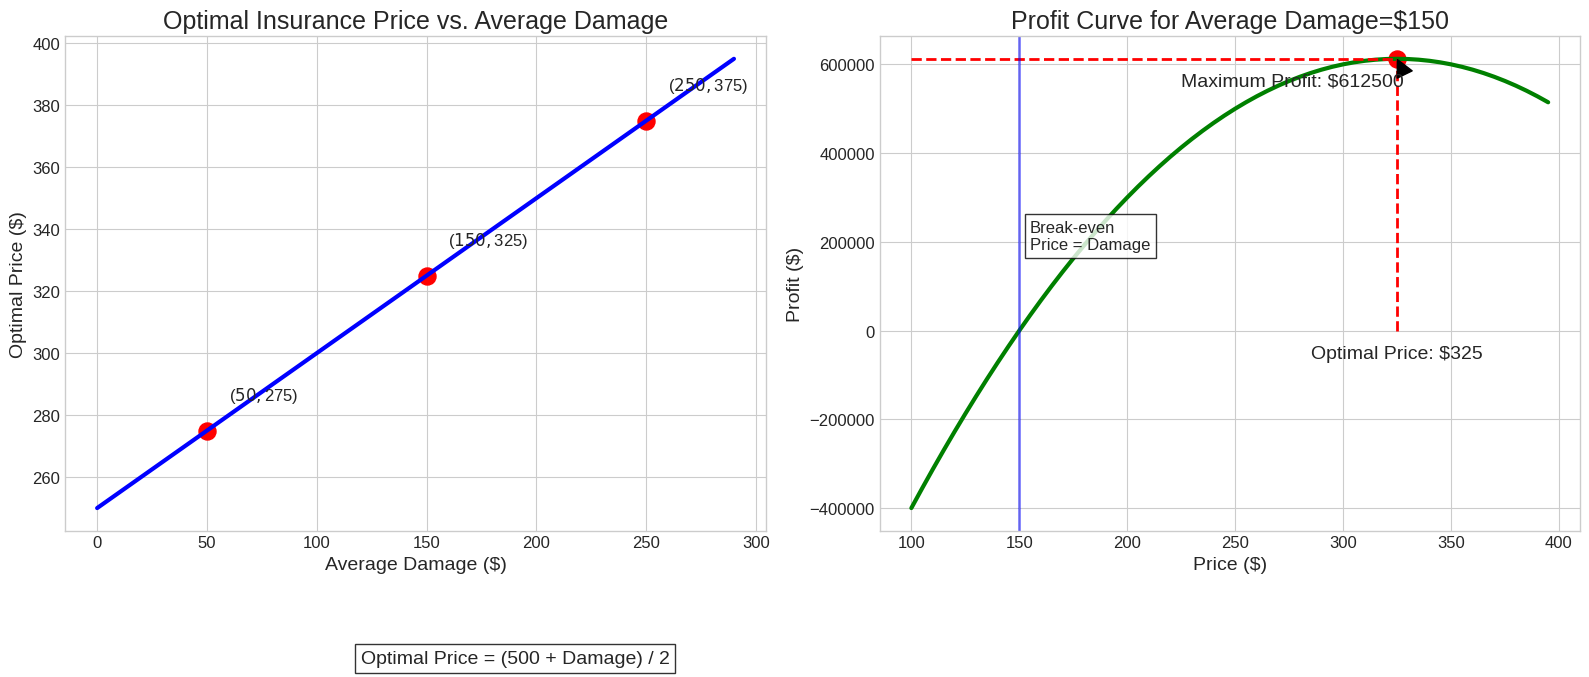

In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style for the plots
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("colorblind")

# Define functions for calculations
def calculate_demand(price):
    """Calculate demand based on price using the formula"""
    return 10000 - (10000/500) * price

def calculate_margin(price, damage):
    """Calculate unit contribution margin"""
    return price - damage

def calculate_profit(price, damage):
    """Calculate total profit for a given price and damage"""
    demand = calculate_demand(price)
    margin = calculate_margin(price, damage)
    return demand * margin

def optimal_price(damage):
    """Calculate optimal price using the formula"""
    return (500 + damage) / 2

def generate_visualizations():
    """Generate visualizations for insurance pricing optimization"""
    # Create figure with multiple subplots
    plt.figure(figsize=(20, 16))

    # Damage scenarios to visualize
    damage_scenarios = [50, 100, 150, 200, 250]
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']

    # 1. Optimal Price vs. Damage Graph
    plt.subplot(2, 2, 1)

    # Generate data for the graph
    damage_range = np.arange(0, 300, 10)
    opt_prices = [(500 + d) / 2 for d in damage_range]

    # Plot the optimal price line
    plt.plot(damage_range, opt_prices, 'b-', linewidth=2, label='Optimal Price = (500 + Damage)/2')

    # Add points for specific damage scenarios
    for i, damage in enumerate(damage_scenarios):
        opt_price = optimal_price(damage)
        plt.scatter(damage, opt_price, s=100, c=colors[i], label=f'Damage ${damage}')

    plt.title('Optimal Insurance Price vs. Average Damage', fontsize=16)
    plt.xlabel('Average Damage ($)', fontsize=12)
    plt.ylabel('Optimal Price ($)', fontsize=12)
    plt.legend(loc='best')
    plt.grid(True)

    # 2. Profit Curves for Different Damage Scenarios
    plt.subplot(2, 2, 2)

    # Generate price range for profit curves
    price_range = np.arange(50, 500, 5)

    # Plot profit curves for each damage scenario
    for i, damage in enumerate(damage_scenarios):
        profits = [calculate_profit(price, damage) for price in price_range]
        plt.plot(price_range, profits, color=colors[i], linewidth=2, label=f'Damage ${damage}')

        # Mark the optimal price point
        opt_price = optimal_price(damage)
        opt_profit = calculate_profit(opt_price, damage)
        plt.scatter(opt_price, opt_profit, s=100, color=colors[i])
        plt.vlines(opt_price, 0, opt_profit, color=colors[i], linestyles='dashed')

    plt.title('Profit Curves for Different Damage Scenarios', fontsize=16)
    plt.xlabel('Price ($)', fontsize=12)
    plt.ylabel('Profit ($)', fontsize=12)
    plt.legend(loc='best')
    plt.grid(True)

    # 3. Detailed View for a Single Damage Scenario
    plt.subplot(2, 2, 3)

    # Select a specific damage scenario
    selected_damage = 150

    # Generate data
    price_range = np.arange(50, 500, 5)
    demand_values = [calculate_demand(price) for price in price_range]
    margin_values = [calculate_margin(price, selected_damage) for price in price_range]
    profit_values = [calculate_profit(price, selected_damage) for price in price_range]

    # Create twin axes for multiple y-scales
    ax1 = plt.gca()
    ax2 = ax1.twinx()

    # Plot demand and margin
    line1, = ax1.plot(price_range, demand_values, 'b-', linewidth=2, label='Demand')
    line2, = ax1.plot(price_range, margin_values, 'g-', linewidth=2, label='Margin')

    # Plot profit on second y-axis
    line3, = ax2.plot(price_range, profit_values, 'r-', linewidth=2, label='Profit')

    # Mark the optimal price
    opt_price = optimal_price(selected_damage)
    opt_profit = calculate_profit(opt_price, selected_damage)
    ax2.scatter(opt_price, opt_profit, s=100, color='red')
    ax2.vlines(opt_price, 0, opt_profit, color='red', linestyles='dashed')

    # Add text annotation for optimal price
    ax2.annotate(f'Optimal Price: ${opt_price:.2f}\nMax Profit: ${opt_profit:.2f}',
                xy=(opt_price, opt_profit),
                xytext=(opt_price+30, opt_profit*0.8),
                arrowprops=dict(facecolor='black', shrink=0.05, width=1.5),
                fontsize=10)

    # Set labels and title
    ax1.set_xlabel('Price ($)', fontsize=12)
    ax1.set_ylabel('Demand / Margin', fontsize=12, color='blue')
    ax2.set_ylabel('Profit ($)', fontsize=12, color='red')
    plt.title(f'Demand, Margin, and Profit for Damage=${selected_damage}', fontsize=16)

    # Combine legends from both axes
    lines = [line1, line2, line3]
    labels = [l.get_label() for l in lines]
    ax1.legend(lines, labels, loc='best')

    # 4. Heatmap showing Profit for Price vs Damage
    plt.subplot(2, 2, 4)

    # Generate data for heatmap
    damages = np.linspace(50, 250, 20)
    prices = np.linspace(100, 400, 20)

    # Create a 2D grid of profit values
    profit_grid = np.zeros((len(damages), len(prices)))

    for i, damage in enumerate(damages):
        for j, price in enumerate(prices):
            profit_grid[i, j] = calculate_profit(price, damage)

    # Create optimal price curve data
    opt_price_idx = []
    for i, damage in enumerate(damages):
        opt_p = optimal_price(damage)
        # Find closest price index
        closest_idx = np.argmin(np.abs(prices - opt_p))
        opt_price_idx.append((i, closest_idx))

    # Plot heatmap
    im = plt.imshow(profit_grid, extent=[prices.min(), prices.max(), damages.min(), damages.max()],
                    aspect='auto', origin='lower', cmap='viridis')

    # Plot optimal price curve on heatmap
    opt_x = [prices[idx[1]] for idx in opt_price_idx]
    opt_y = [damages[idx[0]] for idx in opt_price_idx]
    plt.plot(opt_x, opt_y, 'r-', linewidth=2, label='Optimal Price Line')

    plt.colorbar(im, label='Profit ($)')
    plt.title('Profit Heatmap: Price vs Damage', fontsize=16)
    plt.xlabel('Price ($)', fontsize=12)
    plt.ylabel('Damage ($)', fontsize=12)
    plt.legend(loc='upper left')

    # Adjust layout and save
    plt.tight_layout()
    plt.savefig('insurance_pricing_visualizations.png', dpi=300, bbox_inches='tight')
    print("Visualizations saved as 'insurance_pricing_visualizations.png'")

    # Create a simplified version for presentation slides
    create_simplified_visualizations_for_slides()

def create_simplified_visualizations_for_slides():
    """Create simplified visualizations suitable for presentation slides"""
    # Create a 2x1 layout
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))

    # 1. Simplified Optimal Price vs. Damage Graph
    damage_range = np.arange(0, 300, 10)
    opt_prices = [(500 + d) / 2 for d in damage_range]

    # Plot with larger font sizes and elements for visibility
    ax1.plot(damage_range, opt_prices, 'b-', linewidth=3)

    # Add example points
    damage_examples = [50, 150, 250]
    for damage in damage_examples:
        opt_price = optimal_price(damage)
        ax1.scatter(damage, opt_price, s=150, color='red')
        ax1.annotate(f'(${damage}, ${opt_price:.0f})',
                    xy=(damage, opt_price),
                    xytext=(damage+10, opt_price+10),
                    fontsize=12)

    # Add formula to the plot
    ax1.text(120, 200, 'Optimal Price = (500 + Damage) / 2',
             bbox=dict(facecolor='white', alpha=0.8),
             fontsize=14)

    ax1.set_title('Optimal Insurance Price vs. Average Damage', fontsize=18)
    ax1.set_xlabel('Average Damage ($)', fontsize=14)
    ax1.set_ylabel('Optimal Price ($)', fontsize=14)
    ax1.grid(True)
    ax1.tick_params(axis='both', which='major', labelsize=12)

    # 2. Simplified Profit Curve for a selected damage
    selected_damage = 150
    price_range = np.arange(100, 400, 5)
    profit_values = [calculate_profit(price, selected_damage) for price in price_range]

    # Plot the profit curve
    ax2.plot(price_range, profit_values, 'g-', linewidth=3)

    # Mark the optimal price and profit
    opt_price = optimal_price(selected_damage)
    opt_profit = calculate_profit(opt_price, selected_damage)

    ax2.scatter(opt_price, opt_profit, s=150, color='red')
    ax2.vlines(opt_price, 0, opt_profit, color='red', linestyles='dashed', linewidth=2)
    ax2.hlines(opt_profit, 100, opt_price, color='red', linestyles='dashed', linewidth=2)

    # Add annotations
    ax2.annotate(f'Maximum Profit: ${opt_profit:.0f}',
                xy=(opt_price, opt_profit),
                xytext=(opt_price-100, opt_profit*0.9),
                arrowprops=dict(facecolor='black', shrink=0.05, width=1.5),
                fontsize=14)

    ax2.annotate(f'Optimal Price: ${opt_price:.0f}',
                xy=(opt_price, 0),
                xytext=(opt_price, -opt_profit*0.1),
                fontsize=14,
                ha='center')

    ax2.set_title(f'Profit Curve for Average Damage=${selected_damage}', fontsize=18)
    ax2.set_xlabel('Price ($)', fontsize=14)
    ax2.set_ylabel('Profit ($)', fontsize=14)
    ax2.grid(True)
    ax2.tick_params(axis='both', which='major', labelsize=12)

    # Add break-even point
    ax2.axvline(x=selected_damage, color='blue', linestyle='-', alpha=0.5, linewidth=2)
    ax2.text(selected_damage+5, opt_profit*0.3, 'Break-even\nPrice = Damage',
             fontsize=12, bbox=dict(facecolor='white', alpha=0.8))

    plt.tight_layout()
    plt.savefig('insurance_pricing_slides.png', dpi=300, bbox_inches='tight')
    print("Simplified visualizations for slides saved as 'insurance_pricing_slides.png'")

if __name__ == "__main__":
    generate_visualizations()